In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Caricamento del dataset processato (dal file Excel salvato prima)
df = pd.read_excel("../data/processed/dataset_core_covariates.xlsx")

# Palette e label uniformi
palette = {0: "#003f5c", 1: "#bc5090"}
labels = {0: "No Triade", 1: "Triade"}

📊 Distribuzione classi target_bin:

   Classe  Conteggio  Percentuale
No Triade        164        59.85
   Triade        110        40.15


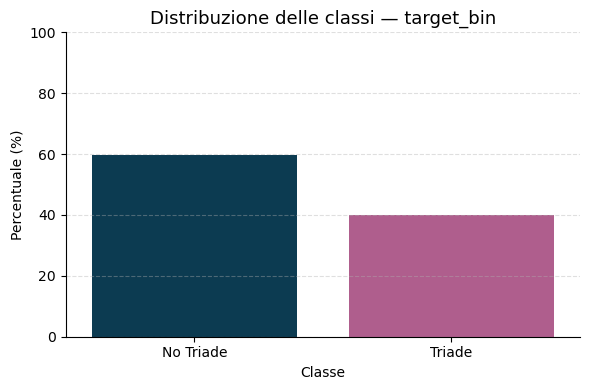

In [2]:
# Conteggio e percentuale
value_counts = df["target_bin"].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Tabella riassuntiva
class_distribution = pd.DataFrame({
    "Classe": value_counts.index.map(labels),
    "Conteggio": value_counts.values,
    "Percentuale": percentages.round(2)
})
print("📊 Distribuzione classi target_bin:\n")
print(class_distribution.to_string(index=False))

# Grafico
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution["Classe"], y=class_distribution["Percentuale"], 
            palette=palette.values())
plt.title("Distribuzione delle classi — target_bin", fontsize=13)
plt.ylabel("Percentuale (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

✅ Dataset caricato da: ../data/processed/dataset_core_covariates.xlsx  shape=(274, 11)
✅ Salvati split stratificati:
- Train: ../data/processed/train_original.csv  shape=(219, 11)
- Test:  ../data/processed/test_original.csv   shape=(55, 11)

📊 Distribuzione classi per split (naturale, stratificata):

Split    Classe  Conteggio  Percentuale
Train No Triade        131        59.82
Train    Triade         88        40.18
 Test No Triade         33        60.00
 Test    Triade         22        40.00


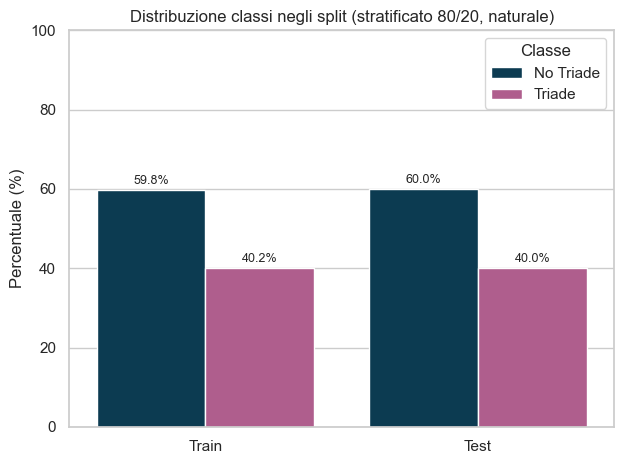

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# ======================
# 1) Carica dataset base (core + covariate)
# ======================
SRC_PATH  = "../data/processed/dataset_core_covariates.xlsx"
OUT_DIR   = "../data/processed"
TRAIN_PATH = os.path.join(OUT_DIR, "train_original.csv")  # <-- su questo si farà balancing/CTGAN
TEST_PATH  = os.path.join(OUT_DIR, "test_original.csv")   # <-- questo resta REALE e NATURALE (no balancing)

df = pd.read_excel(SRC_PATH)
df.columns = df.columns.str.strip()

if "target_bin" not in df.columns:
    raise ValueError("❌ 'target_bin' non trovato in dataset_core_covariates.xlsx")

print(f"✅ Dataset caricato da: {SRC_PATH}  shape={df.shape}")

# Rimuovi eventuali colonne completamente costanti
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
if constant_cols:
    print("ℹ️ Rimuovo colonne costanti:", constant_cols)
    df = df.drop(columns=constant_cols)

# ======================
# 2) Split STRATIFICATO (80/20) — mantiene distribuzione naturale (~60/40) in train e test
# ======================
X = df.drop(columns=["target_bin"])
y = df["target_bin"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
df_test  = pd.concat([X_test.reset_index(drop=True),  y_test.reset_index(drop=True)],  axis=1)

# ======================
# 3) Salvataggio split (STORICI)
#    ⚠️ Qualsiasi bilanciamento/CTGAN va applicato SOLO a df_train.
#    ❌ df_test resta reale, niente sintetici, niente resampling.
# ======================
os.makedirs(OUT_DIR, exist_ok=True)
df_train.to_csv(TRAIN_PATH, index=False)
df_test.to_csv(TEST_PATH, index=False)

print(f"✅ Salvati split stratificati:\n- Train: {TRAIN_PATH}  shape={df_train.shape}\n- Test:  {TEST_PATH}   shape={df_test.shape}")

# ======================
# 4) Check distribuzioni classi (verifica 60/40 circa)
# ======================
def dist_tbl(dfx, name):
    vc = dfx["target_bin"].value_counts().sort_index()
    pct = (vc / vc.sum() * 100).round(2)
    return pd.DataFrame({
        "Split": name,
        "Classe": vc.index.map({0:"No Triade", 1:"Triade"}),
        "Conteggio": vc.values,
        "Percentuale": pct.values
    })

tbl = pd.concat([dist_tbl(df_train, "Train"), dist_tbl(df_test, "Test")], ignore_index=True)
print("\n📊 Distribuzione classi per split (naturale, stratificata):\n")
print(tbl.to_string(index=False))

# ======================
# 5) Grafico (facoltativo)
# ======================
sns.set(style="whitegrid")
ax = sns.barplot(
    data=tbl, x="Split", y="Percentuale", hue="Classe",
    palette=["#003f5c", "#bc5090"]
)
ax.set_title("Distribuzione classi negli split (stratificato 80/20, naturale)")
ax.set_ylim(0, 100); ax.set_xlabel(""); ax.set_ylabel("Percentuale (%)")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%", padding=2, fontsize=9)
plt.tight_layout(); plt.show()


Baseline RF (class_weight='balanced')
AUC ROC  : 0.756
AUC PR   : 0.731
Brier    : 0.190
              precision    recall  f1-score   support

   No Triade       0.72      0.85      0.78        33
      Triade       0.69      0.50      0.58        22

    accuracy                           0.71        55
   macro avg       0.70      0.67      0.68        55
weighted avg       0.71      0.71      0.70        55



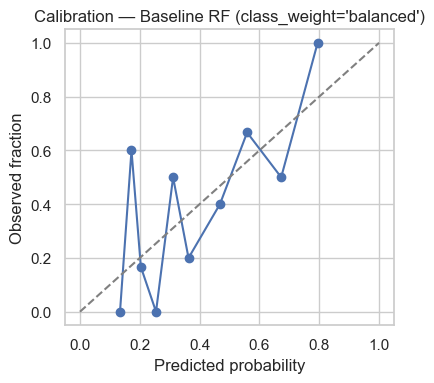


RandomOverSampler RF
AUC ROC: 0.746 | AUC PR: 0.716


In [4]:
# ======================
# BASELINE & OVERSAMPLING
# ======================
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, classification_report
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

TRAIN_PATH = "../data/processed/train_original.csv"
TEST_PATH  = "../data/processed/test_original.csv"

# ---- Load
df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

X_train = df_train.drop(columns=["target_bin"])
y_train = df_train["target_bin"].astype(int)
X_test  = df_test.drop(columns=["target_bin"])
y_test  = df_test["target_bin"].astype(int)

def fit_eval(model, name):
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    auc   = roc_auc_score(y_test, proba)
    aupr  = average_precision_score(y_test, proba)
    brier = brier_score_loss(y_test, proba)

    # soglia 0.5 (più avanti puoi fare sweep per target di sensibilità)
    pred = (proba >= 0.5).astype(int)
    print(f"\n{name}")
    print(f"AUC ROC  : {auc:.3f}")
    print(f"AUC PR   : {aupr:.3f}")
    print(f"Brier    : {brier:.3f}")
    print(classification_report(y_test, pred, target_names=['No Triade','Triade']))

    # calibration curve
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy='quantile')
    plt.figure(figsize=(4.2,4))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title(f"Calibration — {name}")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed fraction")
    plt.tight_layout()
    plt.show()

# ---- Baseline: class_weight balanced
rf_base = RandomForestClassifier(
    n_estimators=600, max_depth=None, random_state=42,
    class_weight='balanced', n_jobs=-1
)
fit_eval(rf_base, "Baseline RF (class_weight='balanced')")

# ---- Oversampling semplice sul TRAIN (mai sul test)
ros = RandomOverSampler(random_state=42)
X_tr_ros, y_tr_ros = ros.fit_resample(X_train, y_train)

rf_ros = RandomForestClassifier(
    n_estimators=600, max_depth=None, random_state=42, n_jobs=-1
)
rf_ros.fit(X_tr_ros, y_tr_ros)
proba = rf_ros.predict_proba(X_test)[:,1]
print("\nRandomOverSampler RF")
print(f"AUC ROC: {roc_auc_score(y_test, proba):.3f} | AUC PR: {average_precision_score(y_test, proba):.3f}")

In [7]:
# ======================
# CTGAN MINORITY AUGMENTATION (pac=1 fix)
# ======================
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from ctgan import CTGAN

# --- Path I/O
TRAIN_PATH = "../data/processed/train_original.csv"
OUT_DIR    = "../data/processed"

# --- Carica train originale
df_train = pd.read_csv(TRAIN_PATH)

# --- Parametri classe
minority_class = 1
majority_class = 0

counts = df_train["target_bin"].value_counts()
n_min = counts.get(minority_class, 0)
n_maj = counts.get(majority_class, 0)
n_to_generate = max(n_maj - n_min, 0)

print(f"📊 Majority: {n_maj} | Minority: {n_min} | To generate: {n_to_generate}")

if n_to_generate == 0:
    print("ℹ️ Il train è già bilanciato: salto CTGAN.")
else:
    # --- Subset: solo minoranza e rimuovi target dal fit
    df_minority = df_train[df_train["target_bin"] == minority_class].copy()
    feature_cols = [c for c in df_minority.columns if c != "target_bin"]
    df_min_features = df_minority[feature_cols]

    # --- Discrete columns: includi int con pochi livelli (ordinali/categoriche)
    discrete_columns = []
    for col in feature_cols:
        if df_min_features[col].dtype == "int64":
            if df_min_features[col].nunique() <= 6:
                discrete_columns.append(col)
    print("🔢 Discrete columns:", discrete_columns)

    # --- CTGAN (fix pac=1 per evitare AssertionError su batch%pac)
    bs = min(64, len(df_min_features))  # batch prudente su dataset piccoli
    ctgan = CTGAN(
        epochs=300,
        batch_size=bs,
        pac=1,                      # << FIX chiave: evita l'assert sull'ultimo batch
        generator_lr=2e-4,
        discriminator_lr=2e-4,
        verbose=True
    )
    ctgan.fit(df_min_features, discrete_columns=discrete_columns)

    # --- Genera sintetici
    df_synth_features = ctgan.sample(n_to_generate)

    # --- Post-process discreti: rounding + clip nell'intervallo osservato
    for col in discrete_columns:
        lo, hi = df_min_features[col].min(), df_min_features[col].max()
        df_synth_features[col] = np.clip(np.rint(df_synth_features[col]).astype(int), lo, hi)

    # --- Ricostruisci target e concatena
    df_synth = df_synth_features.copy()
    df_synth["target_bin"] = minority_class

    df_balanced = pd.concat([df_train, df_synth], ignore_index=True)
    df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)

    # --- Salva
    os.makedirs(OUT_DIR, exist_ok=True)
    df_balanced.to_csv(os.path.join(OUT_DIR, "train_balanced_ctgan.csv"), index=False)
    df_balanced.to_excel(os.path.join(OUT_DIR, "train_balanced_ctgan.xlsx"), index=False)

    print("✅ Salvato train bilanciato (CTGAN). Nuova distribuzione:")
    print(df_balanced["target_bin"].value_counts().to_string())

📊 Majority: 131 | Minority: 88 | To generate: 43
🔢 Discrete columns: ['Sex (M=1, F=2)']


Gen. (-0.80) | Discrim. (-0.00): 100%|██████████| 300/300 [00:02<00:00, 118.48it/s]


✅ Salvato train bilanciato (CTGAN). Nuova distribuzione:
target_bin
1    131
0    131


In [8]:
# === SETUP ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
import warnings
warnings.filterwarnings('ignore')

# === PALETTE ===
palette = {0: "#003f5c", 1: "#bc5090"}
sns.set(style='whitegrid')

# === LOAD DATA ===
real = pd.read_csv("../data/processed/train_original.csv")
synthetic = pd.read_csv("../data/processed/train_balanced_ctgan.csv")

# Sanity check
print("Real shape:", real.shape)
print("Synthetic shape:", synthetic.shape)

Real shape: (219, 11)
Synthetic shape: (262, 11)


🔎 Categorical: ['H-Y', 'Sex (M=1, F=2)', 'target_bin']
🔎 Numerical  : ['Age', 'Duration (years)', 'Gait Speed', 'MSE AP', 'MSE ML', 'MSE V', 'Weigth', 'iHR V']


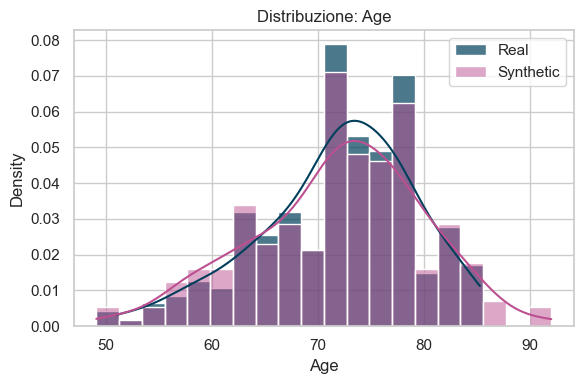

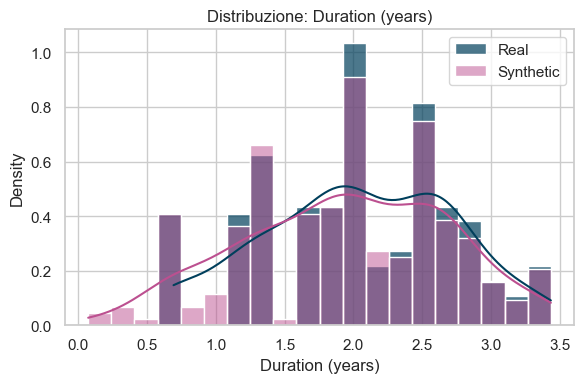

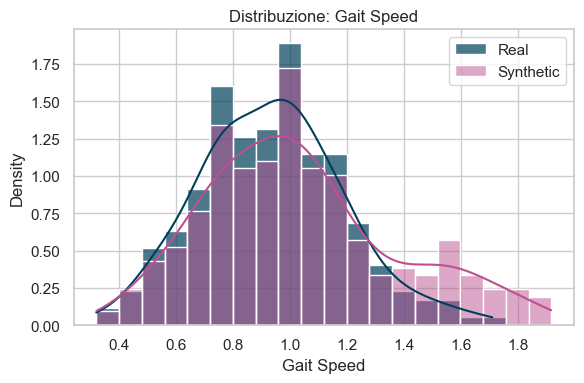

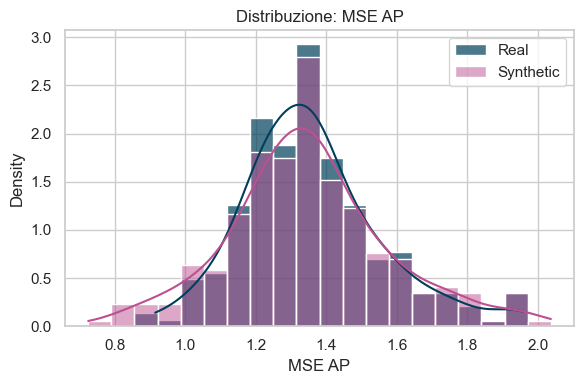

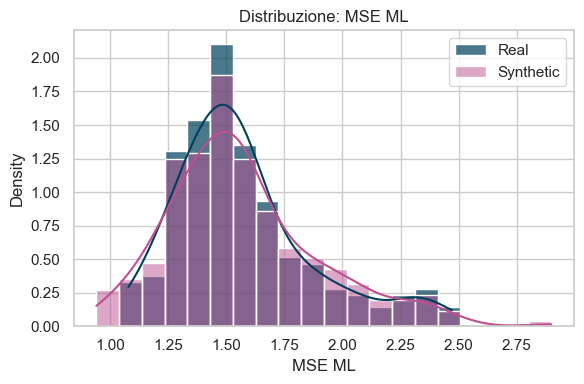

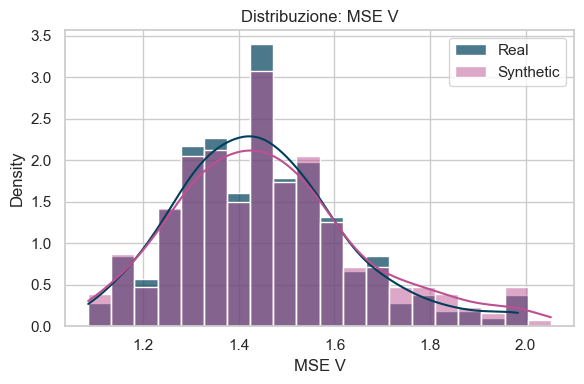

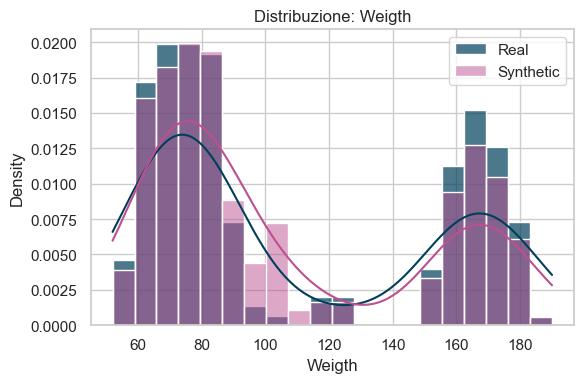

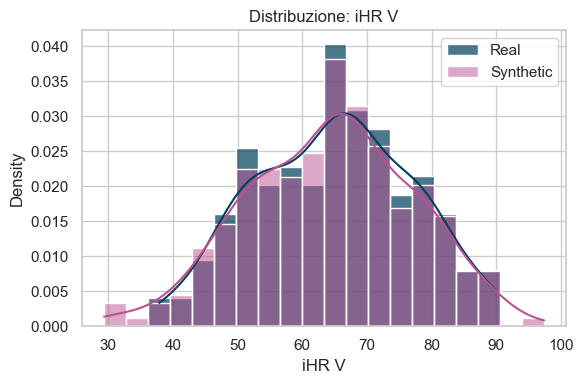

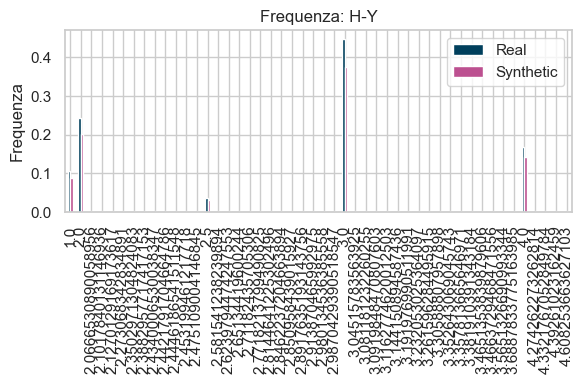

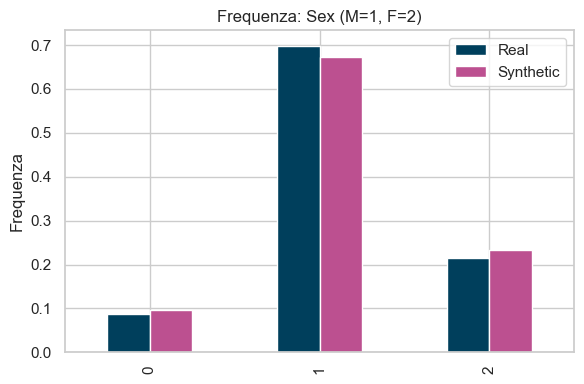

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
palette = {0: "#003f5c", 1: "#bc5090"}

# --- carica split già creati ---
real = pd.read_csv("../data/processed/train_original.csv")
synthetic = pd.read_csv("../data/processed/train_balanced_ctgan.csv")

# --- tieni solo colonne comuni (difese da disallineamenti) ---
common_cols = [c for c in real.columns if c in synthetic.columns]
real = real[common_cols].copy()
synthetic = synthetic[common_cols].copy()

# --- identifica target e categoriche/numeriche in modo data-driven ---
target_col = "target_bin"

# candidati categorici: poche modalità (<=6) oppure colonne note
maybe_cat = []
for col in common_cols:
    if col == target_col:
        maybe_cat.append(col)
    else:
        if pd.api.types.is_integer_dtype(real[col]) or pd.api.types.is_bool_dtype(real[col]):
            if real[col].nunique(dropna=True) <= 6:
                maybe_cat.append(col)

# alcuni campi noti da forzare come categorici se presenti
for force_cat in ["Sex (M=1, F=2)", "H-Y"]:
    if force_cat in common_cols and force_cat not in maybe_cat:
        maybe_cat.append(force_cat)

categorical = sorted(list(dict.fromkeys(maybe_cat)))
numerical = sorted([c for c in common_cols if c not in categorical])

print("🔎 Categorical:", categorical)
print("🔎 Numerical  :", numerical)

# === PLOT: Numeriche (overlay real vs synth) ===
for col in numerical:
    fig, ax = plt.subplots(figsize=(6, 4))
    # bin condivisi su range combinato
    vals = pd.concat([real[col], synthetic[col]], axis=0).dropna().values
    if len(vals) < 3:
        continue
    bins = np.histogram_bin_edges(vals, bins=20)

    sns.histplot(real[col], bins=bins, stat="density", kde=True,
                 color=palette[0], label="Real", alpha=0.7, ax=ax)
    sns.histplot(synthetic[col], bins=bins, stat="density", kde=True,
                 color=palette[1], label="Synthetic", alpha=0.5, ax=ax)

    ax.set_title(f"Distribuzione: {col}")
    ax.legend()
    plt.tight_layout()
    plt.show()

# === PLOT: Categoriali (barplot frequenze) ===
for col in categorical:
    # salta target se vuoi
    if col == target_col:
        continue

    r_counts = real[col].value_counts(normalize=True).sort_index()
    s_counts = synthetic[col].value_counts(normalize=True).sort_index()
    idx = sorted(set(r_counts.index).union(set(s_counts.index)))
    df_plot = pd.DataFrame({
        "Real": r_counts.reindex(idx).fillna(0),
        "Synthetic": s_counts.reindex(idx).fillna(0)
    })

    ax = df_plot.plot(kind="bar", figsize=(6,4), color=[palette[0], palette[1]])
    ax.set_title(f"Frequenza: {col}")
    ax.set_ylabel("Frequenza")
    ax.set_xlabel("")
    plt.tight_layout()
    plt.show()

In [10]:
from scipy.stats import ks_2samp, chi2_contingency

ks_results = []
chi2_results = []

print("=== Kolmogorov-Smirnov Test (numeriche) ===")
for col in numerical:
    stat, p = ks_2samp(real[col], synthetic[col])
    ks_results.append({"Feature": col, "p_value": p, "Pass": p > 0.05})
    print(f"{col}: KS p-value = {p:.5f} {'(✅ ok)' if p > 0.05 else '(❌ diff)'}")

print("\n=== Chi-Square Test (categoriche) ===")
for col in categorical:
    real_freq = real[col].value_counts()
    synth_freq = synthetic[col].value_counts()
    df_chi = pd.concat([real_freq, synth_freq], axis=1).fillna(0)
    chi2, p, _, _ = chi2_contingency(df_chi.T)
    chi2_results.append({"Feature": col, "p_value": p, "Pass": p > 0.05})
    print(f"{col}: Chi2 p-value = {p:.5f} {'(✅ ok)' if p > 0.05 else '(❌ diff)'}")

# Summary
ks_summary = pd.DataFrame(ks_results)
chi2_summary = pd.DataFrame(chi2_results)

print("\n📊 Summary numeriche:")
print(ks_summary["Pass"].value_counts(), "/", len(ks_summary))

print("\n📊 Summary categoriche:")
print(chi2_summary["Pass"].value_counts(), "/", len(chi2_summary))

=== Kolmogorov-Smirnov Test (numeriche) ===
Age: KS p-value = 0.99642 (✅ ok)
Duration (years): KS p-value = 0.80456 (✅ ok)
Gait Speed: KS p-value = 0.03484 (❌ diff)
MSE AP: KS p-value = 0.87996 (✅ ok)
MSE ML: KS p-value = 0.94714 (✅ ok)
MSE V: KS p-value = 0.99194 (✅ ok)
Weigth: KS p-value = 0.71328 (✅ ok)
iHR V: KS p-value = 1.00000 (✅ ok)

=== Chi-Square Test (categoriche) ===
H-Y: Chi2 p-value = 0.77414 (✅ ok)
Sex (M=1, F=2): Chi2 p-value = 0.81872 (✅ ok)
target_bin: Chi2 p-value = 0.03929 (❌ diff)

📊 Summary numeriche:
Pass
True     7
False    1
Name: count, dtype: int64 / 8

📊 Summary categoriche:
Pass
True     2
False    1
Name: count, dtype: int64 / 3


In [11]:
# ======================
# 🔍 KS / χ² STRATIFICATI SOLO SU MINORANZA
# ======================

minority_class = 1

real_min = real[real["target_bin"] == minority_class].copy()
synth_min = synthetic[synthetic["target_bin"] == minority_class].copy()

print(f"=== Confronto Real vs Synthetic SOLO per classe minority ({minority_class} = Triade) ===")

# --- Kolmogorov-Smirnov per variabili numeriche
print("\n=== KS test numeriche (minoranza) ===")
ks_results_min = {}
for col in numerical:
    stat, p = ks_2samp(real_min[col], synth_min[col])
    ks_results_min[col] = p
    print(f"{col}: KS p-value = {p:.5f} {'(✅)' if p > 0.05 else '(❌)'}")

# --- Chi-Square per variabili categoriche (eccetto target_bin)
print("\n=== Chi-Square test categoriche (minoranza) ===")
chi_results_min = {}
for col in [c for c in categorical if c != "target_bin"]:
    real_freq = real_min[col].value_counts()
    synth_freq = synth_min[col].value_counts()
    df_chi = pd.concat([real_freq, synth_freq], axis=1).fillna(0)
    chi2, p, _, _ = chi2_contingency(df_chi.T)
    chi_results_min[col] = p
    print(f"{col}: Chi2 p-value = {p:.5f} {'(✅)' if p > 0.05 else '(❌)'}")

# --- Summary
print("\n📊 Summary numeriche (minoranza):")
print(pd.Series([p > 0.05 for p in ks_results_min.values()]).value_counts(), "/", len(ks_results_min))

print("\n📊 Summary categoriche (minoranza):")
print(pd.Series([p > 0.05 for p in chi_results_min.values()]).value_counts(), "/", len(chi_results_min))

=== Confronto Real vs Synthetic SOLO per classe minority (1 = Triade) ===

=== KS test numeriche (minoranza) ===
Age: KS p-value = 0.91259 (✅)
Duration (years): KS p-value = 0.26259 (✅)
Gait Speed: KS p-value = 0.00150 (❌)
MSE AP: KS p-value = 0.44989 (✅)
MSE ML: KS p-value = 0.49146 (✅)
MSE V: KS p-value = 0.99445 (✅)
Weigth: KS p-value = 0.46236 (✅)
iHR V: KS p-value = 0.72751 (✅)

=== Chi-Square test categoriche (minoranza) ===
H-Y: Chi2 p-value = 0.87987 (✅)
Sex (M=1, F=2): Chi2 p-value = 0.50365 (✅)

📊 Summary numeriche (minoranza):
True     7
False    1
Name: count, dtype: int64 / 8

📊 Summary categoriche (minoranza):
True    2
Name: count, dtype: int64 / 2


📊 Similarità correlazioni (MAE): 0.047


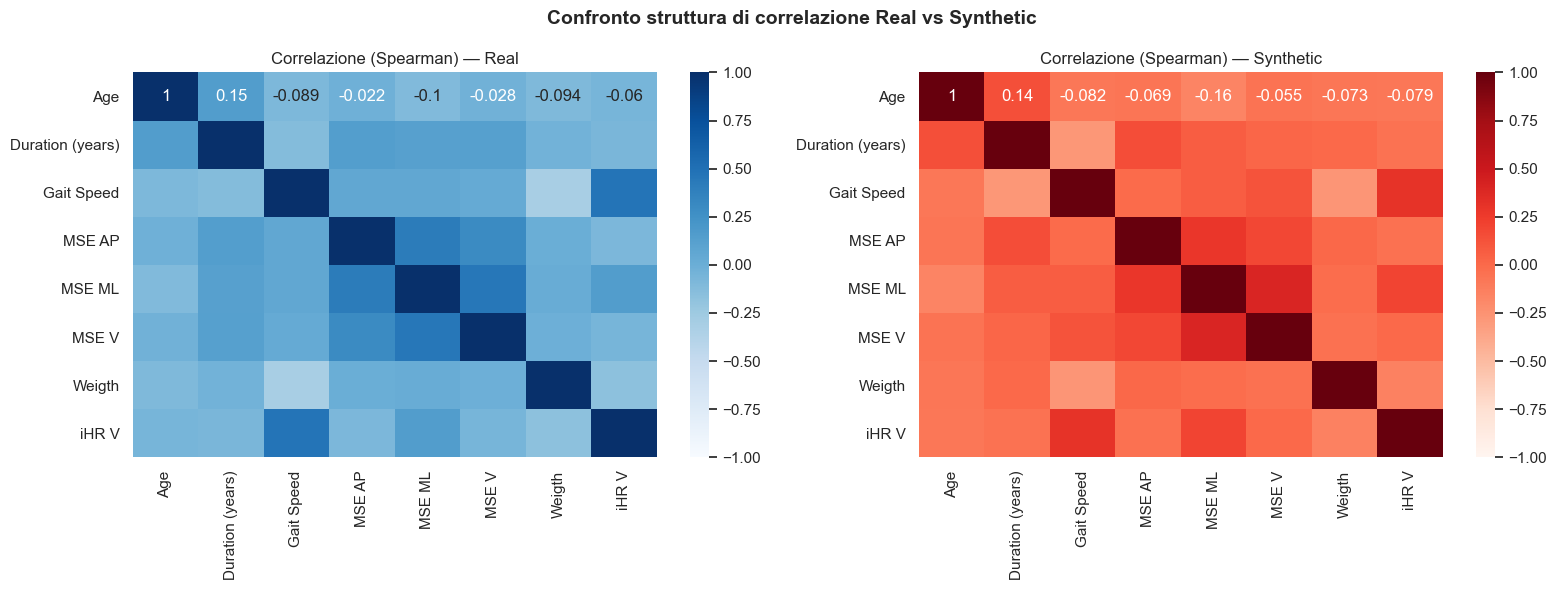

In [12]:
# ======================
# 🔍 Correlazione numeriche: Real vs Synthetic
# ======================
import numpy as np

# Calcolo correlazioni Spearman
corr_real = real[numerical].corr(method="spearman")
corr_synth = synthetic[numerical].corr(method="spearman")

# Metrica di similarità: errore medio assoluto tra le due matrici
mae_corr = np.mean(np.abs(corr_real.values - corr_synth.values))
print(f"📊 Similarità correlazioni (MAE): {mae_corr:.3f}")

# Heatmap affiancate
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_real, annot=True, cmap="Blues", vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Correlazione (Spearman) — Real")

sns.heatmap(corr_synth, annot=True, cmap="Reds", vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Correlazione (Spearman) — Synthetic")

plt.suptitle("Confronto struttura di correlazione Real vs Synthetic", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# === Load ===
real = pd.read_csv("../data/processed/train_original.csv")
synthetic = pd.read_csv("../data/processed/train_balanced_ctgan.csv")

# === Keep common numeric columns (drop target) ===
drop_cols = ["target_bin"]
common_cols = [c for c in real.columns if c in synthetic.columns and c not in drop_cols]
real_num = real[common_cols].copy()
synth_num = synthetic[common_cols].copy()

# === Scale with REAL stats only (evaluation-friendly) ===
scaler = StandardScaler().fit(real_num)
R = scaler.transform(real_num)
S = scaler.transform(synth_num)

# === Helper: nearest neighbor distances ===
def nn_dists(X_train, X_query, n_neighbors=1):
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X_train)
    dists, _ = nn.kneighbors(X_query)
    return dists[:, 0]

# 1) Granulosità reale: distanza NN tra i REALI (leave-one-out via trick)
#    (usiamo NN sui real e poi, per evitare il punto su sé stesso, chiediamo 2 vicini e prendiamo il secondo)
nn_real = NearestNeighbors(n_neighbors=2, metric="euclidean").fit(R)
d_rr, _ = nn_real.kneighbors(R)
real2real = d_rr[:, 1]  # secondo vicino = LOO approx

# Soglie data-driven (scegline una: median o p05)
thr_med = np.median(real2real)
thr_p05 = np.quantile(real2real, 0.05)

# 2) Fidelity (precision): ogni sintetico ha un reale vicino?
#    => NN su REAL, query SYNTH
s2r = nn_dists(R, S)            # distanze S->nearest R
fidelity_med = np.mean(s2r <= thr_med)
fidelity_p05 = np.mean(s2r <= thr_p05)

# 3) Coverage (recall): ogni reale è “coperto” da un sintetico?
#    => NN su SYNTH, query REAL
r2s = nn_dists(S, R)            # distanze R->nearest S
coverage_med = np.mean(r2s <= thr_med)
coverage_p05 = np.mean(r2s <= thr_p05)

# --- Report ---
def q(x):  # quick quantiles
    return np.quantile(x, [0.25, 0.5, 0.75])

print("📐 Granulosità real-real (NN LOO):")
print(f"  median={thr_med:.3f} | p05={thr_p05:.3f} | IQR={q(real2real)}")

print("\n🎯 Fidelity / Precision (S→R):")
print(f"  median-thr: {fidelity_med:.3f}   | p05-thr: {fidelity_p05:.3f}")
print(f"  dist S→R  q25/50/75: {q(s2r)}")

print("\n🛡️ Coverage / Recall (R→S):")
print(f"  median-thr: {coverage_med:.3f} | p05-thr: {coverage_p05:.3f}")
print(f"  dist R→S  q25/50/75: {q(r2s)}")

📐 Granulosità real-real (NN LOO):
  median=1.632 | p05=0.908 | IQR=[1.32843165 1.63237373 2.08655711]

🎯 Fidelity / Precision (S→R):
  median-thr: 0.836   | p05-thr: 0.836
  dist S→R  q25/50/75: [0. 0. 0.]

🛡️ Coverage / Recall (R→S):
  median-thr: 1.000 | p05-thr: 1.000
  dist R→S  q25/50/75: [0. 0. 0.]


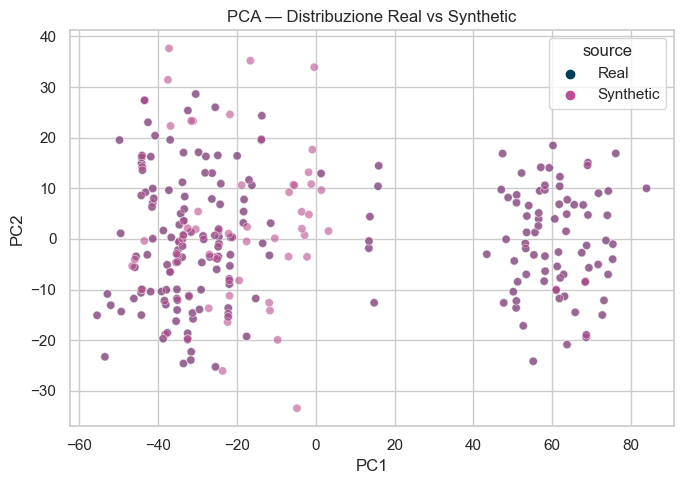

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aggiungi colonna 'source'
real_copy = real.copy()
real_copy["source"] = "Real"

synthetic_copy = synthetic.copy()
synthetic_copy["source"] = "Synthetic"

# Combina i due dataset
df_combined = pd.concat([real_copy, synthetic_copy], ignore_index=True)

# Rimuovi target e colonna source prima di PCA
X = df_combined.drop(columns=["target_bin", "source"], errors="ignore")

# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Costruisci DataFrame per il plot
df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["source"] = df_combined["source"].values

# Plot PCA
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="source", alpha=0.6, palette={"Real":"#003f5c", "Synthetic":"#bc5090"})
plt.title("PCA — Distribuzione Real vs Synthetic")
plt.tight_layout()
plt.show()

In [ ]:
# === PCA 3D interattiva: Real vs Synthetic ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import os

# --- Load ---
real = pd.read_csv("../data/processed/train_original.csv")
synt = pd.read_csv("../data/processed/train_balanced_ctgan.csv")

# --- Allinea colonne e prepara etichette ---
drop_cols = ["target_bin"]
common = [c for c in real.columns if c in synt.columns and c not in drop_cols]

X_real = real[common].copy()
X_synt = synt[common].copy()
src_real = pd.Series("Real", index=X_real.index, name="source")
src_synt = pd.Series("Synthetic", index=X_synt.index, name="source")

# (opzionale) porta anche la classe per hover
y_real = real["target_bin"].astype(int)
y_synt = synt["target_bin"].astype(int)

# --- Standardizzazione condivisa ---
scaler = StandardScaler()
X_all = np.vstack([X_real.values, X_synt.values])
X_all_sc = scaler.fit_transform(X_all)

# --- PCA 3 componenti ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_all_sc)

expl = pca.explained_variance_ratio_ * 100
print(f"Varianza spiegata: PC1={expl[0]:.1f}%, PC2={expl[1]:.1f}%, PC3={expl[2]:.1f}%")

# --- Costruisci dataframe per il plot ---
n_real = len(X_real)
df_plot = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "PC3": X_pca[:,2],
    "source": pd.concat([src_real, src_synt], ignore_index=True),
    "target_bin": pd.concat([y_real, y_synt], ignore_index=True)
})

# --- Colori coerenti ---
palette = {"Real": "#003f5c", "Synthetic": "#bc5090"}

# --- Figura 3D interattiva ---
fig = go.Figure()

for src in ["Real", "Synthetic"]:
    d = df_plot[df_plot["source"] == src]
    fig.add_trace(go.Scatter3d(
        x=d["PC1"], y=d["PC2"], z=d["PC3"],
        mode="markers",
        marker=dict(size=5, opacity=0.85, color=palette[src], line=dict(width=0.5, color="white")),
        name=src,
        hovertemplate=(
            "<b>%{text}</b><br>" +
            "PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<br>" +
            "target_bin: %{customdata}"
        ),
        text=[src]*len(d),
        customdata=d["target_bin"]
    ))

fig.update_layout(
    title=f"PCA 3D — Distribuzione Real vs Synthetic<br>"
          f"<sup>PC1 {expl[0]:.1f}% • PC2 {expl[1]:.1f}% • PC3 {expl[2]:.1f}% varianza</sup>",
    scene=dict(
        xaxis_title=f"PC1 ({expl[0]:.1f}% var)",
        yaxis_title=f"PC2 ({expl[1]:.1f}% var)",
        zaxis_title=f"PC3 ({expl[2]:.1f}% var)",
        xaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
        yaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
        zaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
    ),
    legend=dict(title="source"),
    template="plotly_white",
    margin=dict(l=0, r=0, t=60, b=0)
)

# --- Salva HTML interattivo ---
os.makedirs("../figurez/global", exist_ok=True)
out_path = "../figurez/global/pca_real_vs_synth_3d.html"
fig.write_html(out_path)
print(f"✅ Salvato: {out_path}")

fig.show()

Varianza spiegata: PC1=21.2%, PC2=18.4%, PC3=12.8%
✅ Salvato: ../figures/pca_real_vs_synth_3d.html


In [18]:
# === 1) Import
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    average_precision_score, brier_score_loss
)

# === 2) Carica il train REAL-ONLY
real = pd.read_csv("../data/processed/train_original.csv")
real.columns = real.columns.str.strip()

if "target_bin" not in real.columns:
    raise ValueError("❌ 'target_bin' non trovato in train_original.csv")

# === 3) Definisci X, y (niente drop: qui non ci sono i prodromi)
X = real.drop(columns=["target_bin"])
y = real["target_bin"].astype(int)

# (opzionale) check
print(f"✅ Train real-only shape: {real.shape}")
print("🔎 Feature usate:", X.columns.tolist())

# === 4) K-Fold CV (10-fold, stratificato)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accs, f1s, rocs, auprcs, briers = [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Random Forest bilanciata (baseline)
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)

    y_pred  = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    rocs.append(roc_auc_score(y_val, y_proba))
    auprcs.append(average_precision_score(y_val, y_proba))
    briers.append(brier_score_loss(y_val, y_proba))

    print(f"\n--- Fold {fold} ---")
    print(f"Accuracy : {accs[-1]:.3f}")
    print(f"F1-score : {f1s[-1]:.3f}")
    print(f"ROC AUC  : {rocs[-1]:.3f}")
    print(f"PR AUC   : {auprcs[-1]:.3f}")
    print(f"Brier    : {briers[-1]:.3f}")

# === 5) Riepilogo finale
def mean_std(a): 
    return f"{np.mean(a):.3f} ± {np.std(a):.3f}"

print("\n🎯 K-Fold (real-only, RF balanced) — media ± sd")
print("Accuracy :", mean_std(accs))
print("F1-score :", mean_std(f1s))
print("ROC AUC  :", mean_std(rocs))
print("PR AUC   :", mean_std(auprcs))
print("Brier    :", mean_std(briers))

✅ Train real-only shape: (219, 11)
🔎 Feature usate: ['MSE ML', 'iHR V', 'MSE V', 'MSE AP', 'Weigth', 'Age', 'Sex (M=1, F=2)', 'H-Y', 'Gait Speed', 'Duration (years)']

--- Fold 1 ---
Accuracy : 0.773
F1-score : 0.615
ROC AUC  : 0.855
PR AUC   : 0.894
Brier    : 0.150

--- Fold 2 ---
Accuracy : 0.727
F1-score : 0.700
ROC AUC  : 0.872
PR AUC   : 0.848
Brier    : 0.147

--- Fold 3 ---
Accuracy : 0.682
F1-score : 0.533
ROC AUC  : 0.778
PR AUC   : 0.777
Brier    : 0.185

--- Fold 4 ---
Accuracy : 0.773
F1-score : 0.706
ROC AUC  : 0.756
PR AUC   : 0.712
Brier    : 0.194

--- Fold 5 ---
Accuracy : 0.591
F1-score : 0.471
ROC AUC  : 0.658
PR AUC   : 0.648
Brier    : 0.242

--- Fold 6 ---
Accuracy : 0.636
F1-score : 0.500
ROC AUC  : 0.735
PR AUC   : 0.749
Brier    : 0.199

--- Fold 7 ---
Accuracy : 0.818
F1-score : 0.750
ROC AUC  : 0.910
PR AUC   : 0.850
Brier    : 0.134

--- Fold 8 ---
Accuracy : 0.864
F1-score : 0.824
ROC AUC  : 0.897
PR AUC   : 0.891
Brier    : 0.134

--- Fold 9 ---
Accuracy 

🔍 Top 10 Feature Importances (media ± sd su CV):
         Feature  Importance     SD
          MSE ML      0.1802 0.0149
           iHR V      0.1342 0.0123
          Weigth      0.1324 0.0050
           MSE V      0.1161 0.0119
          MSE AP      0.1084 0.0069
             Age      0.0880 0.0065
      Gait Speed      0.0868 0.0045
Duration (years)      0.0846 0.0049
             H-Y      0.0421 0.0023
  Sex (M=1, F=2)      0.0271 0.0024


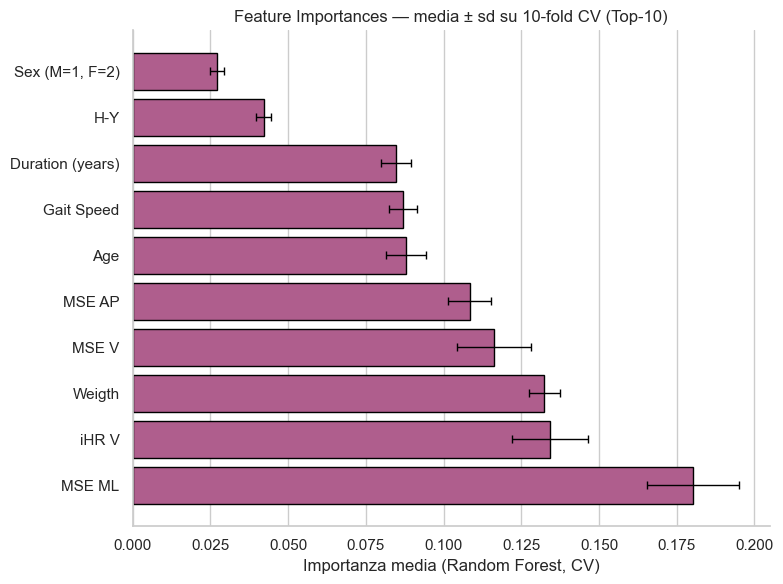

In [19]:
# === Import ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

sns.set(style="whitegrid")

# === Dati (usa gli stessi X, y e kf del blocco precedente; 
#     se non esistono in memoria, decommenta le 4 righe sotto) ===
# real = pd.read_csv("../data/processed/train_original.csv")
# features_to_drop = ["Constipation", "Hyposmia", "REM", "Depression", "Cadence"]
# X = real.drop(columns=["target_bin"] + features_to_drop)
# y = real["target_bin"]
# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === 1) Importanze per fold ===
importances_all = []
for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf = RandomForestClassifier(
        n_estimators=500,
        max_features="sqrt",
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    importances_all.append(rf.feature_importances_)

importances_all = np.vstack(importances_all)  # shape: (n_folds, n_features)

# === 2) Media e deviazione standard ===
imp_mean = importances_all.mean(axis=0)
imp_std  = importances_all.std(axis=0)

feat_importance = (
    pd.DataFrame({"Feature": X.columns, "Importance_mean": imp_mean, "Importance_std": imp_std})
      .sort_values("Importance_mean", ascending=False)
      .reset_index(drop=True)
)

print("🔍 Top 10 Feature Importances (media ± sd su CV):")
print(
    feat_importance.head(10)
    .assign(Importance=lambda d: d["Importance_mean"].round(4),
            SD=lambda d: d["Importance_std"].round(4))
    [["Feature","Importance","SD"]]
    .to_string(index=False)
)

# === 3) Plot barplot (Top-10) ===
topk = 10
plot_df = feat_importance.head(topk).iloc[::-1]  # inverti per avere la più importante in alto

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_df,
    x="Importance_mean",
    y="Feature",
    color="#bc5090",  # rosa (coerente)
    edgecolor="black"
)
# Barre d'errore (±1 SD)
ax.errorbar(
    x=plot_df["Importance_mean"],
    y=np.arange(len(plot_df)),
    xerr=plot_df["Importance_std"],
    fmt="none",
    ecolor="black",
    elinewidth=1,
    capsize=3
)

ax.set_xlabel("Importanza media (Random Forest, CV)")
ax.set_ylabel("")
ax.set_title("Feature Importances — media ± sd su 10-fold CV (Top-10)")
sns.despine()
plt.tight_layout()
plt.show()

Brier (uncalibrated): 0.190
Brier (calibrated)  : 0.195


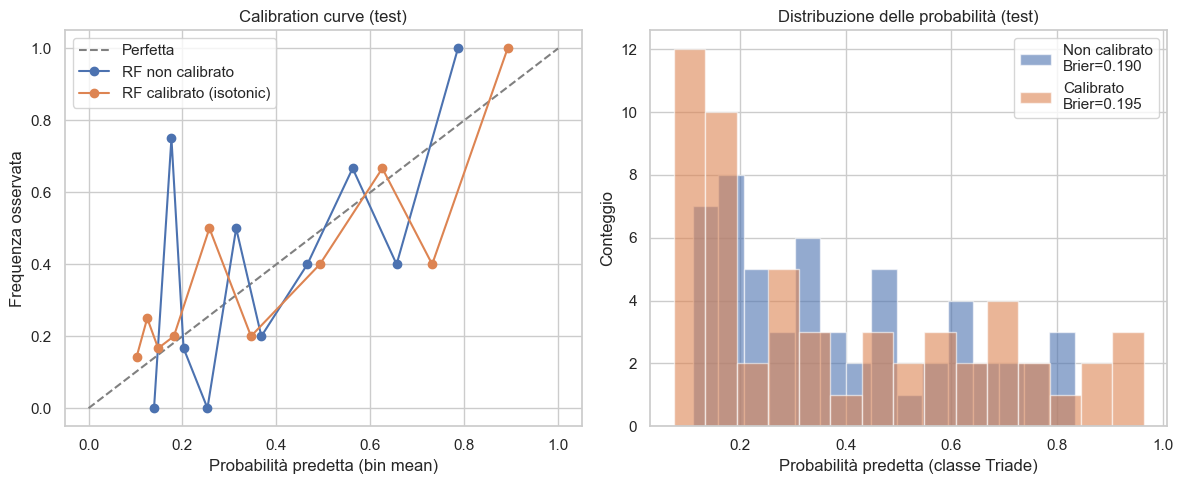

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1) Load train/test
# -----------------------------
train = pd.read_csv("../data/processed/train_original.csv")
test  = pd.read_csv("../data/processed/test_original.csv")

y_train = train["target_bin"].astype(int)
X_train = train.drop(columns=["target_bin"])

y_test  = test["target_bin"].astype(int)
X_test  = test.drop(columns=["target_bin"])

# -----------------------------
# 2) Modello base (non calibrato)
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf.fit(X_train, y_train)
proba_uncal = rf.predict_proba(X_test)[:, 1]

# -----------------------------
# 3) Modello calibrato (isotonic, cv=5) – fit su train, eval su test
# -----------------------------
rf_base = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
calib = CalibratedClassifierCV(rf_base, method="isotonic", cv=5)
calib.fit(X_train, y_train)
proba_cal = calib.predict_proba(X_test)[:, 1]

# -----------------------------
# 4) Calibration curves + Brier
# -----------------------------
prob_true_unc, prob_pred_unc = calibration_curve(y_test, proba_uncal, n_bins=10, strategy="quantile")
prob_true_cal, prob_pred_cal = calibration_curve(y_test, proba_cal, n_bins=10, strategy="quantile")

brier_unc = brier_score_loss(y_test, proba_uncal)
brier_cal = brier_score_loss(y_test, proba_cal)

print(f"Brier (uncalibrated): {brier_unc:.3f}")
print(f"Brier (calibrated)  : {brier_cal:.3f}")

# -----------------------------
# 5) Plot: calibration + hist
# -----------------------------
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# a) Calibration curve
ax = axes[0]
ax.plot([0, 1], [0, 1], "--", color="gray", label="Perfetta")
ax.plot(prob_pred_unc, prob_true_unc, "o-", label="RF non calibrato")
ax.plot(prob_pred_cal, prob_true_cal, "o-", label="RF calibrato (isotonic)")
ax.set_xlabel("Probabilità predetta (bin mean)")
ax.set_ylabel("Frequenza osservata")
ax.set_title("Calibration curve (test)")
ax.legend(loc="upper left")

# b) Distribuzione probabilità
ax = axes[1]
ax.hist(proba_uncal, bins=15, alpha=0.6, label=f"Non calibrato\nBrier={brier_unc:.3f}")
ax.hist(proba_cal,  bins=15, alpha=0.6, label=f"Calibrato\nBrier={brier_cal:.3f}")
ax.set_xlabel("Probabilità predetta (classe Triade)")
ax.set_ylabel("Conteggio")
ax.set_title("Distribuzione delle probabilità (test)")
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
from collections import defaultdict
import pandas as pd

# Contenitori globali per errori
error_summary = defaultdict(list)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestClassifier(class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Identifica errori
    false_pos = X_val[(y_val == 0) & (y_pred == 1)]
    false_neg = X_val[(y_val == 1) & (y_pred == 0)]

    error_summary["FP"].append(false_pos)
    error_summary["FN"].append(false_neg)

# Unisci in DataFrame globali
FP_all = pd.concat(error_summary["FP"], ignore_index=True)
FN_all = pd.concat(error_summary["FN"], ignore_index=True)

print("📊 Error analysis (aggregata su tutti i fold)")
print(f"❌ False Positives: {len(FP_all)}")
print(f"❌ False Negatives: {len(FN_all)}")

# Profilazione feature chiave
features_key = ["MSE ML", "iHR V", "MSE V", "MSE AP", "Weigth", "Age"]

print("\n➡️ Media FP vs FN sulle feature chiave:")
display(pd.DataFrame({
    "FP_mean": FP_all[features_key].mean(),
    "FN_mean": FN_all[features_key].mean()
}))

📊 Error analysis (aggregata su tutti i fold)
❌ False Positives: 20
❌ False Negatives: 36

➡️ Media FP vs FN sulle feature chiave:


FP_mean     FN_mean
MSE ML    1.725800    1.492778
iHR V    65.747000   63.422917
MSE V     1.561925    1.446793
MSE AP    1.536620    1.378422
Weigth  118.000000  108.166667
Age      70.559500   70.305556

📊 Migliori soglie:
F1-max      : {'Threshold': 0.4, 'Precision': 0.6261682242990654, 'Recall': 0.7613636363636364, 'F1': 0.6871794871794872, 'F2': 0.7298472710876368, 'YoudenJ': 0.4828248235782482}
F2-max      : {'Threshold': 0.26, 'Precision': 0.5405405405405406, 'Recall': 0.9090909090909091, 'F1': 0.6779661016949153, 'F2': 0.7999997395200847, 'YoudenJ': 0.5620589456205893}
Youden J-max: {'Threshold': 0.26, 'Precision': 0.5405405405405406, 'Recall': 0.9090909090909091, 'F1': 0.6779661016949153, 'F2': 0.7999997395200847, 'YoudenJ': 0.5620589456205893}


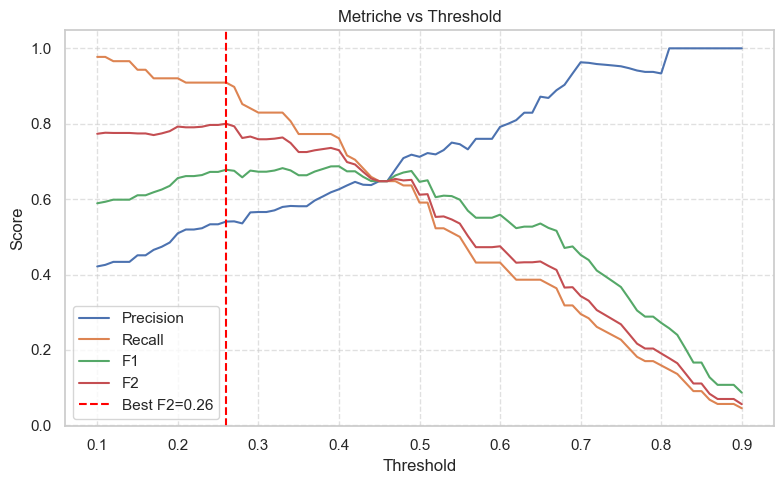

In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# === 1. Ottieni probabilità out-of-fold su tutto il dataset ===
all_proba = []
all_true = []

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestClassifier(class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]

    all_proba.extend(y_proba)
    all_true.extend(y_val)

all_true = np.array(all_true)
all_proba = np.array(all_proba)

# === 2. Scansione soglie ===
thresholds = np.linspace(0.1, 0.9, 81)  # da 0.1 a 0.9 con step 0.01
results = []

for t in thresholds:
    y_pred = (all_proba >= t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(all_true, y_pred, average="binary")
    f2 = (5*prec*rec) / (4*prec + rec + 1e-6)  # F2-score: recall più pesata
    youden = rec + (1 - (y_pred != all_true).sum()/len(all_true)) - 1
    results.append((t, prec, rec, f1, f2, youden))

df_thresh = pd.DataFrame(results, columns=["Threshold","Precision","Recall","F1","F2","YoudenJ"])

# === 3. Seleziona le soglie ottimali ===
best_f1 = df_thresh.loc[df_thresh["F1"].idxmax()]
best_f2 = df_thresh.loc[df_thresh["F2"].idxmax()]
best_youden = df_thresh.loc[df_thresh["YoudenJ"].idxmax()]

print("📊 Migliori soglie:")
print("F1-max      :", best_f1.to_dict())
print("F2-max      :", best_f2.to_dict())
print("Youden J-max:", best_youden.to_dict())

# === 4. Plot Precision/Recall vs Threshold ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_thresh["Threshold"], df_thresh["Precision"], label="Precision")
plt.plot(df_thresh["Threshold"], df_thresh["Recall"], label="Recall")
plt.plot(df_thresh["Threshold"], df_thresh["F1"], label="F1")
plt.plot(df_thresh["Threshold"], df_thresh["F2"], label="F2")
plt.axvline(best_f2["Threshold"], color="red", linestyle="--", label=f"Best F2={best_f2['Threshold']:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metriche vs Threshold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

🔎 Drop columns (presenti): []
✅ X_train shape: (219, 10) | X_test shape: (55, 10)

📈 AUC ROC: 0.743 | AUC PR: 0.724

=== Test — Threshold 0.50 ===
              precision    recall  f1-score   support

   No Triade      0.750     0.818     0.783        33
      Triade      0.684     0.591     0.634        22

    accuracy                          0.727        55
   macro avg      0.717     0.705     0.708        55
weighted avg      0.724     0.727     0.723        55

Confusion Matrix (TN FP / FN TP):
[[27  6]
 [ 9 13]]
Precision=0.684 | Recall=0.591 | Specificity=0.818 | F1=0.634 | F2=0.607 | YoudenJ=0.409

=== Test — Threshold 0.40 ===
              precision    recall  f1-score   support

   No Triade      0.788     0.788     0.788        33
      Triade      0.682     0.682     0.682        22

    accuracy                          0.745        55
   macro avg      0.735     0.735     0.735        55
weighted avg      0.745     0.745     0.745        55

Confusion Matrix (TN FP / 

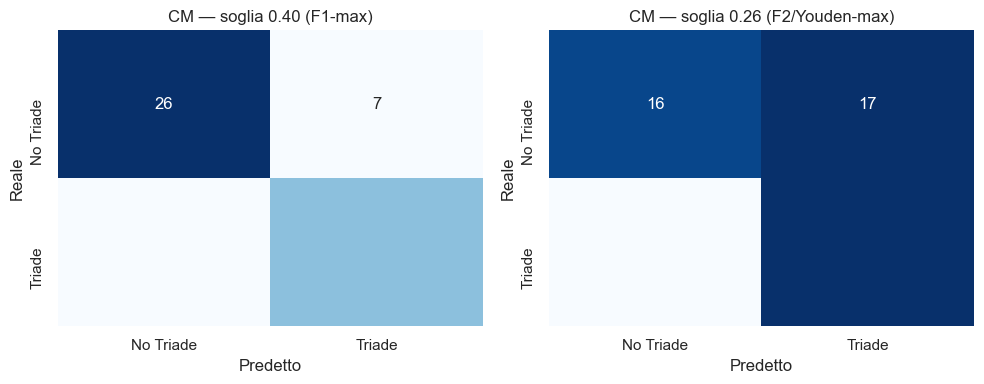

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# =============== 1) Carica train/test ===============
train = pd.read_csv("../data/processed/train_original.csv")
test  = pd.read_csv("../data/processed/test_original.csv")

# Colonne da escludere *se presenti* (qui non dovrebbero esserci)
maybe_leak = ["Constipation", "Hyposmia", "REM", "Depression"]
drop_cols_present = [c for c in maybe_leak if c in train.columns]

X_train = train.drop(columns=["target_bin"] + drop_cols_present, errors="ignore")
y_train = train["target_bin"].astype(int)

X_test  = test.drop(columns=["target_bin"] + drop_cols_present, errors="ignore")
y_test  = test["target_bin"].astype(int)

print(f"🔎 Drop columns (presenti): {drop_cols_present}")
print(f"✅ X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")

# =============== 2) Allena modello sul train ===============
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# =============== 3) Probabilità sul test ===============
y_proba = rf.predict_proba(X_test)[:, 1]

# =============== 4) Funzione valutazione a soglia ===============
def eval_at_threshold(y_true, y_score, thr: float):
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn) if tp + fn else 0.0
    spec = tn / (tn + fp) if tn + fp else 0.0
    prec = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    # F2 (recall-weighted)
    beta = 2
    f2 = (1+beta**2) * (prec * sens) / (beta**2 * prec + sens) if (prec + sens) else 0.0
    youden = sens + spec - 1
    return {
        "thr": thr,
        "precision": prec, "recall": sens, "specificity": spec,
        "f1": f1, "f2": f2, "youden": youden,
        "cm": cm,
        "report": classification_report(y_true, y_pred, digits=3, target_names=["No Triade","Triade"])
    }

# AUC/PR invarianti alla soglia
auc_roc = roc_auc_score(y_test, y_proba)
auc_pr  = average_precision_score(y_test, y_proba)

# =============== 5) Valuta tre soglie chiave ===============
results = {}
for thr in [0.50, 0.40, 0.26]:
    results[thr] = eval_at_threshold(y_test, y_proba, thr)

print(f"\n📈 AUC ROC: {auc_roc:.3f} | AUC PR: {auc_pr:.3f}\n")

for thr in [0.50, 0.40, 0.26]:
    r = results[thr]
    print(f"=== Test — Threshold {thr:.2f} ===")
    print(r["report"])
    print(f"Confusion Matrix (TN FP / FN TP):\n{r['cm']}")
    print(f"Precision={r['precision']:.3f} | Recall={r['recall']:.3f} | Specificity={r['specificity']:.3f} | "
          f"F1={r['f1']:.3f} | F2={r['f2']:.3f} | YoudenJ={r['youden']:.3f}\n")

# =============== 6) Confusion matrix 0.40 vs 0.26 ===============
def plot_cm(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["No Triade","Triade"], yticklabels=["No Triade","Triade"])
    ax.set_xlabel("Predetto"); ax.set_ylabel("Reale"); ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
plot_cm(results[0.40]["cm"], "CM — soglia 0.40 (F1-max)", axes[0])
plot_cm(results[0.26]["cm"], "CM — soglia 0.26 (F2/Youden-max)", axes[1])
plt.tight_layout(); plt.show()

In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

# === Probabilità predette e veri valori dal modello ===
# (assumo che tu abbia già y_test e y_proba definiti)
thresholds = [0.50, 0.40, 0.26]
results = []

def bootstrap_ci(metric_fn, y_true, y_score, thr, n_boot=1000, alpha=0.05):
    stats = []
    for _ in range(n_boot):
        idx = resample(range(len(y_true)), replace=True)
        y_true_bs = y_true.iloc[idx]
        y_pred_bs = (y_score.iloc[idx] >= thr).astype(int)
        stats.append(metric_fn(y_true_bs, y_pred_bs))
    return np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])

# Metriche derivate dalla confusion matrix
def get_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv  = tn / (tn + fn) if (tn + fn) > 0 else 0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0
    return prec, rec, spec, npv, f1

# Loop su soglie
y_true = y_test.reset_index(drop=True)
y_proba_series = pd.Series(y_proba)

for thr in thresholds:
    y_pred = (y_proba_series >= thr).astype(int)
    prec, rec, spec, npv, f1 = get_metrics(y_true, y_pred)

    # CI bootstrap per PPV/NPV
    ppv_ci = bootstrap_ci(lambda yt, yp: confusion_matrix(yt, yp).ravel()[3] / 
                                         max(1, (confusion_matrix(yt, yp).ravel()[3] + confusion_matrix(yt, yp).ravel()[1])),
                          y_true, y_proba_series, thr)
    npv_ci = bootstrap_ci(lambda yt, yp: confusion_matrix(yt, yp).ravel()[0] / 
                                         max(1, (confusion_matrix(yt, yp).ravel()[0] + confusion_matrix(yt, yp).ravel()[2])),
                          y_true, y_proba_series, thr)

    results.append({
        "Threshold": thr,
        "Precision (PPV)": f"{prec:.3f} [{ppv_ci[0]:.3f}, {ppv_ci[1]:.3f}]",
        "Recall (Sens)": f"{rec:.3f}",
        "Specificity": f"{spec:.3f}",
        "NPV": f"{npv:.3f} [{npv_ci[0]:.3f}, {npv_ci[1]:.3f}]",
        "F1": f"{f1:.3f}"
    })

# Tabella finale
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Threshold      Precision (PPV) Recall (Sens) Specificity                  NPV    F1
      0.50 0.684 [0.462, 0.882]         0.591       0.818 0.750 [0.605, 0.879] 0.634
      0.40 0.682 [0.474, 0.895]         0.682       0.788 0.788 [0.636, 0.921] 0.682
      0.26 0.500 [0.333, 0.667]         0.773       0.485 0.762 [0.571, 0.938] 0.607


🔎 Riassunto probabilità (soggetto idx = 0 )
Feature  Value_-1SD  Prob_-1SD  Value_center  Prob_center  Value_+1SD  Prob_+1SD  Delta(+1SD - center)  Delta(-1SD - center)
 MSE AP       1.602       0.80         1.799         0.74       1.958       0.69                 -0.05                  0.06
 MSE ML       1.597       0.67         1.897         0.74       2.197       0.78                  0.04                 -0.07
  MSE V       1.348       0.78         1.527         0.74       1.706       0.78                  0.04                  0.04
 Weigth      52.000       0.73        78.000         0.74     123.272       0.64                 -0.10                 -0.01
  iHR V      53.153       0.55        65.130         0.74      77.107       0.80                  0.06                 -0.19


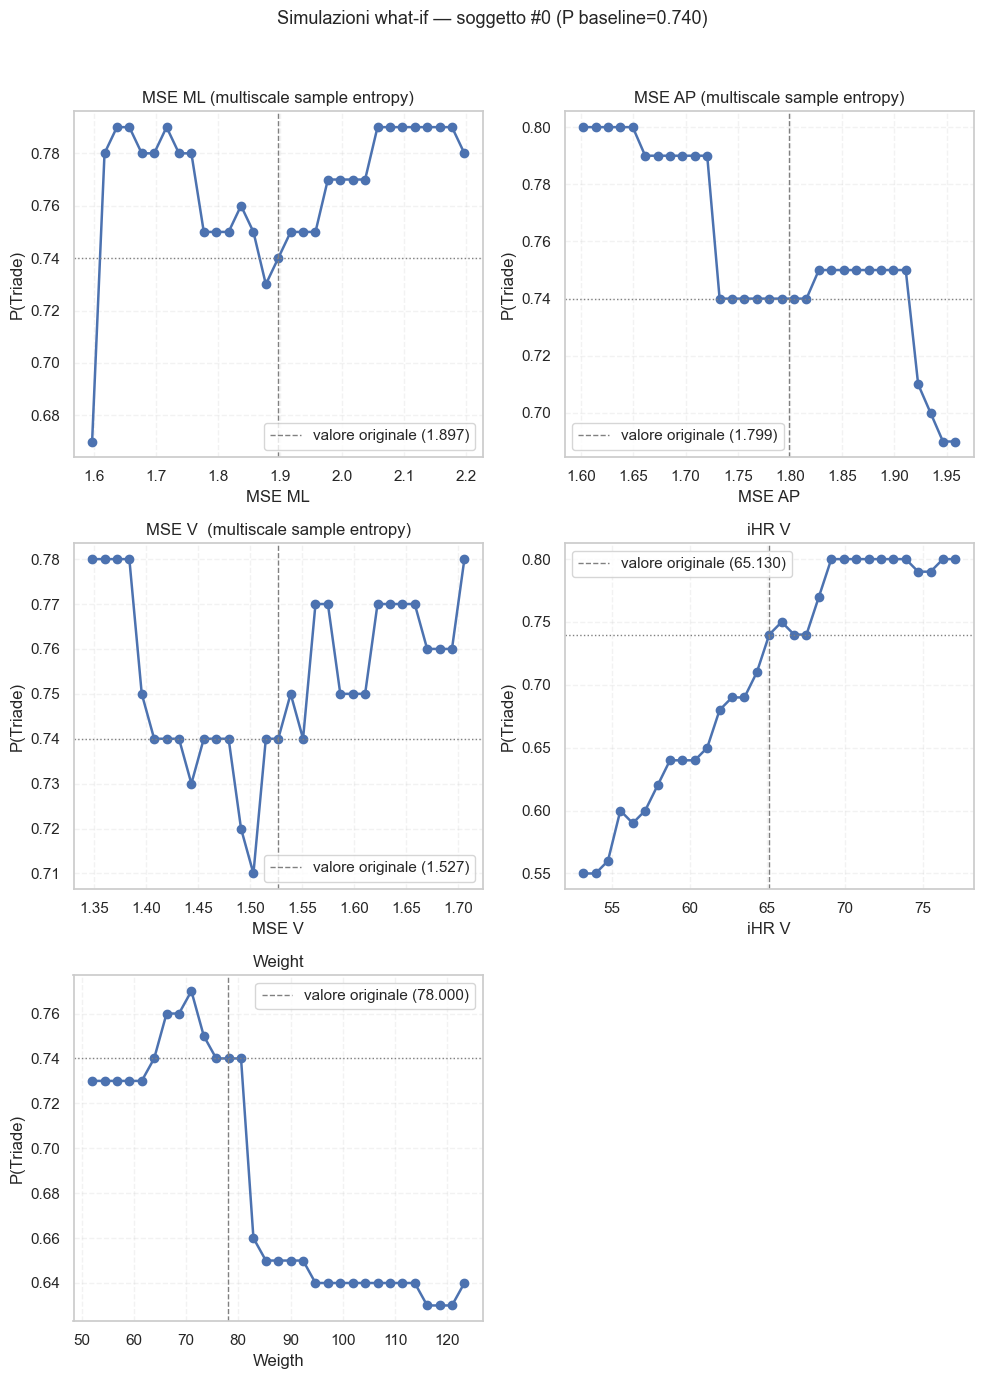

✅ Salvati:
 - figura: ../figures/whatif_core_features_subject0.png
 - tabella: ../figures/whatif_core_features_subject0.csv


In [ ]:
# ============================================
# Simulazioni "what-if" su tutte le core features
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# --- Parametri ---
DATA_PATH = "../data/processed/train_original.csv"   # oppure: ../data/processed/train_balanced_ctgan.csv
OUT_DIR   = "../figurez/case"
IDX_SUBJECT = 0                 # <-- cambia il soggetto da simulare
N_POINTS = 31                   # punti lungo la curva per ciascuna feature
SD_RANGE = 1.0                  # intervallo di simulazione: ± SD (tagliato a min/max osservati)

# --- Core features e (eventuali) etichette più pulite ---
core_features = ["MSE ML", "MSE AP", "MSE V", "iHR V", "Weigth"]
pretty = {
    "MSE ML": "MSE ML (multiscale sample entropy)",
    "MSE AP": "MSE AP (multiscale sample entropy)",
    "MSE V" : "MSE V  (multiscale sample entropy)",
    "iHR V" : "iHR V",
    "Weigth": "Weight"
}

# --- Carica dati e prepara X, y ---
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
if "target_bin" not in df.columns:
    raise ValueError("Colonna 'target_bin' mancante nel dataset.")

# (Opzionale) se nel file ci fossero ancora variabili non desiderate
drop_cols = [c for c in ["Constipation","Hyposmia","REM","Depression"] if c in df.columns]

X = df.drop(columns=["target_bin"] + drop_cols, errors="ignore")
y = df["target_bin"].astype(int)

# --- Safety: core_features devono esistere in X ---
missing = [f for f in core_features if f not in X.columns]
if missing:
    raise ValueError(f"Mancano nel dataset le feature: {missing}")

# --- Train/test split (solo per addestrare il modello) ---
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# --- Modello (stesso setup usato finora) ---
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# --- Seleziona soggetto da simulare (dal FULL X per avere tutte le colonne) ---
if IDX_SUBJECT >= len(X):
    raise IndexError(f"IDX_SUBJECT={IDX_SUBJECT} fuori range (n={len(X)}).")
subject = X.iloc[IDX_SUBJECT].copy()

# Probabilità baseline
p_base = float(model.predict_proba([subject])[0][1])

# --- Intervalli di simulazione per ogni feature: ±1 SD, troncati a min/max osservati ---
ranges = {}
stats = {}
for f in core_features:
    mu = X[f].mean()
    sd = X[f].std(ddof=0)
    lo, hi = X[f].min(), X[f].max()

    # Centro l’intervallo su "valore del soggetto" e uso ±SD (tagliato a min/max osservati)
    center = subject[f]
    f_min = max(lo, center - SD_RANGE*sd)
    f_max = min(hi, center + SD_RANGE*sd)

    # In casi di sd=0 o intervallo piatto, allarga un filo all’interno di [lo,hi]
    if f_min == f_max:
        f_min, f_max = max(lo, center - 1e-3), min(hi, center + 1e-3)

    ranges[f] = np.linspace(f_min, f_max, N_POINTS)
    stats[f]  = {"mean": mu, "sd": sd, "min": lo, "max": hi, "center": center}

# --- Funzione: calcola le proba al variare di una sola feature (tutto il resto fisso) ---
def simulate_curve(feature_name, grid_values):
    probs = []
    for val in grid_values:
        x_mod = subject.copy()
        x_mod[feature_name] = val
        probs.append(model.predict_proba([x_mod])[0][1])
    return np.array(probs)

# --- Simula e colleziona risultati ---
all_curves = {}
summary_rows = []

for f in core_features:
    grid = ranges[f]
    probs = simulate_curve(f, grid)
    all_curves[f] = (grid, probs)

    # Prob a -1SD, baseline (valore originale), +1SD (tutti tagliati a min/max)
    sd = stats[f]["sd"]
    v_center = stats[f]["center"]
    v_lo = np.clip(v_center - SD_RANGE*sd, stats[f]["min"], stats[f]["max"])
    v_hi = np.clip(v_center + SD_RANGE*sd, stats[f]["min"], stats[f]["max"])

    def prob_at(value):
        x_mod = subject.copy()
        x_mod[f] = value
        return float(model.predict_proba([x_mod])[0][1])

    p_lo = prob_at(v_lo)
    p_hi = prob_at(v_hi)

    summary_rows.append({
        "Feature": f,
        "Value_-1SD": round(v_lo, 3),
        "Prob_-1SD": round(p_lo, 3),
        "Value_center": round(v_center, 3),
        "Prob_center": round(p_base, 3),
        "Value_+1SD": round(v_hi, 3),
        "Prob_+1SD": round(p_hi, 3),
        "Delta(+1SD - center)": round(p_hi - p_base, 3),
        "Delta(-1SD - center)": round(p_lo - p_base, 3),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("Feature")
print("🔎 Riassunto probabilità (soggetto idx =", IDX_SUBJECT, ")")
print(summary_df.to_string(index=False))

# --- Plot multi-pannello ---
n = len(core_features)
ncols = 2
nrows = int(np.ceil(n / ncols))
plt.figure(figsize=(10, 4.5*nrows))

for i, f in enumerate(core_features, 1):
    grid, probs = all_curves[f]
    center = stats[f]["center"]

    ax = plt.subplot(nrows, ncols, i)
    ax.plot(grid, probs, marker='o', lw=1.8)
    ax.axvline(center, color='gray', ls='--', lw=1, label=f"valore originale ({center:.3f})")
    ax.axhline(p_base, color='gray', ls=':', lw=1)

    ax.set_title(pretty.get(f, f))
    ax.set_xlabel(f)
    ax.set_ylabel("P(Triade)")
    ax.grid(True, ls='--', alpha=0.25)
    ax.legend(loc="best")

plt.suptitle(f"Simulazioni what-if — soggetto #{IDX_SUBJECT} (P baseline={p_base:.3f})", y=1.02, fontsize=13)
plt.tight_layout()
os.makedirs(OUT_DIR, exist_ok=True)
plt.savefig(os.path.join(OUT_DIR, f"whatif_core_features_subject{IDX_SUBJECT}.png"), dpi=300, bbox_inches="tight")
plt.show()

# --- Salva tabella riassuntiva ---
out_csv = os.path.join(OUT_DIR, f"whatif_core_features_subject{IDX_SUBJECT}.csv")
summary_df.to_csv(out_csv, index=False)
print(f"✅ Salvati:\n - figura: {OUT_DIR}/whatif_core_features_subject{IDX_SUBJECT}.png\n - tabella: {out_csv}")

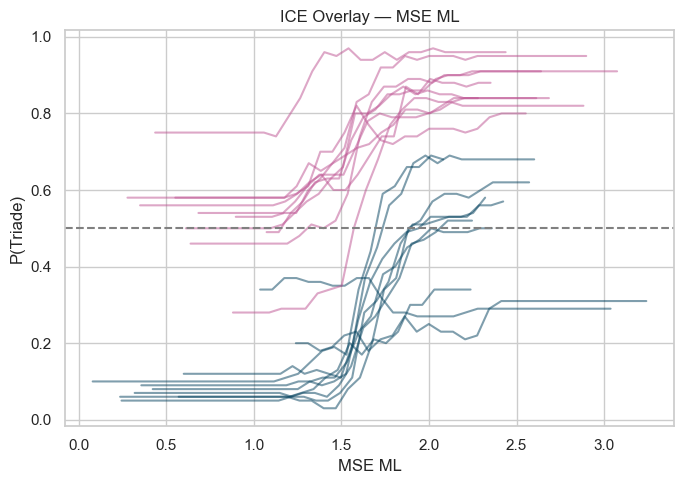

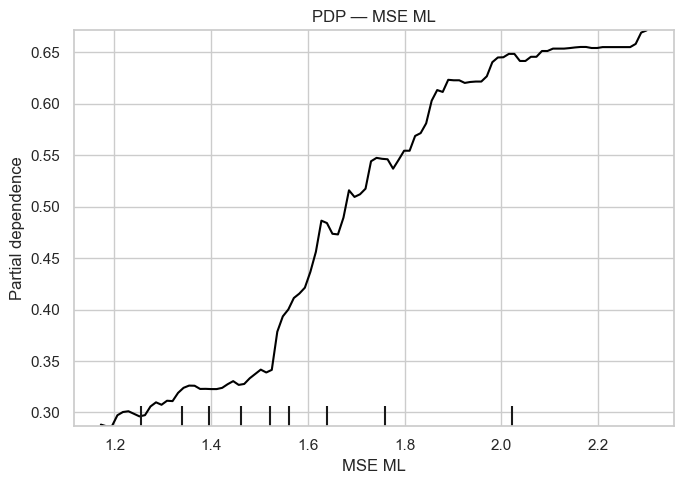

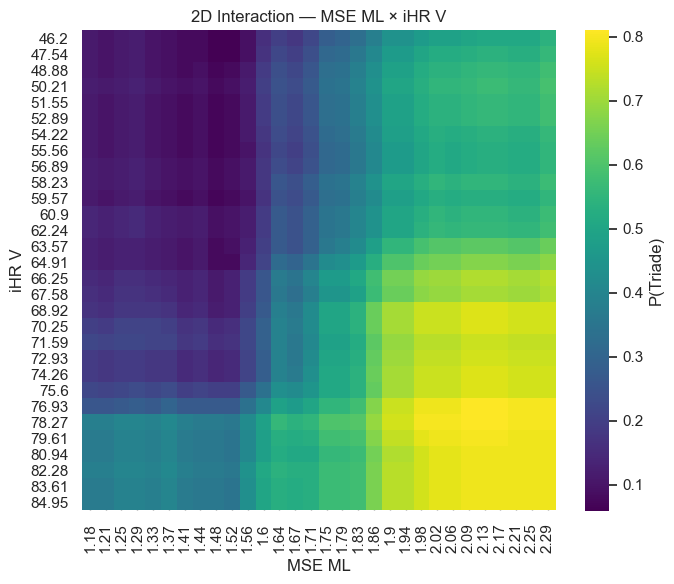

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

# === 1. Ricarica train (real-only) ===
df = pd.read_csv("../data/processed/train_original.csv")

X = df.drop(columns=["target_bin"])
y = df["target_bin"]

# Modello (già ottimizzato sul real-only)
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X, y)

# === 2. ICE overlay: scegli 10 triade + 10 non-triade ===
n_per_group = 10
triade_idx = df[df["target_bin"]==1].sample(n_per_group, random_state=42).index
notriade_idx = df[df["target_bin"]==0].sample(n_per_group, random_state=42).index
idxs = triade_idx.union(notriade_idx)

feature_to_test = "MSE ML"
range_delta = np.linspace(-1, 1, 30)  # ±1 unità attorno al valore reale

plt.figure(figsize=(7,5))
for idx in idxs:
    subj = X.iloc[idx].copy()
    probs = []
    for d in range_delta:
        modified = subj.copy()
        modified[feature_to_test] += d
        probs.append(rf.predict_proba([modified])[0][1])
    plt.plot(subj[feature_to_test]+range_delta, probs, alpha=0.5,
             color="#bc5090" if y.iloc[idx]==1 else "#003f5c")

plt.axhline(0.5, color="gray", linestyle="--")
plt.title(f"ICE Overlay — {feature_to_test}")
plt.xlabel(feature_to_test)
plt.ylabel("P(Triade)")
plt.tight_layout()
plt.show()

# === 3. PDP/ALE globali ===
fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    rf, X, [feature_to_test], kind="average", ax=ax,
    line_kw={"color":"black"}
)
plt.title(f"PDP — {feature_to_test}")
plt.tight_layout()
plt.show()

# === 4. Heatmap 2D (interazione) ===
feat_x, feat_y = "MSE ML", "iHR V"
grid_x = np.linspace(X[feat_x].quantile(0.05), X[feat_x].quantile(0.95), 30)
grid_y = np.linspace(X[feat_y].quantile(0.05), X[feat_y].quantile(0.95), 30)

mesh = np.array([[rf.predict_proba([[gx if f==feat_x else gy if f==feat_y else X[f].mean() 
                                      for f in X.columns]])[0,1] 
                  for gx in grid_x] for gy in grid_y])

plt.figure(figsize=(7,6))
sns.heatmap(mesh, xticklabels=np.round(grid_x,2), yticklabels=np.round(grid_y,2),
            cmap="viridis", cbar_kws={'label': 'P(Triade)'})
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.title(f"2D Interaction — {feat_x} × {feat_y}")
plt.tight_layout()
plt.show()

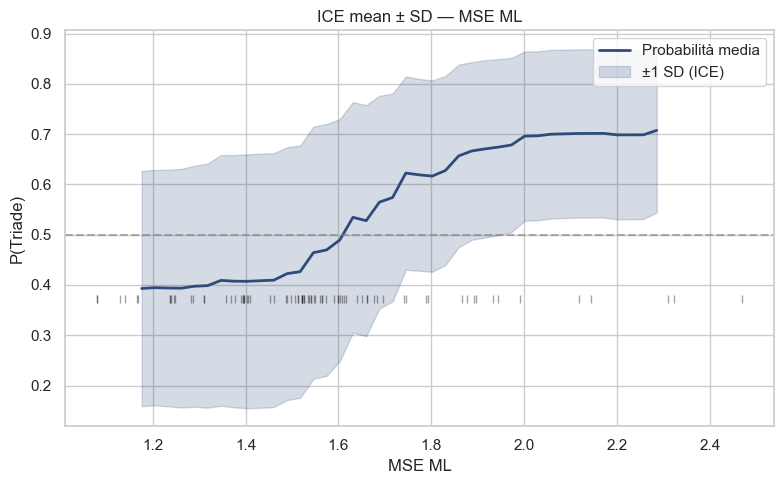

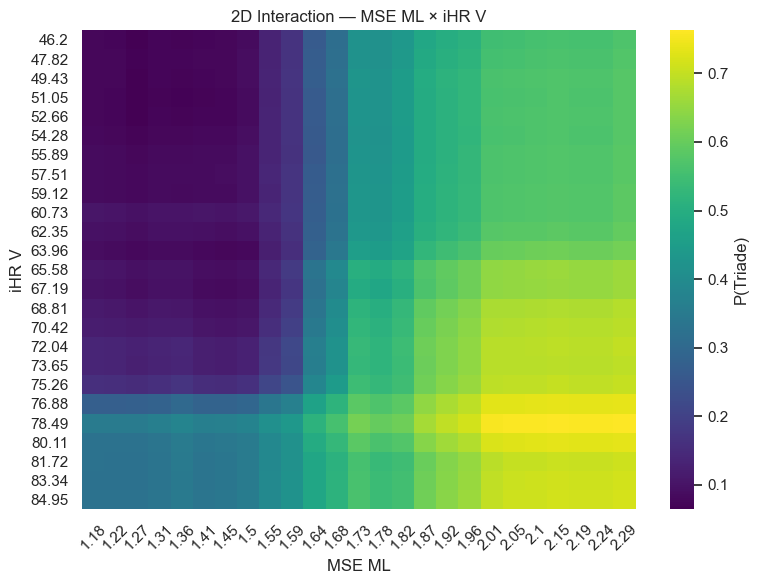

✅ Grafici salvati in ../figures/:
 - ice_mean_sd_corefeature.png
 - interaction_heatmap_MSEML_iHRV.png


In [ ]:
# === What-if / ICE / PDP sulle core features attuali ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

sns.set(style="whitegrid")

# -------------------------------
# 1) Carica train e definisci colonne
# -------------------------------
df = pd.read_csv("../data/processed/train_original.csv")
df.columns = df.columns.str.strip()

core = ["MSE ML", "iHR V", "MSE V", "MSE AP", "Weigth"]
covs = ["Age", "Sex (M=1, F=2)", "H-Y", "Gait Speed", "Duration (years)"]
all_feats = core + covs

missing = [c for c in all_feats + ["target_bin"] if c not in df.columns]
if missing:
    raise ValueError(f"Colonne mancanti nel train: {missing}")

X = df[all_feats].copy()
y = df["target_bin"].astype(int)

# -------------------------------
# 2) Modello di riferimento (RF bilanciato)
# -------------------------------
rf = RandomForestClassifier(
    n_estimators=500, max_depth=None, min_samples_leaf=2,
    class_weight="balanced", random_state=42
)
rf.fit(X, y)

# -------------------------------
# 3) Helper: griglie, ICE e media ± SD
# -------------------------------
def make_grid(series, q_low=0.05, q_high=0.95, n=40):
    lo, hi = series.quantile(q_low), series.quantile(q_high)
    return np.linspace(lo, hi, n)

def ice_mean_std(model, X_ref, feature, grid):
    """
    X_ref: DataFrame di soggetti su cui calcolare le ICE (poche decine bastano)
    feature: colonna da variare
    grid: valori da provare per 'feature'
    """
    curves = []
    x_other = X_ref.copy()
    for val in grid:
        tmp = x_other.copy()
        tmp[feature] = val
        p = model.predict_proba(tmp)[:, 1]
        curves.append(p)
    curves = np.vstack(curves)           # shape (len(grid), n_subjects)
    mean = curves.mean(axis=1)
    std  = curves.std(axis=1)
    return mean, std

# Sottoinsieme per ICE (20+20 soggetti, riproducibile)
sub_pos = df[df["target_bin"] == 1].sample(min(20, (y==1).sum()), random_state=42)
sub_neg = df[df["target_bin"] == 0].sample(min(20, (y==0).sum()), random_state=42)
X_ice   = pd.concat([sub_pos[all_feats], sub_neg[all_feats]], ignore_index=True)

# -------------------------------
# 4) ICE mean±SD su UNA feature (cambia qui 'feat_to_vary')
# -------------------------------
feat_to_vary = "MSE ML"  # <-- puoi mettere "iHR V", "MSE AP", "MSE V", "Weigth"
grid = make_grid(X[feat_to_vary], 0.05, 0.95, n=40)
mean_curve, sd_curve = ice_mean_std(rf, X_ice, feat_to_vary, grid)

plt.figure(figsize=(8,5))
plt.plot(grid, mean_curve, color="#2f4b7c", lw=2, label="Probabilità media")
plt.fill_between(grid, mean_curve - sd_curve, mean_curve + sd_curve,
                 color="#2f4b7c", alpha=0.20, label="±1 SD (ICE)")
# rug dei valori osservati
rug_vals = X[feat_to_vary].sample(min(80, len(X)), random_state=1).values
plt.plot(rug_vals, np.full_like(rug_vals, mean_curve.min()-0.02), "|", color="k", alpha=0.4)
plt.axhline(0.5, ls="--", c="gray", alpha=0.6)
plt.xlabel(feat_to_vary); plt.ylabel("P(Triade)")
plt.title(f"ICE mean ± SD — {feat_to_vary}")
plt.legend()
plt.tight_layout()
os.makedirs("../figurez/global", exist_ok=True)
plt.savefig("../figurez/global/ice_mean_sd_corefeature.png", dpi=300)
plt.show()

# -------------------------------
# 5) Heatmap 2D di interazione (coppia chiave MSE ML × iHR V)
#    -> cambia 'fx','fy' per altre coppie (es. 'MSE ML' × 'Weigth')
# -------------------------------
fx, fy = "MSE ML", "iHR V"
gx = make_grid(X[fx], 0.05, 0.95, n=25)
gy = make_grid(X[fy], 0.05, 0.95, n=25)

# Fissiamo le altre feature ai loro valori MEDIANI (profilo "clinicamente neutro")
x_base = X.median(numeric_only=True)
grid_probs = np.zeros((len(gy), len(gx)))

for i, yval in enumerate(gy):
    for j, xval in enumerate(gx):
        row = x_base.copy()
        row[fx] = xval
        row[fy] = yval
        # ricostruisci DataFrame 1×p rispettando l'ordine delle colonne
        row_df = pd.DataFrame([row[all_feats].values], columns=all_feats)
        grid_probs[i, j] = rf.predict_proba(row_df)[:, 1][0]

plt.figure(figsize=(8,6))
sns.heatmap(grid_probs, cmap="viridis",
            xticklabels=np.round(gx, 2), yticklabels=np.round(gy, 2),
            cbar_kws={"label":"P(Triade)"})
plt.xlabel(fx); plt.ylabel(fy)
plt.title(f"2D Interaction — {fx} × {fy}")
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../figurez/global/interaction_heatmap_MSEML_iHRV.png", dpi=300)
plt.show()

print("✅ Grafici salvati in ../figurez/global:")
print(" - ice_mean_sd_corefeature.png")
print(" - interaction_heatmap_MSEML_iHRV.png")

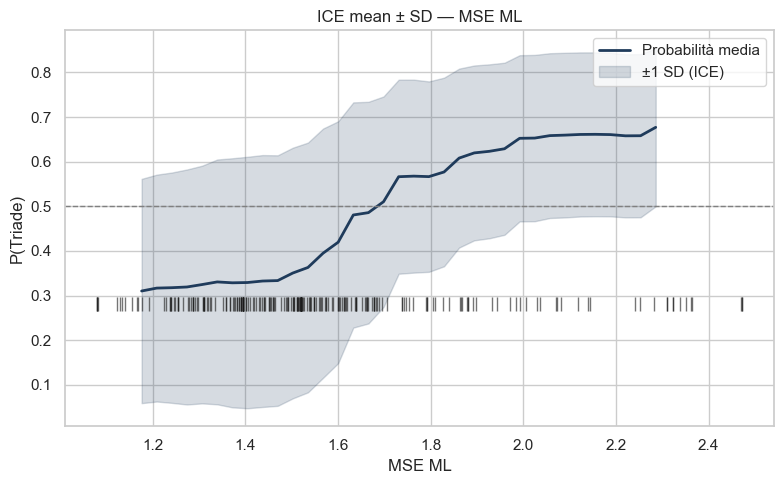

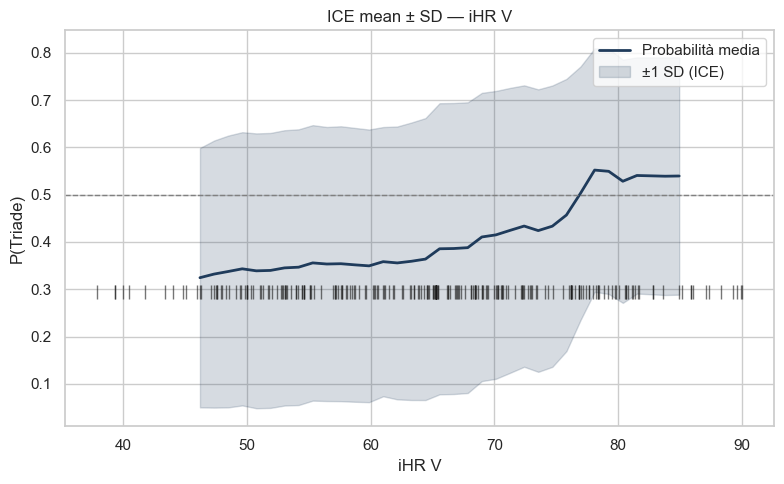

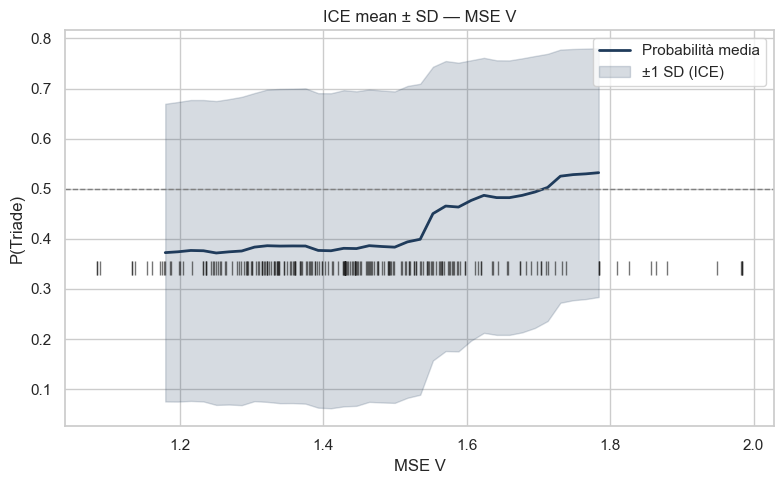

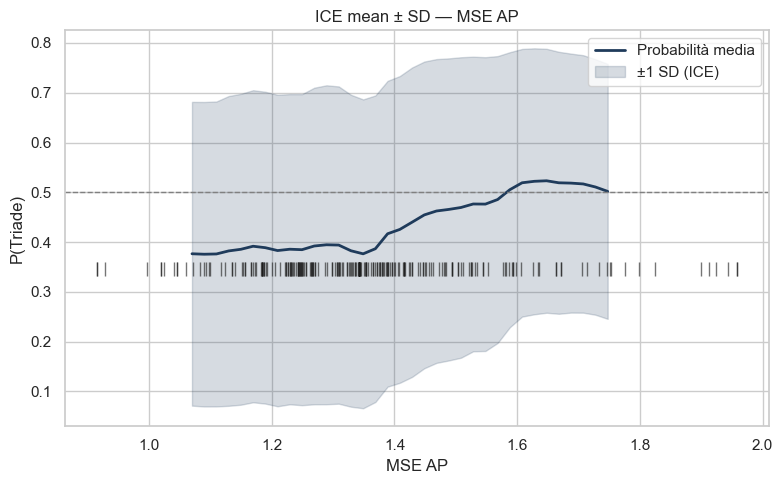

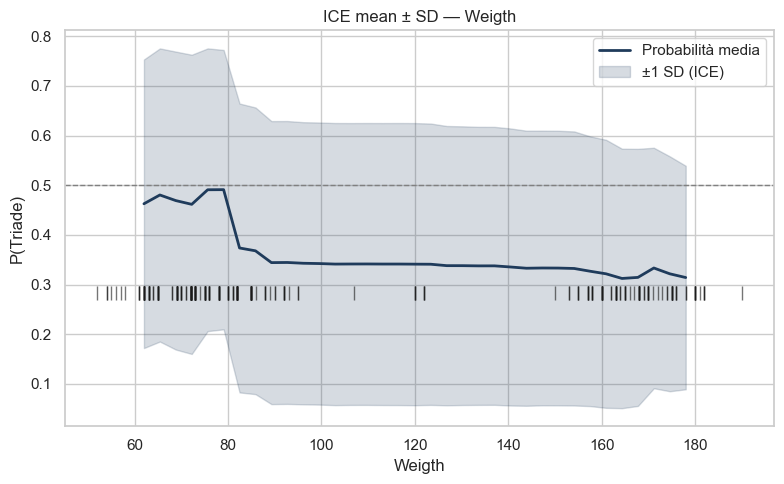

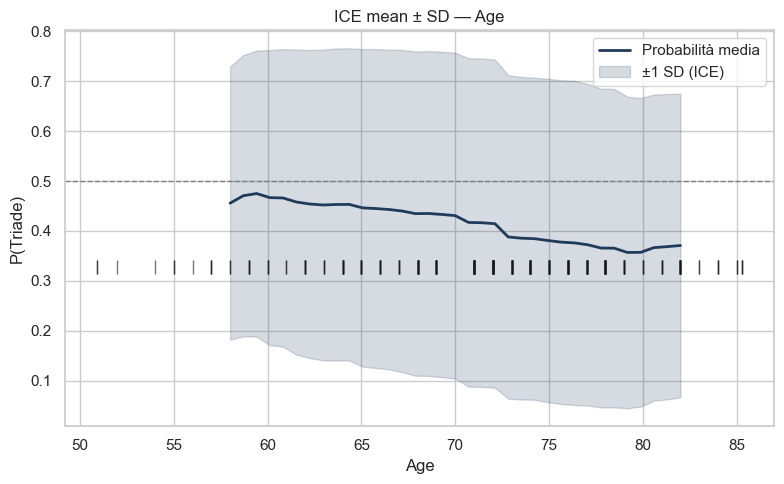

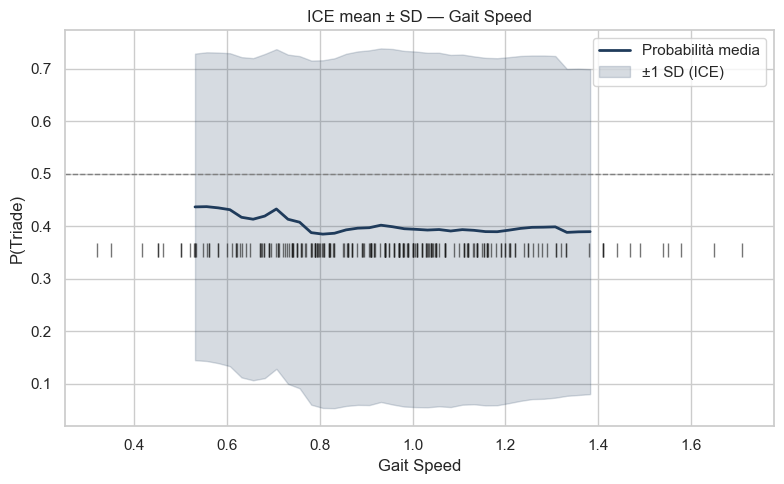

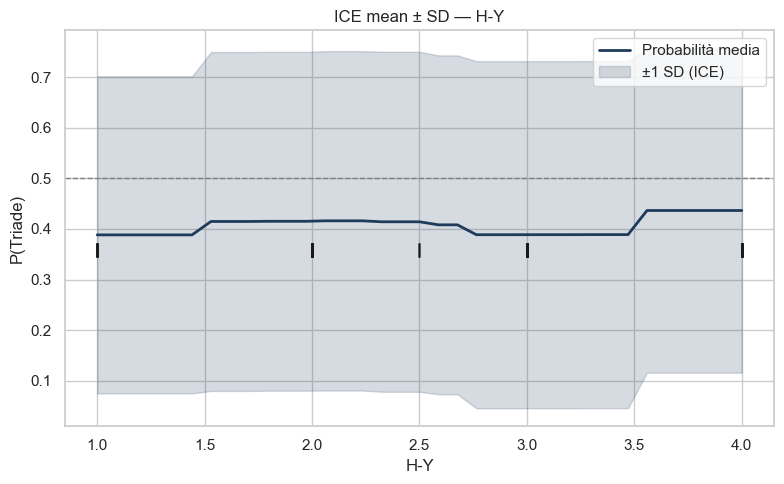

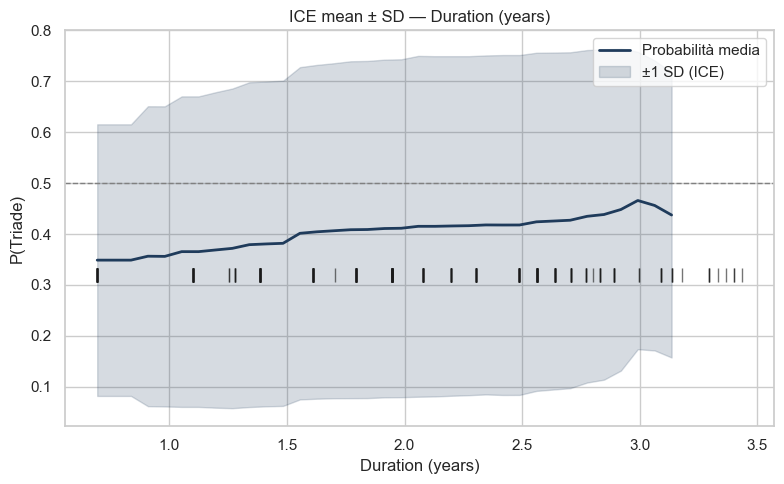

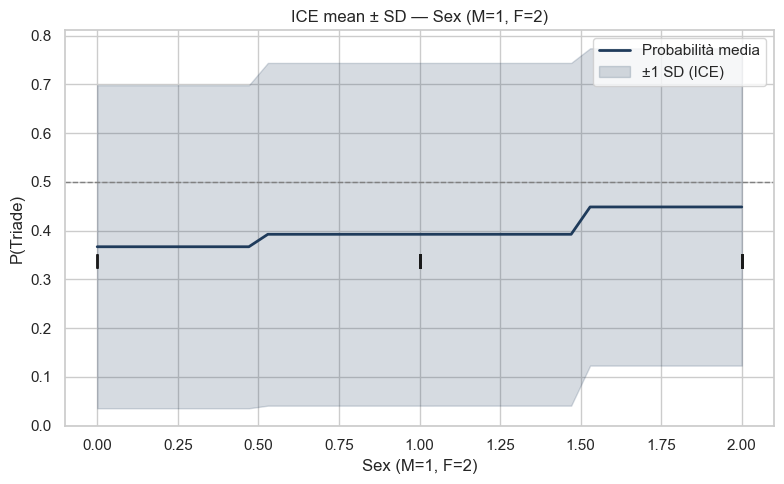

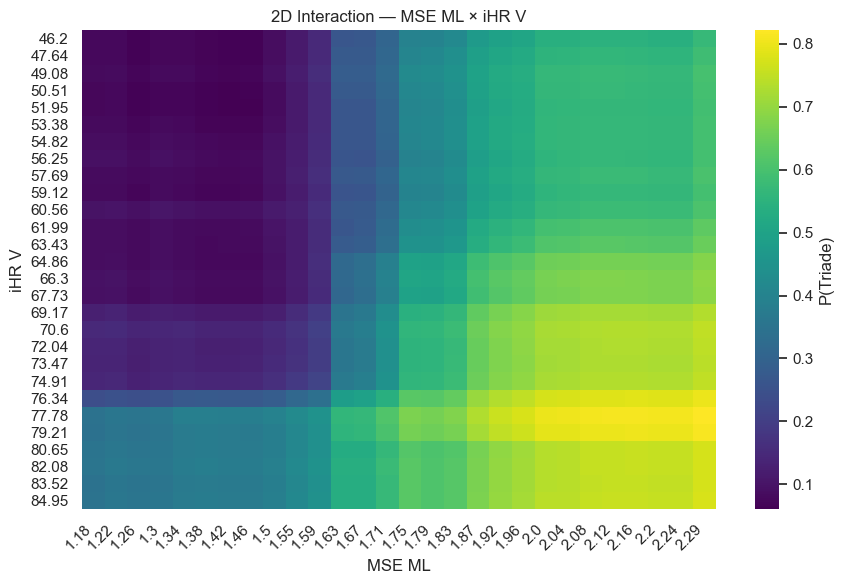

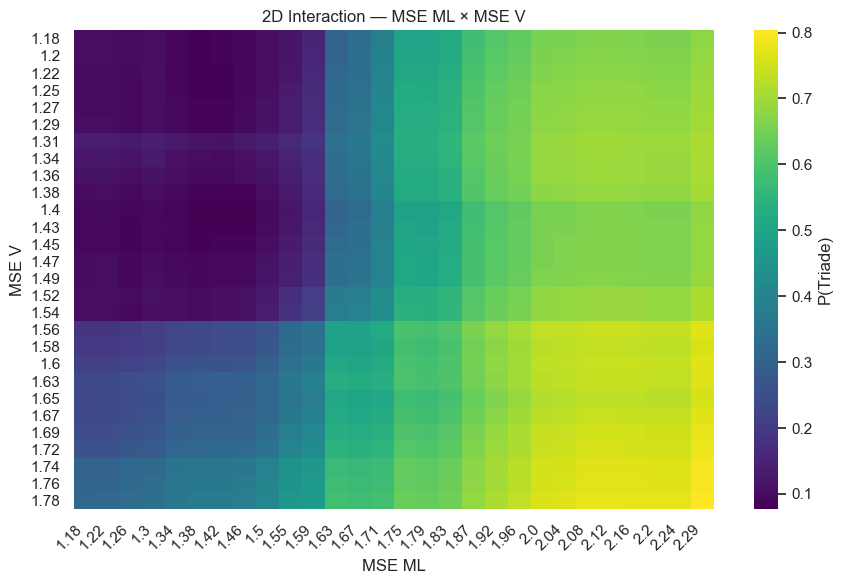

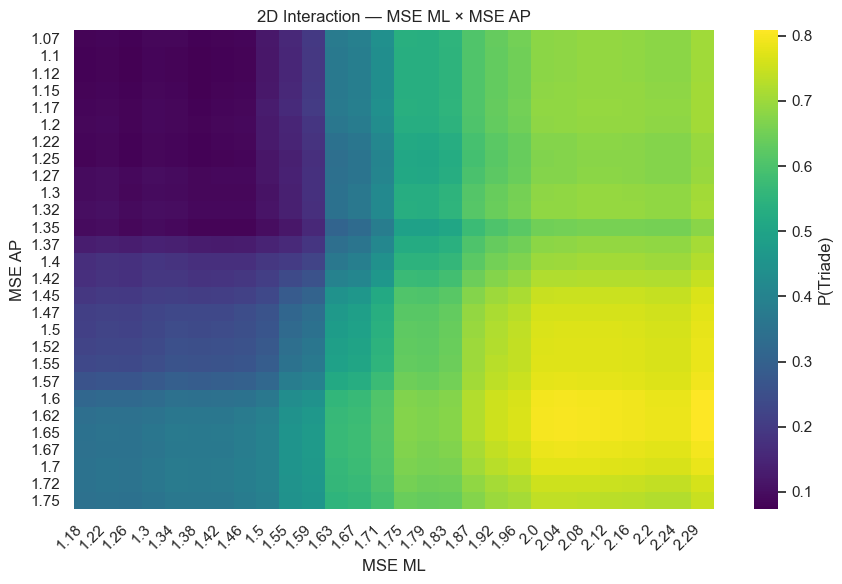

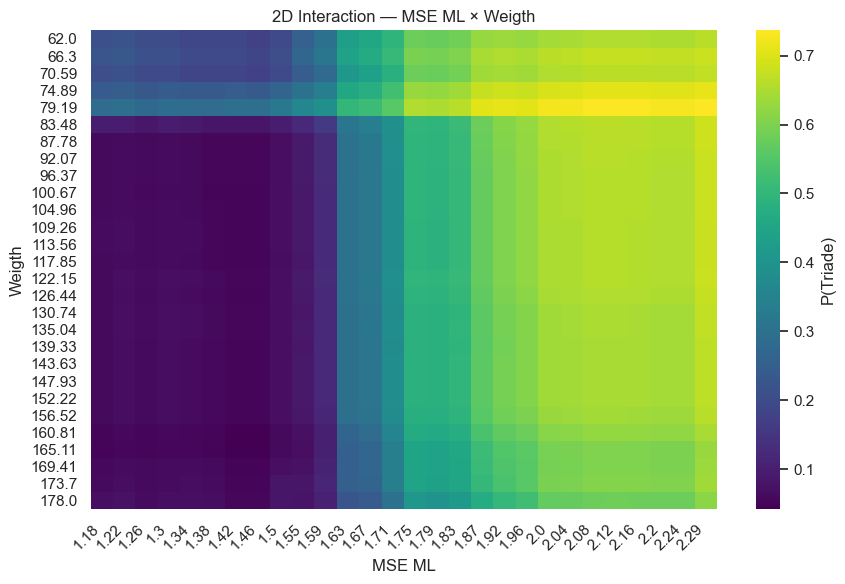

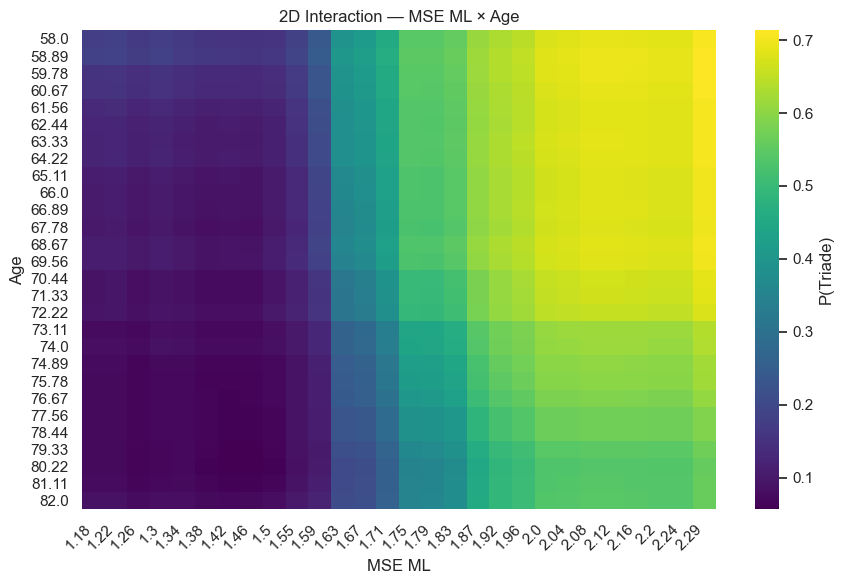

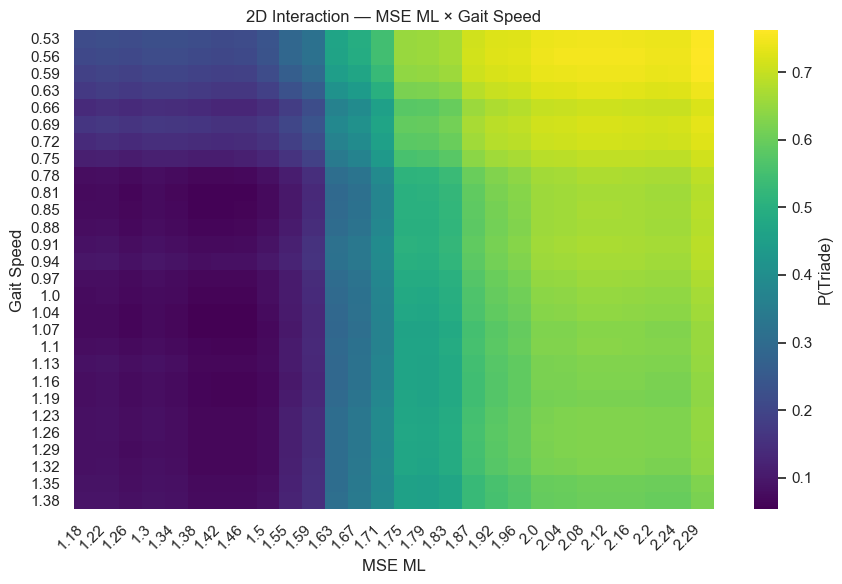

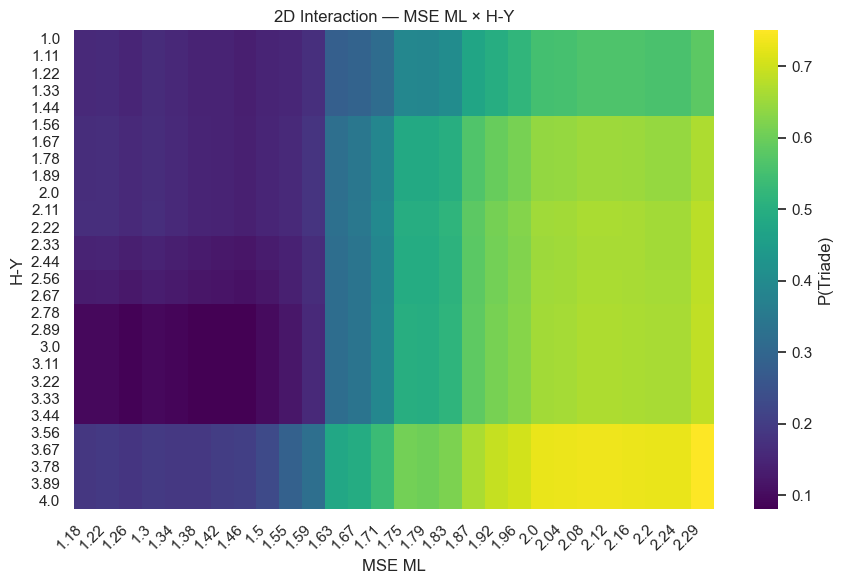

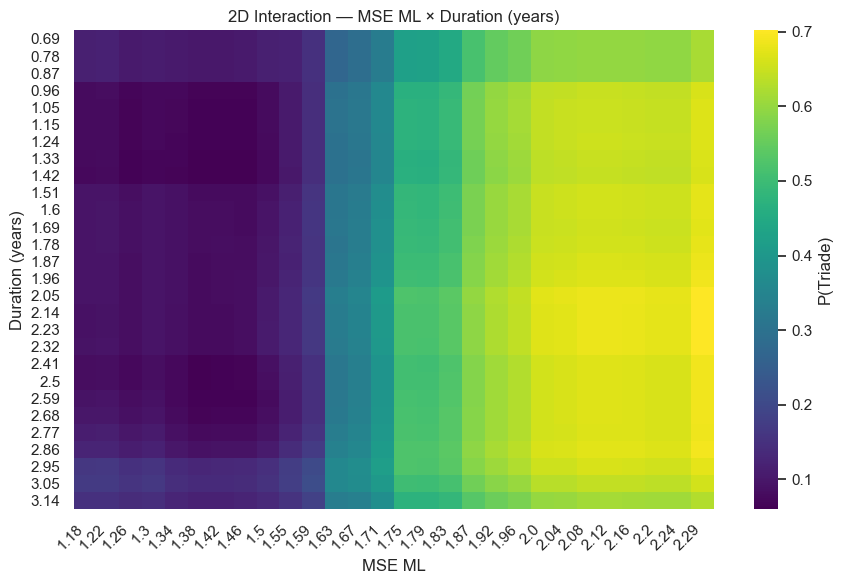

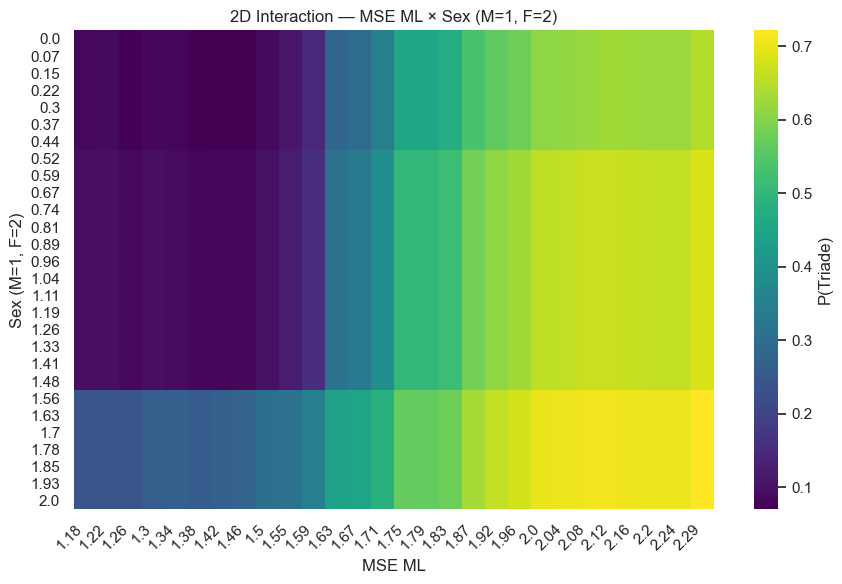

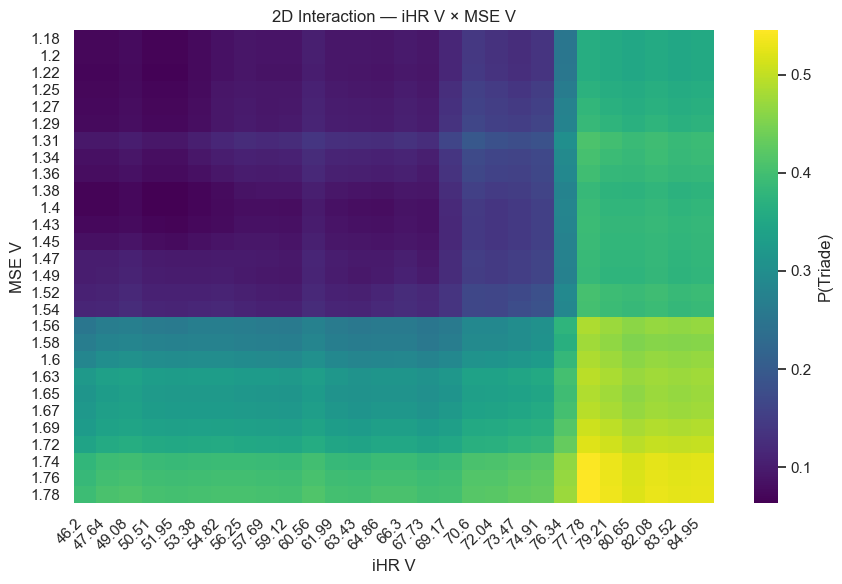

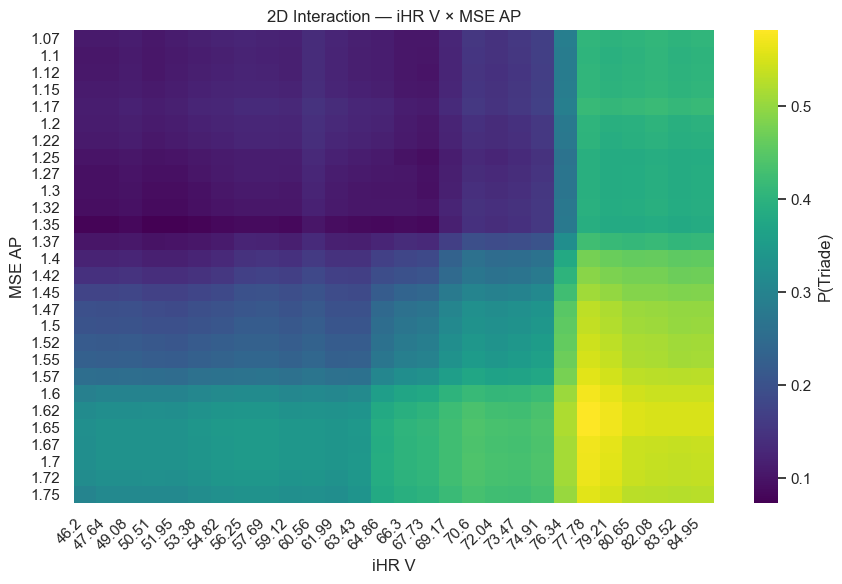

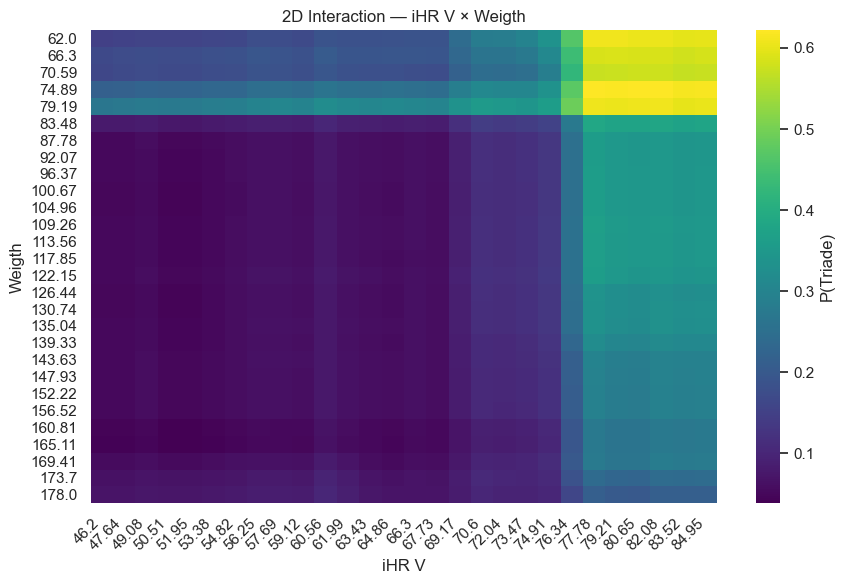

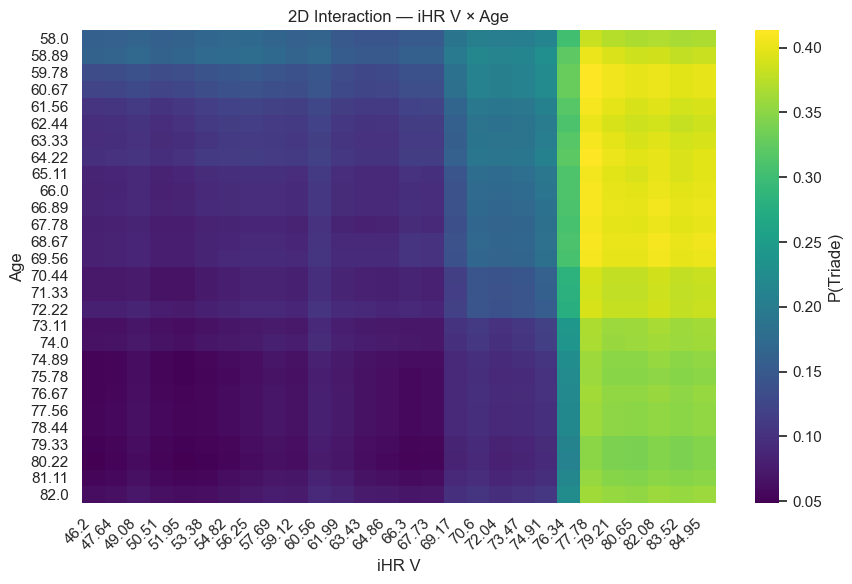

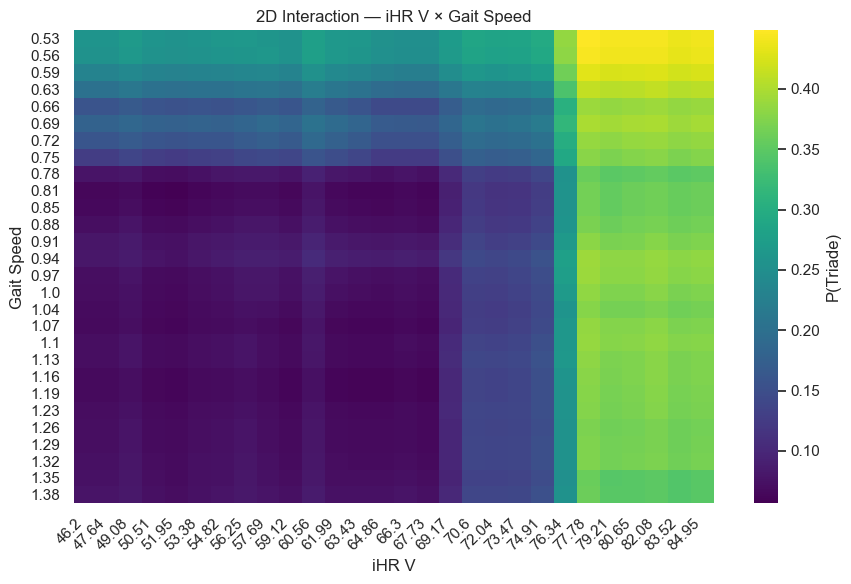

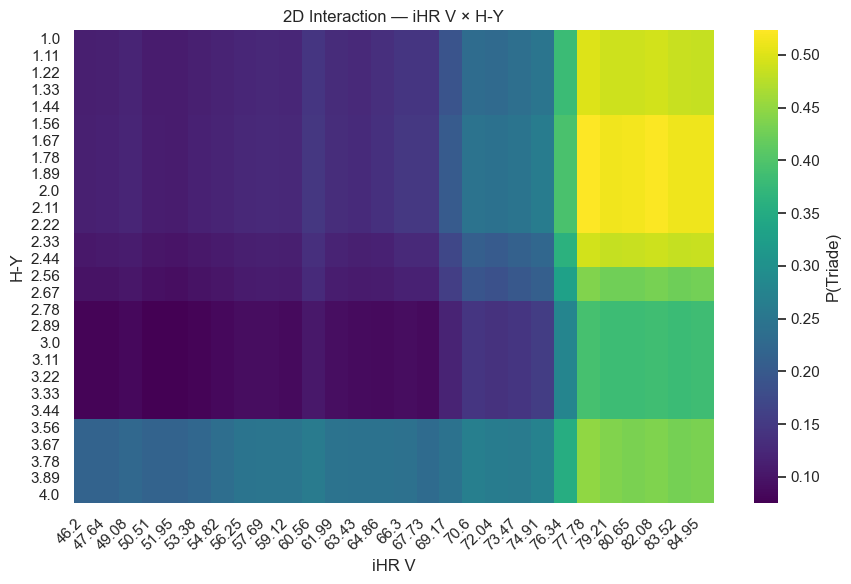

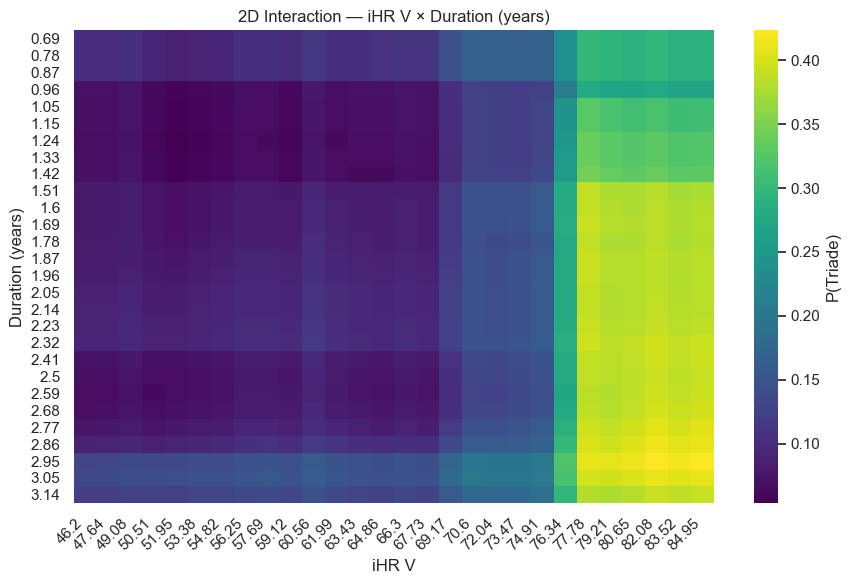

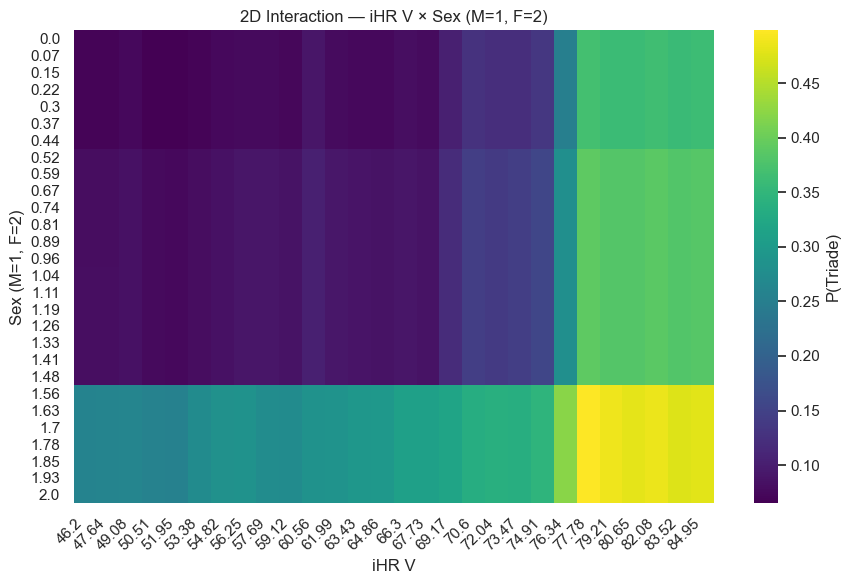

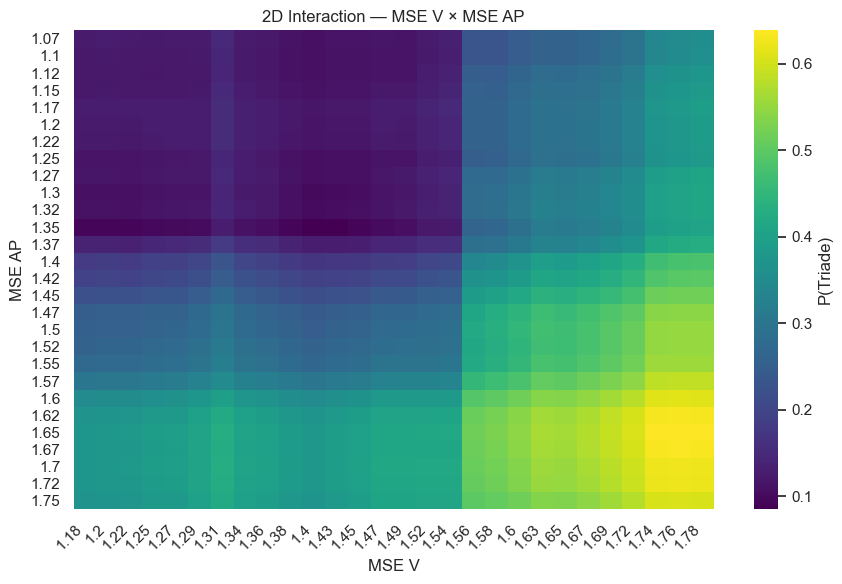

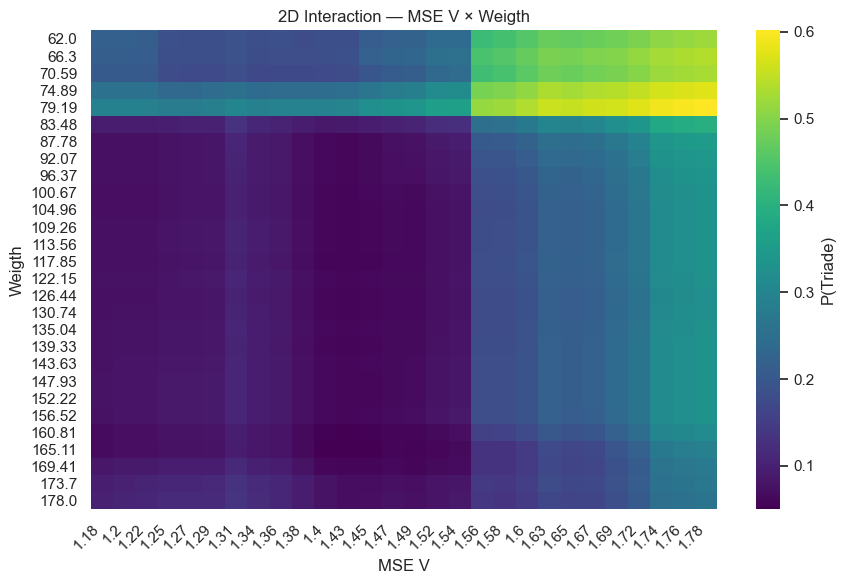

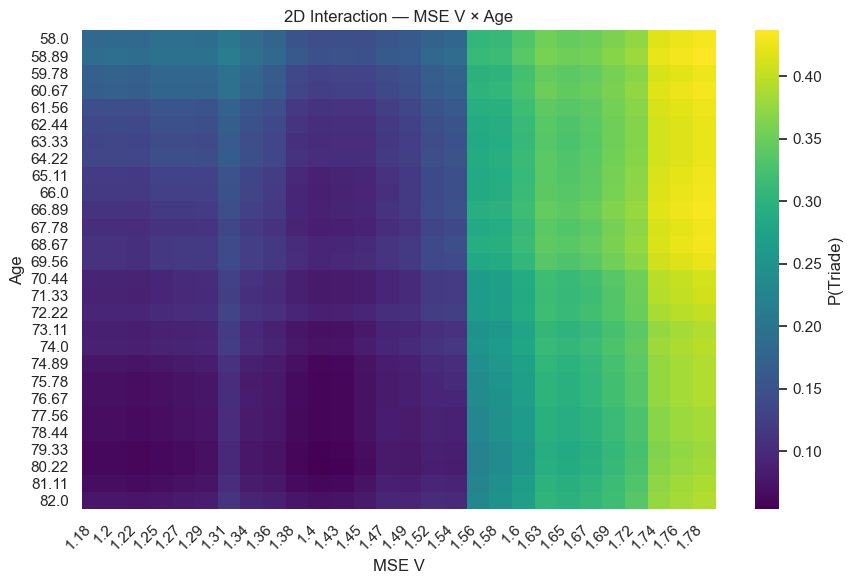

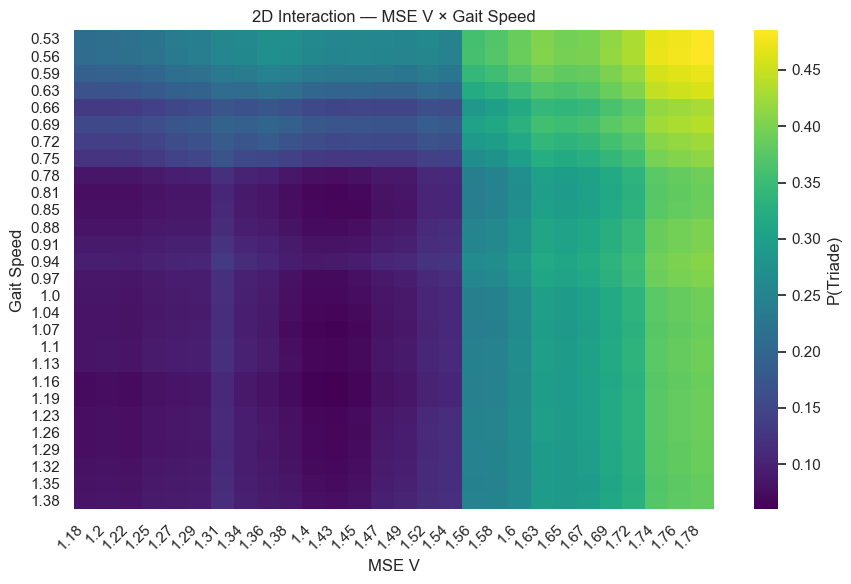

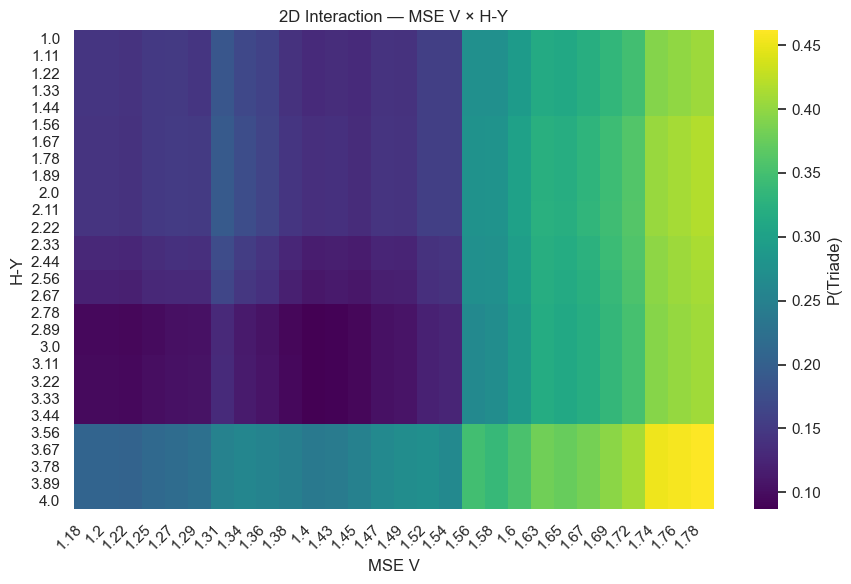

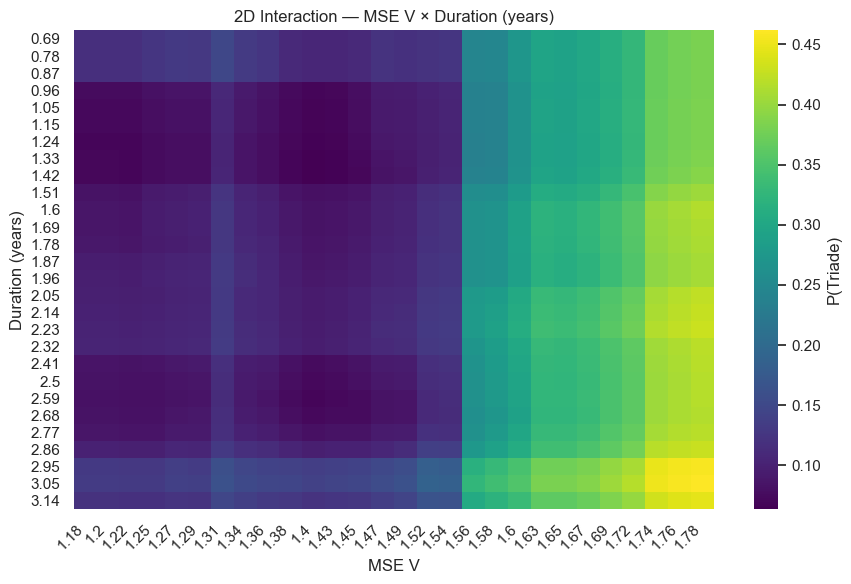

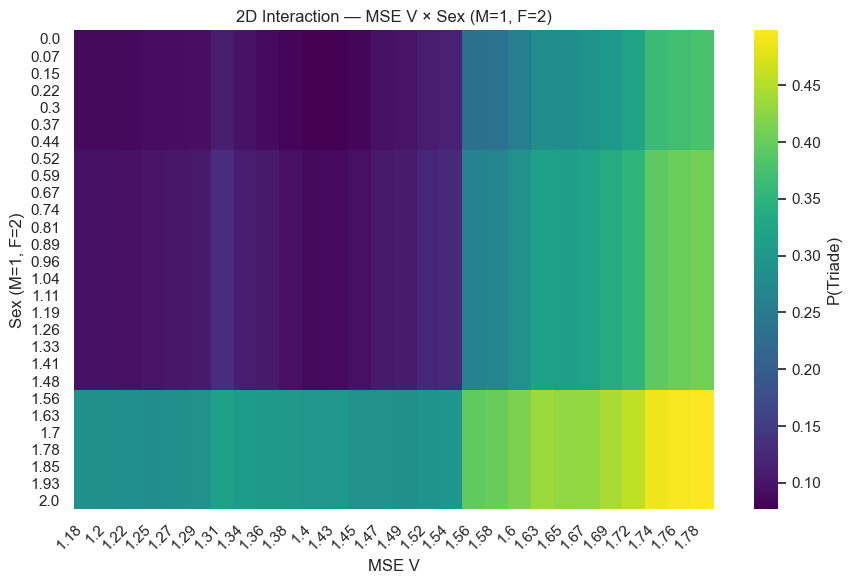

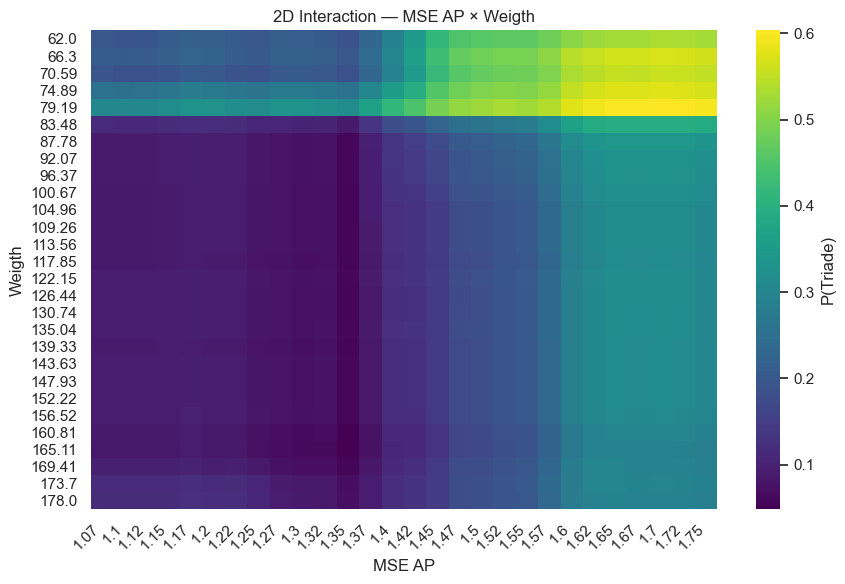

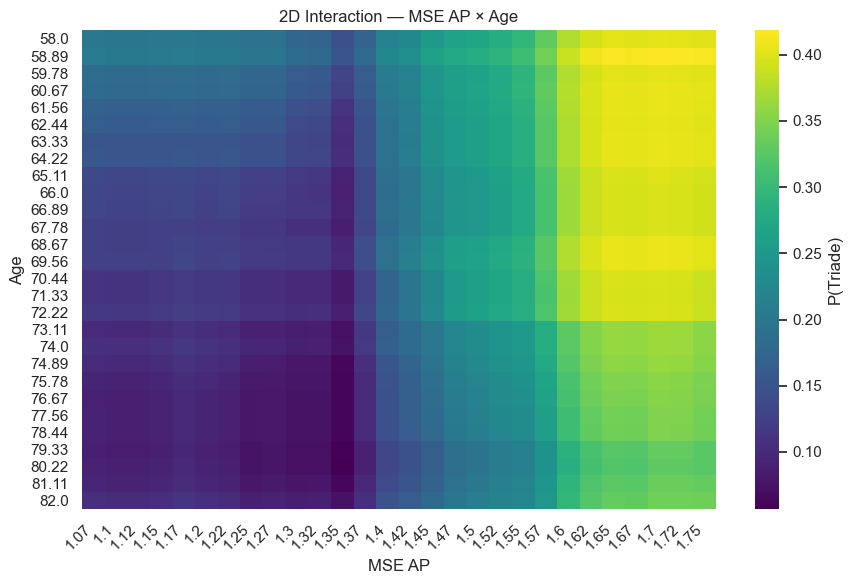

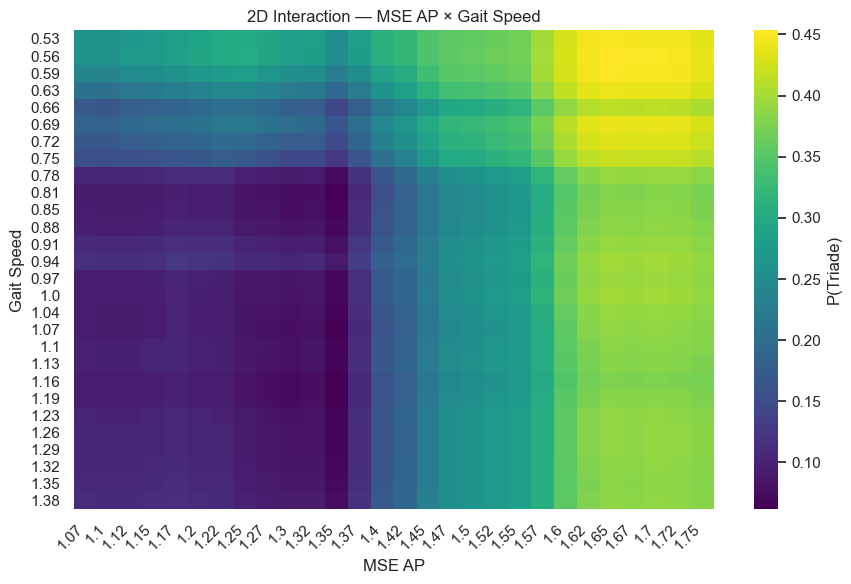

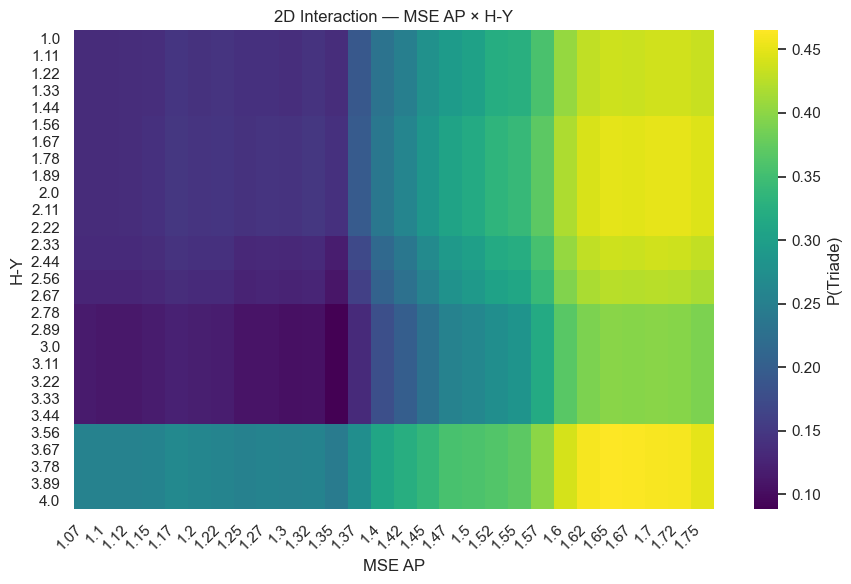

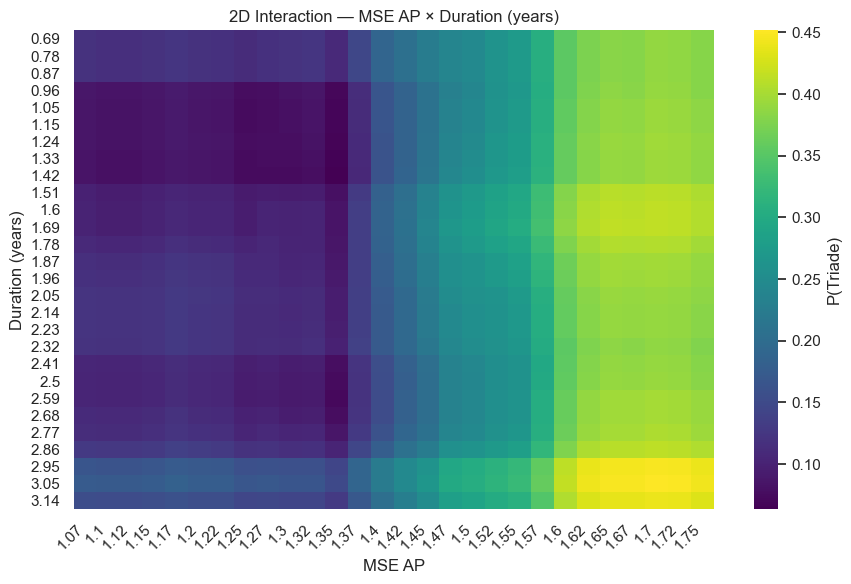

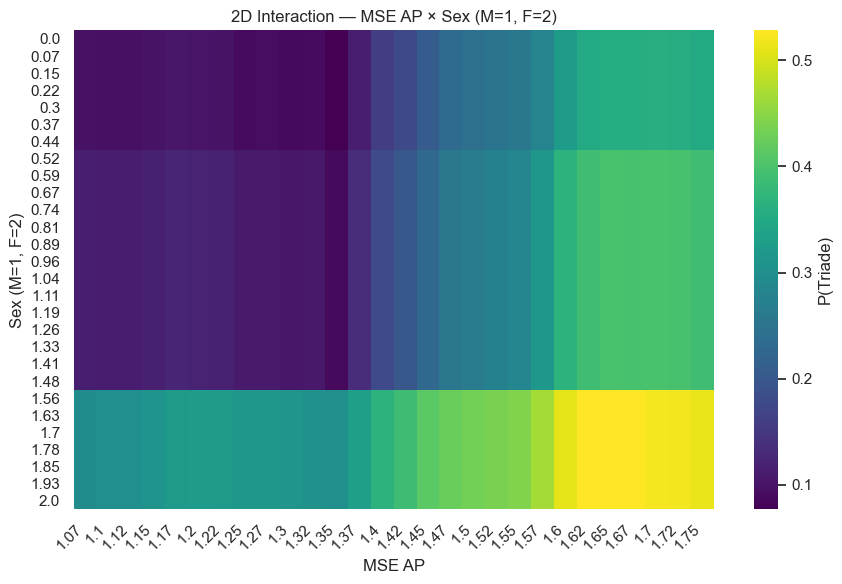

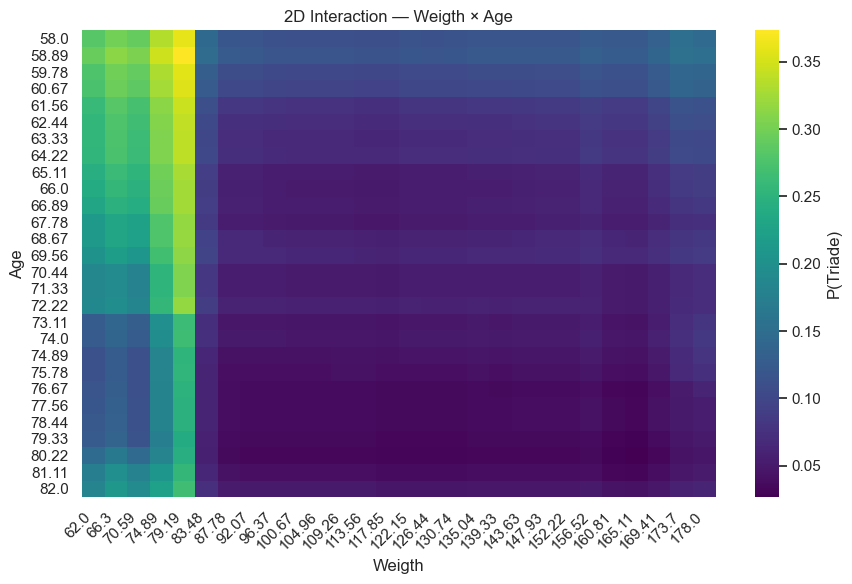

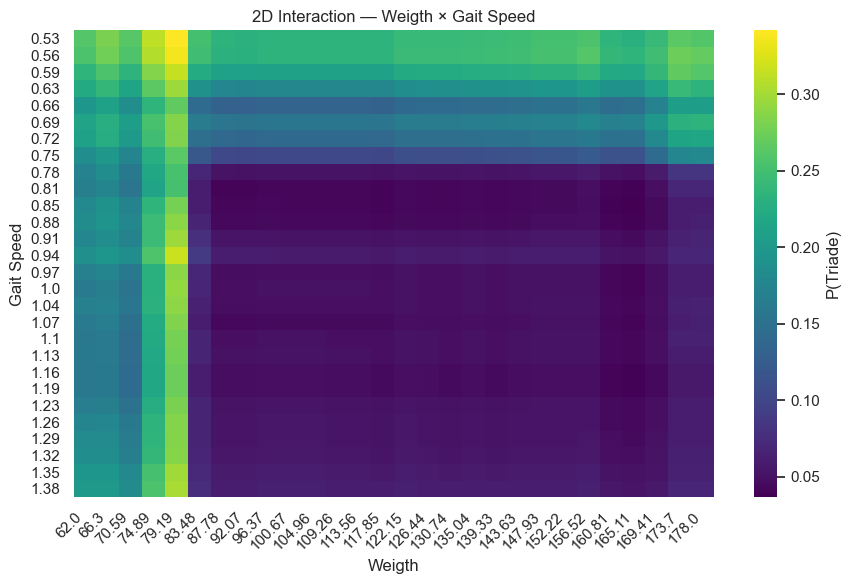

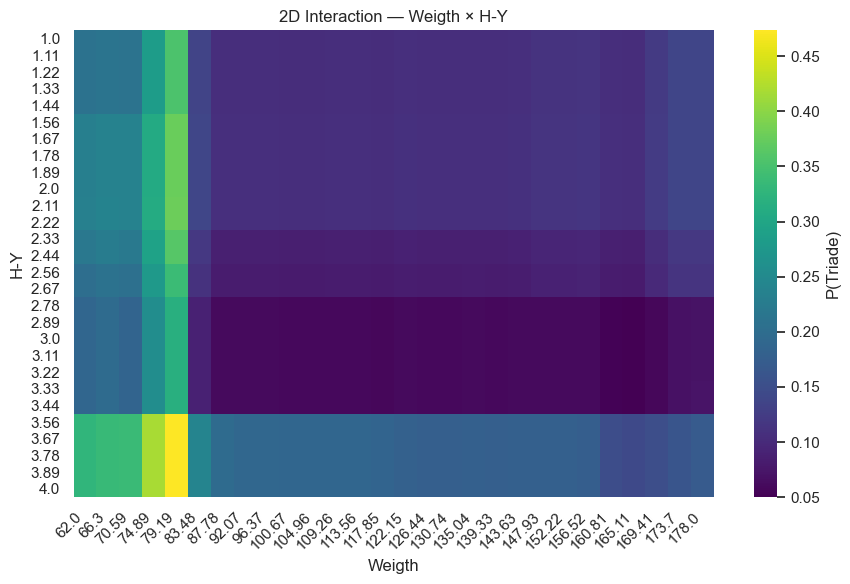

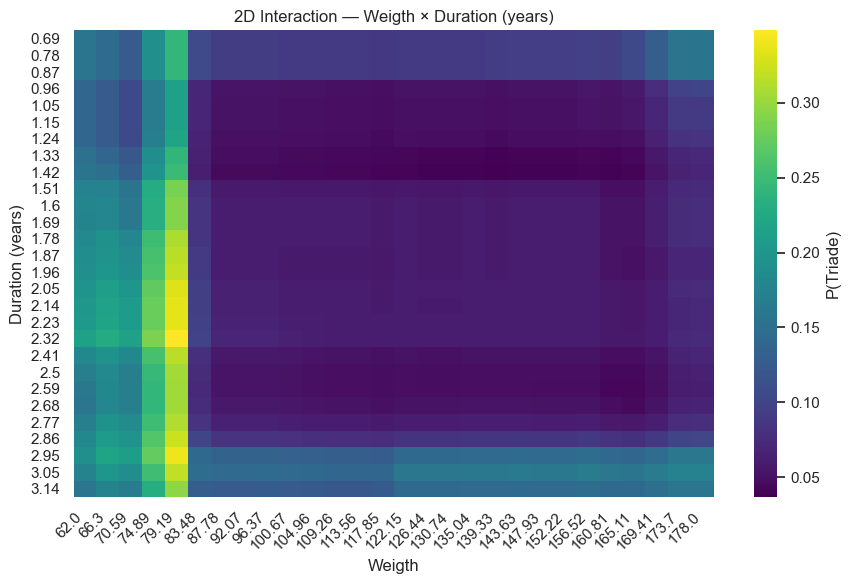

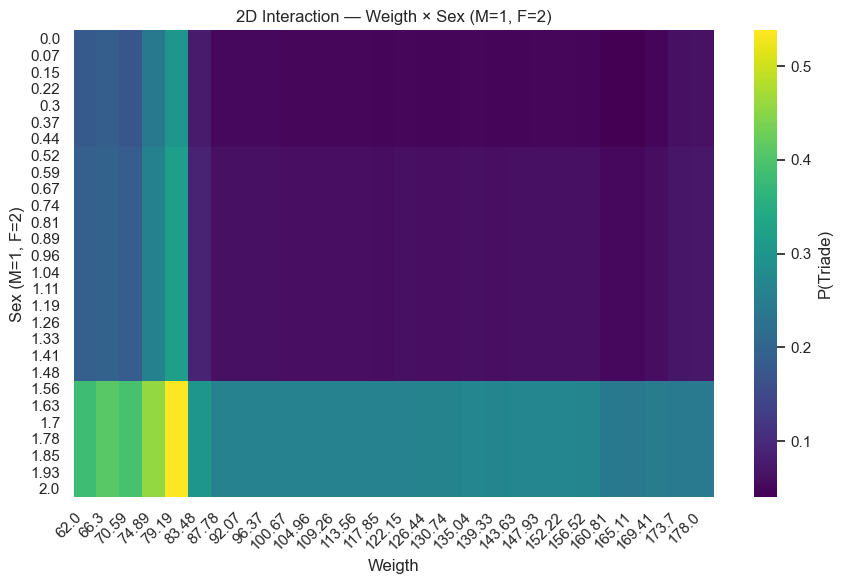

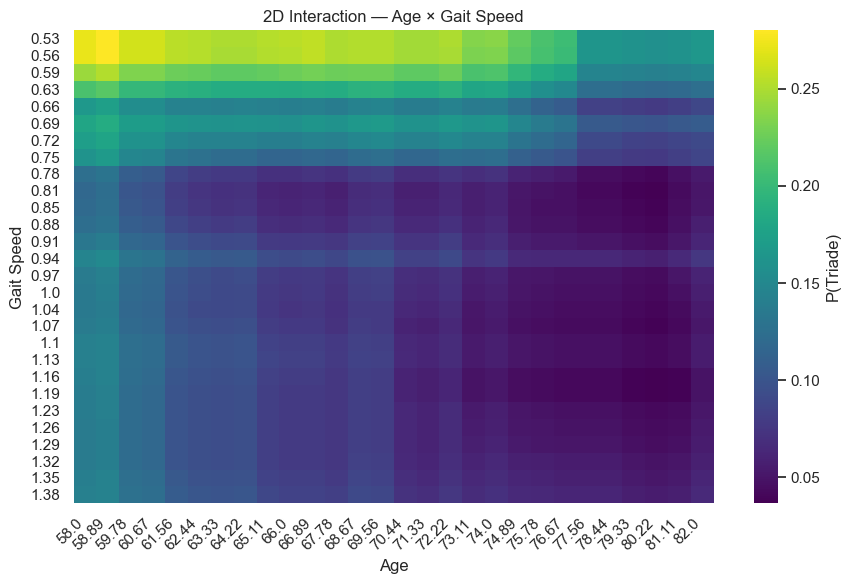

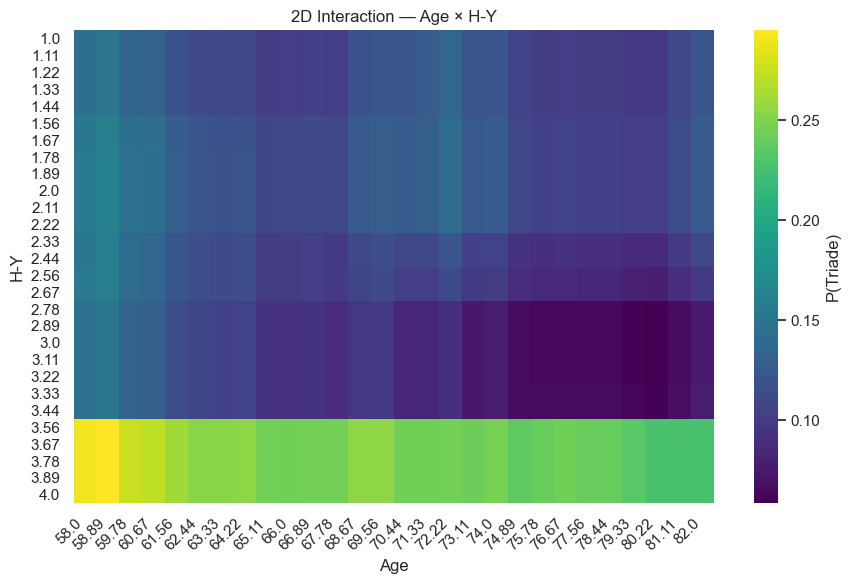

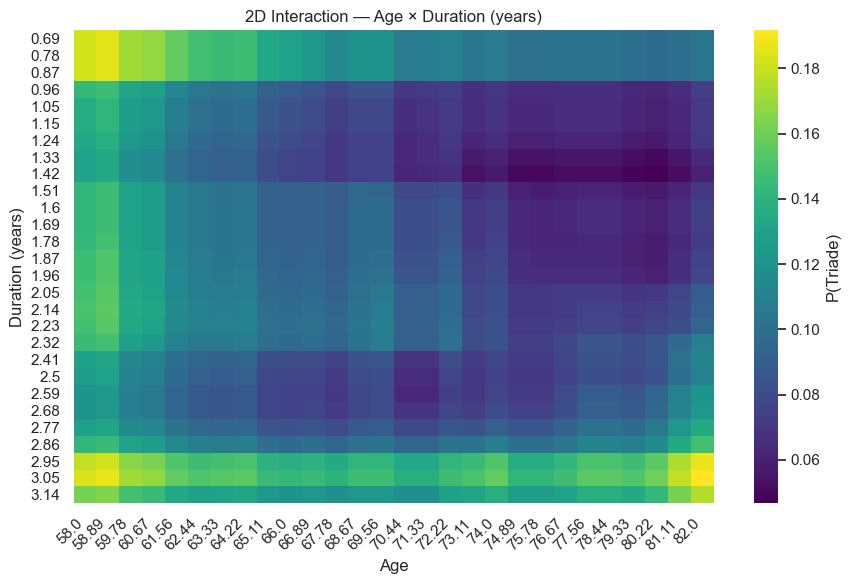

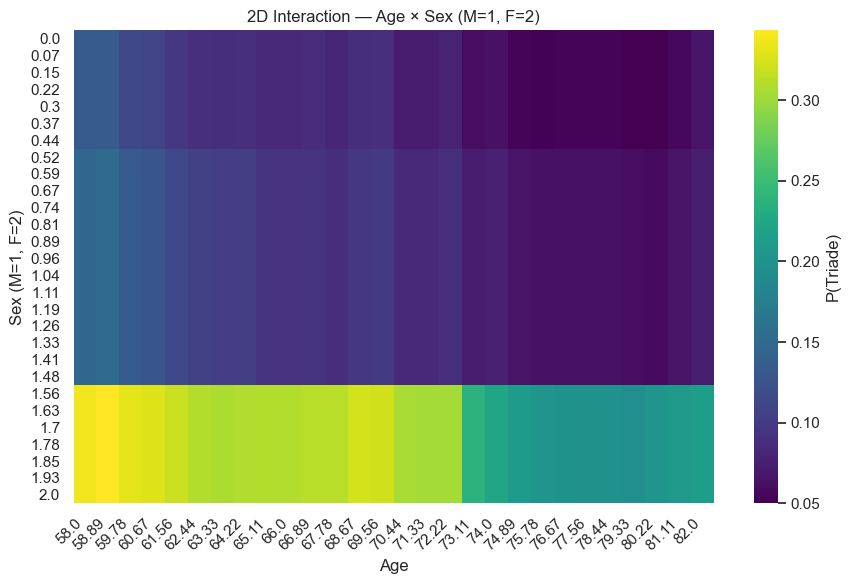

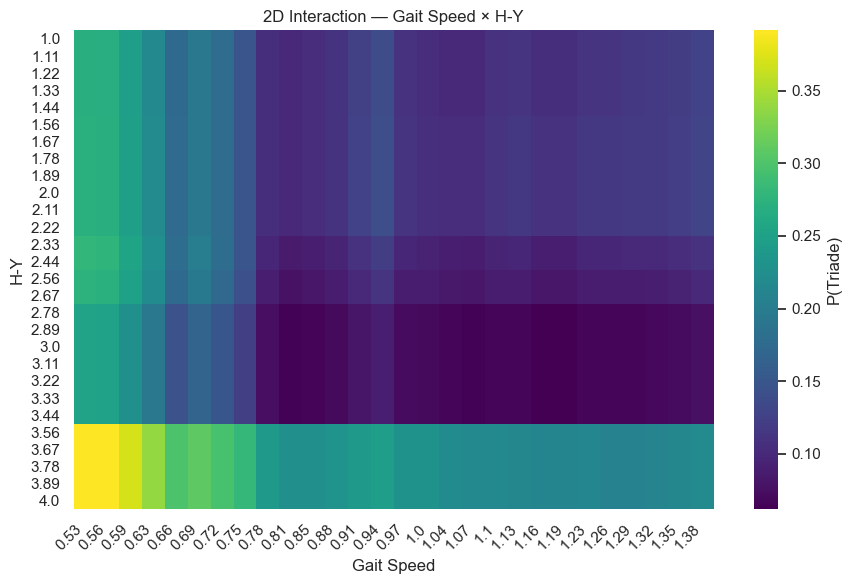

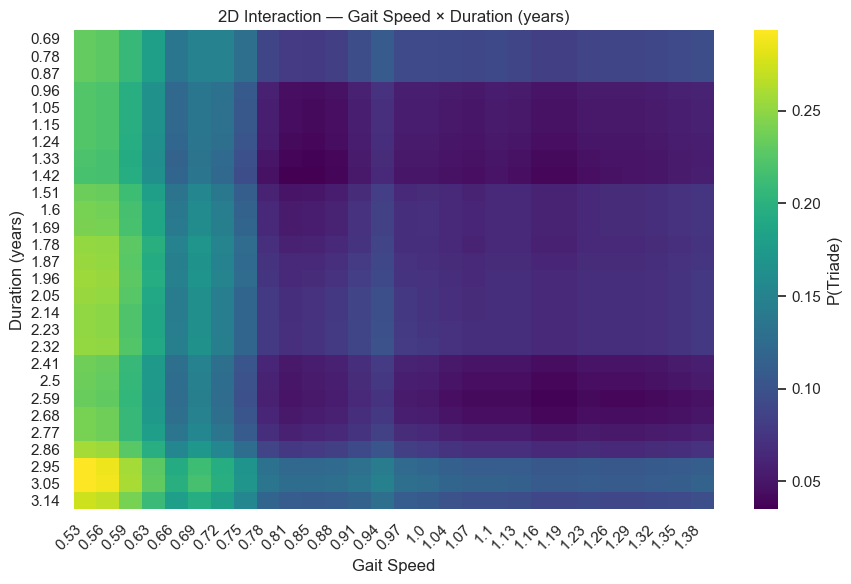

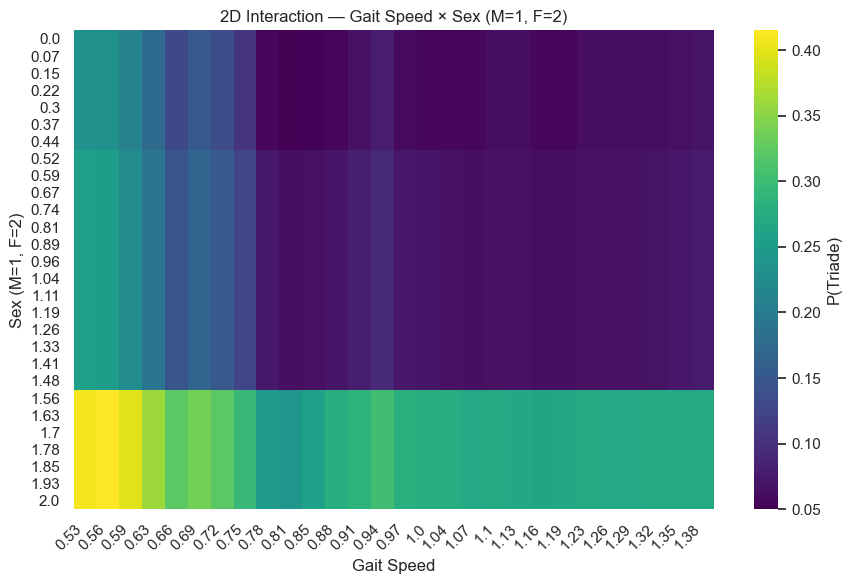

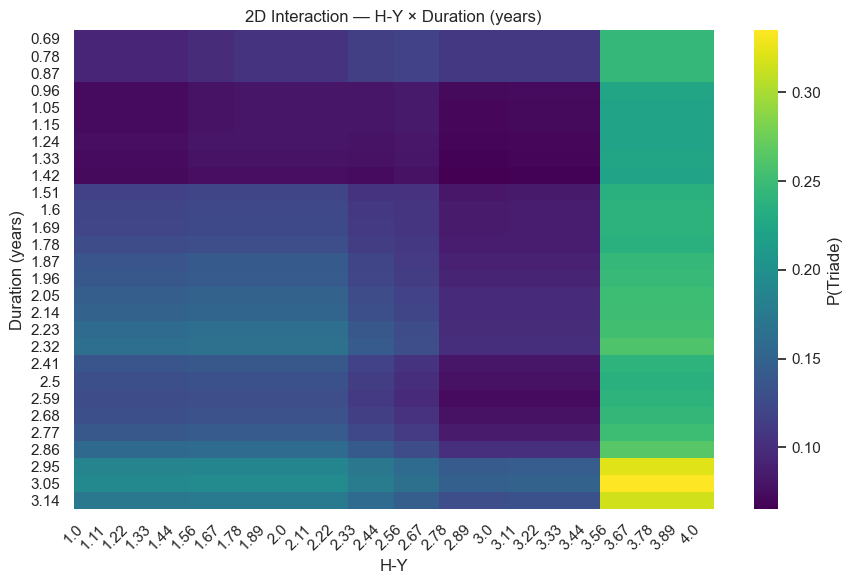

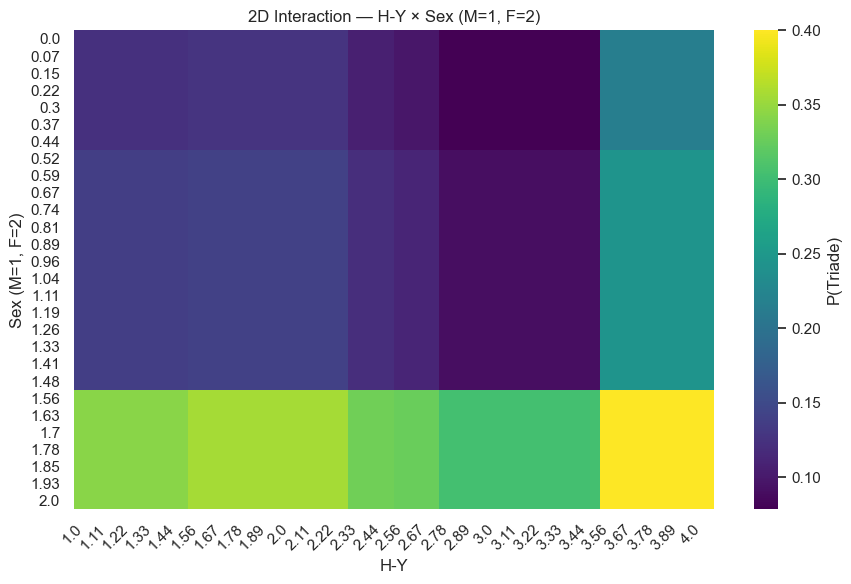

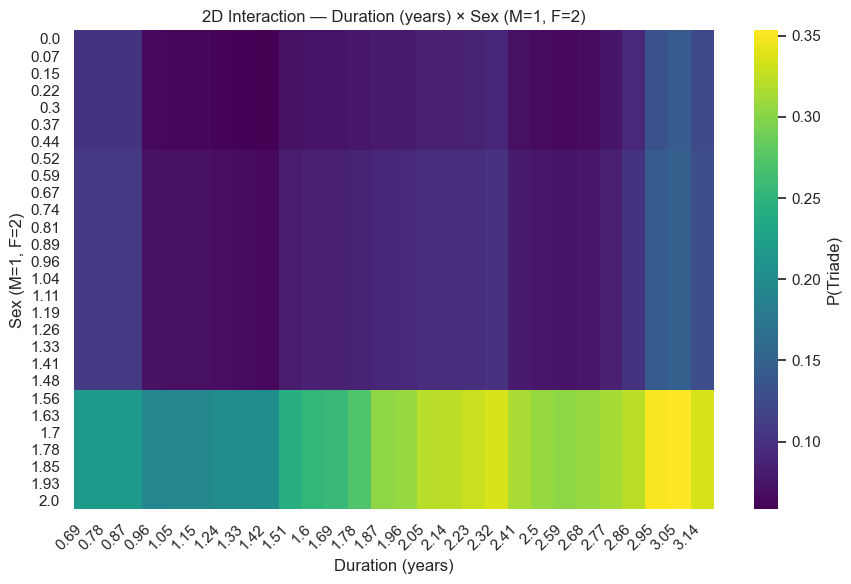

✅ Salvati ICE/PDP in: ../figures/ice_pdp
✅ Salvate interazioni 2D in: ../figures/interaction


In [ ]:
# ==== SETUP ====
import os, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")

# --- Percorsi
DATA_PATH = "../data/processed/train_original.csv"
OUT_ICE   = "../figurez/global/ice_pdp"
OUT_INT   = "../figurez/global/interaction"
os.makedirs(OUT_ICE, exist_ok=True)
os.makedirs(OUT_INT, exist_ok=True)

# --- Carica e prepara
df = pd.read_csv(DATA_PATH)
# Core features (puoi modificare l'elenco)
FEATURES = ["MSE ML", "iHR V", "MSE V", "MSE AP", "Weigth", "Age", "Gait Speed", "H-Y", "Duration (years)", "Sex (M=1, F=2)"]

available = [f for f in FEATURES if f in df.columns]
X = df[available].copy()
y = df["target_bin"].astype(int)

# (facoltativo) nessuno scaling per RF; lasciamo i valori “clinici”
rf = RandomForestClassifier(
    n_estimators=600, max_depth=None,
    class_weight="balanced",
    random_state=42, n_jobs=-1
)
rf.fit(X, y)

# ==== Funzioni di plotting ====

def robust_grid(series, n=30, q_low=0.05, q_high=0.95):
    lo, hi = np.quantile(series, [q_low, q_high])
    if np.isclose(lo, hi):  # degrada su min/max se i quantili collassano
        lo, hi = series.min(), series.max()
    return np.linspace(lo, hi, n)

def plot_ice_mean_sd(model, X, feature, n_points=30, save=True):
    grid = robust_grid(X[feature], n=n_points)
    # campiona soggetti per velocità, ma qui possiamo usare tutto il train
    probs_all = []
    X_base = X.copy()
    for v in grid:
        X_tmp = X_base.copy()
        X_tmp[feature] = v
        p = model.predict_proba(X_tmp)[:, 1]
        probs_all.append(p)
    probs_all = np.vstack(probs_all)  # shape (grid, n_samples)

    mean_prob = probs_all.mean(axis=1)
    std_prob  = probs_all.std(axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(grid, mean_prob, color="#1f3b5b", lw=2, label="Probabilità media")
    plt.fill_between(grid, mean_prob-std_prob, mean_prob+std_prob, color="#1f3b5b", alpha=0.18, label="±1 SD (ICE)")
    plt.axhline(0.5, ls="--", c="gray", lw=1)
    # rug plot
    yy = np.full(len(X), mean_prob.min() - 0.03)
    plt.plot(X[feature], yy, "|", color="k", alpha=0.6, markersize=10)
    plt.xlabel(feature); plt.ylabel("P(Triade)")
    plt.title(f"ICE mean ± SD — {feature}")
    plt.legend()
    plt.tight_layout()
    if save:
        fname = os.path.join(OUT_ICE, f"ice_mean_sd__{feature.replace(' ','_').replace('/','-')}.png")
        plt.savefig(fname, dpi=200)
    plt.show()

def plot_interaction_heatmap(model, X, f1, f2, n=30, save=True):
    gx = robust_grid(X[f1], n=n)
    gy = robust_grid(X[f2], n=n)

    # usa un soggetto “medio” come base
    base = X.median(numeric_only=True)
    # ricostruisci eventuali interi
    if (X[f2].dtype.kind in "iu"): base[f2] = int(round(base[f2]))
    if (X[f1].dtype.kind in "iu"): base[f1] = int(round(base[f1]))

    Z = np.zeros((len(gy), len(gx)))
    for i, yv in enumerate(gy):
        for j, xv in enumerate(gx):
            row = base.copy()
            row[f1] = xv
            row[f2] = yv
            Z[i, j] = model.predict_proba(pd.DataFrame([row], columns=X.columns))[0, 1]

    plt.figure(figsize=(9,6))
    ax = sns.heatmap(
        Z, cmap="viridis", cbar_kws={"label":"P(Triade)"},
        xticklabels=np.round(gx, 2), yticklabels=np.round(gy, 2)
    )
    ax.set_xlabel(f1); ax.set_ylabel(f2)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"2D Interaction — {f1} × {f2}")
    plt.tight_layout()
    if save:
        fname = os.path.join(OUT_INT, f"interaction__{f1.replace(' ','_')}__{f2.replace(' ','_')}.png")
        plt.savefig(fname, dpi=200)
    plt.show()

# ==== 1D: ICE/PDP per tutte le feature disponibili ====
for f in available:
    plot_ice_mean_sd(rf, X, f, n_points=35, save=True)

# ==== 2D: heatmap per tutte le coppie possibili (senza ripetizioni) ====
pairs = list(itertools.combinations(available, 2))
for f1, f2 in pairs:
    plot_interaction_heatmap(rf, X, f1, f2, n=28, save=True)

print(f"✅ Salvati ICE/PDP in: {OUT_ICE}")
print(f"✅ Salvate interazioni 2D in: {OUT_INT}")

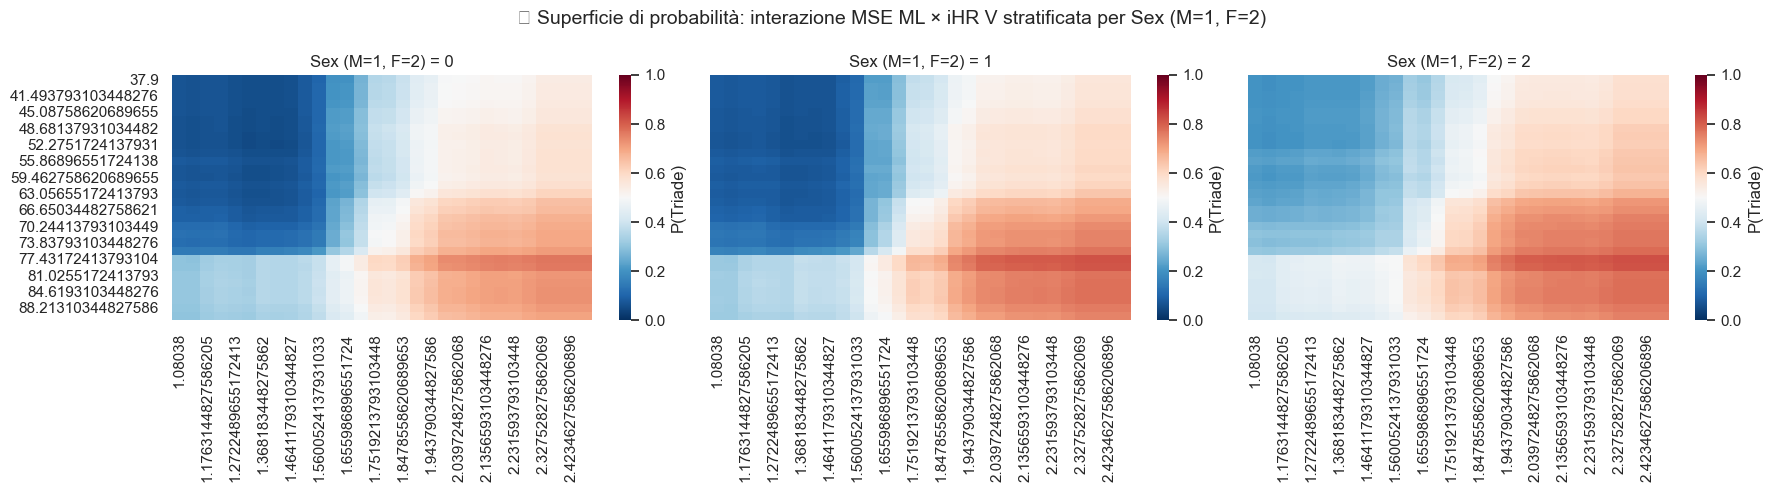

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Usa sempre il modello RF già allenato (rf, X, y)
f1, f2, strat = "MSE ML", "iHR V", "Sex (M=1, F=2)"

# griglie per le due continue
gx = np.linspace(X[f1].min(), X[f1].max(), 30)
gy = np.linspace(X[f2].min(), X[f2].max(), 30)

# dataframe con tutte le combinazioni
records = []
for s in sorted(X[strat].unique()):
    base = X.median(numeric_only=True).to_dict()
    for xv in gx:
        for yv in gy:
            row = base.copy()
            row[f1] = xv
            row[f2] = yv
            row[strat] = s
            prob = rf.predict_proba(pd.DataFrame([row], columns=X.columns))[0, 1]
            records.append({f1: xv, f2: yv, strat: s, "Probability": prob})

df_3d = pd.DataFrame(records)

# === FacetGrid ===
sns.set(style="whitegrid")
g = sns.FacetGrid(df_3d, col=strat, height=5, aspect=1.2)

def draw_heatmap(data, **kwargs):
    pivoted = data.pivot(index=f2, columns=f1, values="Probability")
    sns.heatmap(pivoted, cmap="RdBu_r", cbar_kws={'label': 'P(Triade)'}, vmin=0, vmax=1)

g.map_dataframe(draw_heatmap)
g.set_titles(f"{strat} = "+"{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(f"🔍 Superficie di probabilità: interazione {f1} × {f2} stratificata per {strat}", fontsize=14)
plt.show()

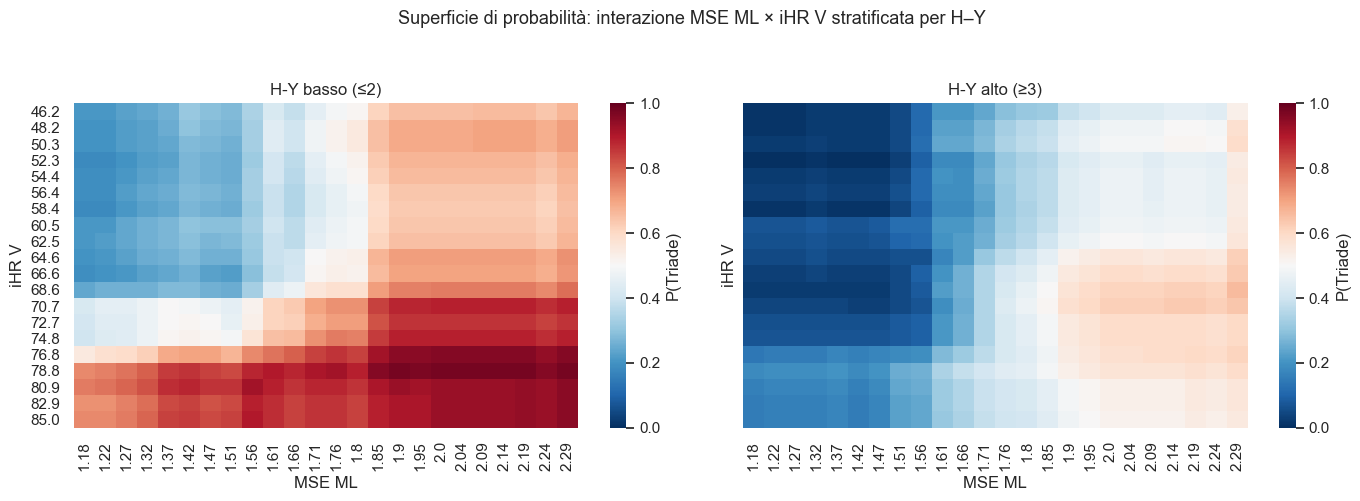

In [31]:
# === H-Y stratified interaction: MSE_ML × iHR_V ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid")

# 1) Carica train e prepara feature
df = pd.read_csv("../data/processed/train_original.csv")
needed = ["MSE ML","iHR V","Age","Sex (M=1, F=2)","H-Y","Gait Speed","Duration (years)","Weigth","target_bin"]
df = df[needed].dropna().copy()

# 2) Binarizza H-Y: low (≤2) vs high (≥3)
df["HY_group"] = np.where(df["H-Y"]<=2, "Low (≤2)", "High (≥3)")

# 3) Allena un RF (stesso setup dei blocchi precedenti)
X = df.drop(columns=["target_bin","HY_group"])
y = df["target_bin"].astype(int)
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X, y)

# 4) Griglie (prendiamo range robusti dal 5°–95° percentile del train)
mse_ml_grid = np.linspace(df["MSE ML"].quantile(0.05), df["MSE ML"].quantile(0.95), 24)
ihr_v_grid  = np.linspace(df["iHR V"].quantile(0.05),  df["iHR V"].quantile(0.95),  20)

def surface_for_group(group_label):
    # usa un soggetto tipico del gruppo (mediana delle covariate)
    base = df[df["HY_group"]==group_label].median(numeric_only=True)
    # costruiamo la matrice di probabilità
    Z = np.zeros((len(ihr_v_grid), len(mse_ml_grid)))
    for i, ihr in enumerate(ihr_v_grid):
        for j, mse in enumerate(mse_ml_grid):
            row = base.copy()
            row["MSE ML"] = mse
            row["iHR V"]  = ihr
            # RF si aspetta tutte le colonne X nell'ordine
            Z[i, j] = rf.predict_proba(pd.DataFrame([row[X.columns]]) )[0,1]
    return Z

Z_low  = surface_for_group("Low (≤2)")
Z_high = surface_for_group("High (≥3)")

# 5) Plot a due pannelli con stessa scala colore
fig, axes = plt.subplots(1, 2, figsize=(14, 4.8), sharex=True, sharey=True)
vmin, vmax = 0.0, 1.0
cmap = "RdBu_r"

for ax, Z, title in zip(
    axes,
    [Z_low, Z_high],
    ["H-Y basso (≤2)", "H-Y alto (≥3)"]
):
    hm = sns.heatmap(
        Z, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
        cbar=True, cbar_kws={"label":"P(Triade)"},
        xticklabels=np.round(mse_ml_grid,2),
        yticklabels=np.round(ihr_v_grid,1)
    )
    ax.set_title(title)
    ax.set_xlabel("MSE ML")
    ax.set_ylabel("iHR V")

plt.suptitle("Superficie di probabilità: interazione MSE ML × iHR V stratificata per H–Y", y=1.04, fontsize=13)
plt.tight_layout()
# plt.savefig("../figures/interaction_MSEML_iHRV_by_HY.png", dpi=300)
plt.show()

Real-only shape: (219, 11) | Balanced (CTGAN) shape: (262, 11)

📊 Confronto metriche (10-fold CV):

                        Real-only Balanced-CTGAN
n                             219            262
Accuracy (mean±sd)  0.730 ± 0.094  0.763 ± 0.079
F1 (mean±sd)        0.624 ± 0.134  0.760 ± 0.081
ROC AUC (mean±sd)   0.796 ± 0.087  0.838 ± 0.086
PR AUC (mean±sd)    0.782 ± 0.092  0.863 ± 0.080
Brier (mean±sd)     0.176 ± 0.036  0.165 ± 0.037


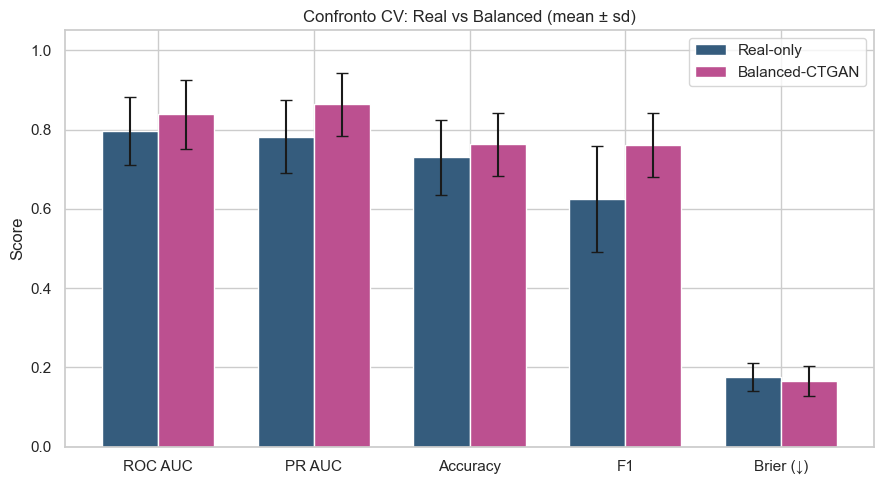

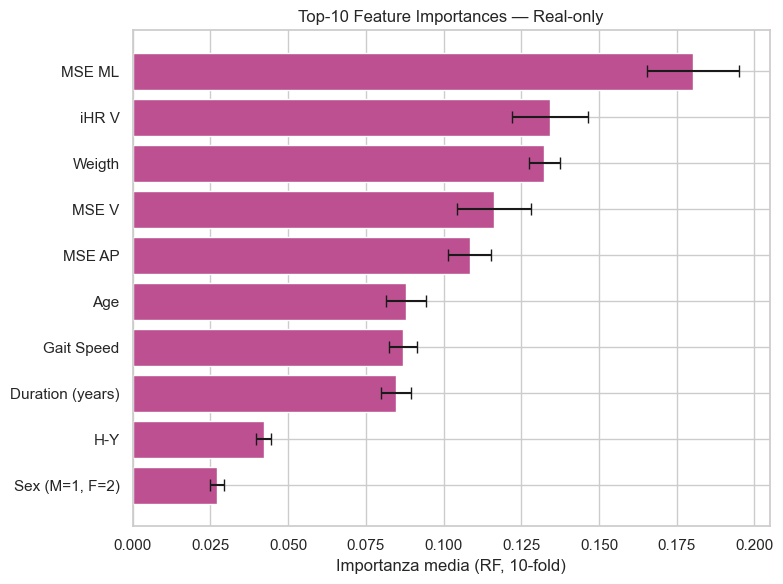

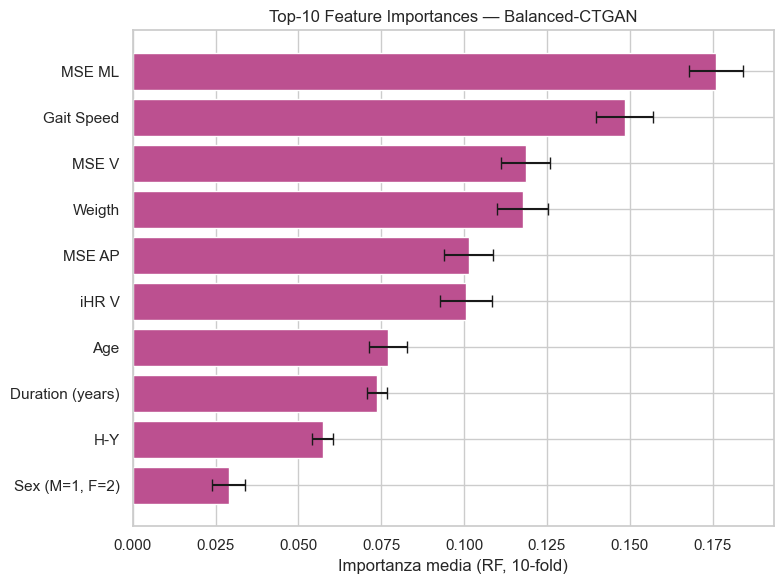


🔍 Top-10 importanze: confronto Real vs Balanced

         Feature  Imp_Real  Imp_Bal  Δ(Bal-Real)
          MSE ML    0.1802   0.1761      -0.0041
           iHR V    0.1342   0.1006      -0.0336
          Weigth    0.1324   0.1177      -0.0147
           MSE V    0.1161   0.1186       0.0025
          MSE AP    0.1084   0.1014      -0.0070
             Age    0.0880   0.0771      -0.0109
      Gait Speed    0.0868   0.1485       0.0617
Duration (years)    0.0846   0.0738      -0.0108
             H-Y    0.0421   0.0573       0.0152
  Sex (M=1, F=2)    0.0271   0.0290       0.0018


In [ ]:
# ======================
# CV su real-only vs balanced (CTGAN) + confronto
# ======================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, brier_score_loss)

sns.set(style="whitegrid")

REAL_PATH = "../data/processed/train_original.csv"
BAL_PATH  = "../data/processed/train_balanced_ctgan.csv"
FIG_DIR   = "../figurez/global"
os.makedirs(FIG_DIR, exist_ok=True)

def run_cv(df, name, n_splits=10, use_class_weight=True, random_state=42):
    """K-fold CV con RF + metriche e importanze."""
    df = df.copy()
    if "target_bin" not in df.columns:
        raise ValueError(f"'target_bin' non presente in {name}")

    # X, y (qui il dataset è già pulito: core+covariate)
    y = df["target_bin"].astype(int)
    X = df.drop(columns=["target_bin"])

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    accs, f1s, rocs, prs, briers = [], [], [], [], []
    importances = []

    for fold, (tr, va) in enumerate(kf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        rf = RandomForestClassifier(
            class_weight="balanced" if use_class_weight else None,
            n_estimators=500,
            max_features="sqrt",
            random_state=random_state
        )
        rf.fit(X_tr, y_tr)

        y_hat  = rf.predict(X_va)
        y_prob = rf.predict_proba(X_va)[:, 1]

        accs.append(accuracy_score(y_va, y_hat))
        f1s.append(f1_score(y_va, y_hat))
        rocs.append(roc_auc_score(y_va, y_prob))
        prs.append(average_precision_score(y_va, y_prob))  # AUPRC
        briers.append(brier_score_loss(y_va, y_prob))

        importances.append(rf.feature_importances_)

    # riassunto
    res = {
        "name": name,
        "n": len(df),
        "metrics": pd.DataFrame({
            "Accuracy": accs, "F1": f1s, "ROC_AUC": rocs,
            "PR_AUC": prs, "Brier": briers
        }),
        "importances_mean": np.mean(importances, axis=0),
        "importances_sd":   np.std(importances, axis=0),
        "features": X.columns.tolist()
    }
    return res

# --- carica dataset
df_real = pd.read_csv(REAL_PATH)
df_bal  = pd.read_csv(BAL_PATH)

print(f"Real-only shape: {df_real.shape} | Balanced (CTGAN) shape: {df_bal.shape}")

# --- esegui CV su entrambi
res_real = run_cv(df_real, "Real-only")
res_bal  = run_cv(df_bal,  "Balanced-CTGAN")

# --- tabella metriche (media ± sd)
def summarize(res):
    m = res["metrics"]
    return pd.Series({
        "n": res["n"],
        "Accuracy (mean±sd)": f"{m['Accuracy'].mean():.3f} ± {m['Accuracy'].std():.3f}",
        "F1 (mean±sd)":       f"{m['F1'].mean():.3f} ± {m['F1'].std():.3f}",
        "ROC AUC (mean±sd)":  f"{m['ROC_AUC'].mean():.3f} ± {m['ROC_AUC'].std():.3f}",
        "PR AUC (mean±sd)":   f"{m['PR_AUC'].mean():.3f} ± {m['PR_AUC'].std():.3f}",
        "Brier (mean±sd)":    f"{m['Brier'].mean():.3f} ± {m['Brier'].std():.3f}",
    })

summary_df = pd.DataFrame({
    "Real-only": summarize(res_real),
    "Balanced-CTGAN": summarize(res_bal)
})
print("\n📊 Confronto metriche (10-fold CV):\n")
print(summary_df.to_string())

# --- plot barre confronto AUC/PR/Brier (mean ± sd)
def plot_compare(res1, res2, savepath):
    m1, m2 = res1["metrics"], res2["metrics"]
    labels = ["ROC AUC", "PR AUC", "Accuracy", "F1", "Brier (↓)"]
    means1 = [m1["ROC_AUC"].mean(), m1["PR_AUC"].mean(), m1["Accuracy"].mean(), m1["F1"].mean(), m1["Brier"].mean()]
    sds1   = [m1["ROC_AUC"].std(),  m1["PR_AUC"].std(),  m1["Accuracy"].std(),  m1["F1"].std(),  m1["Brier"].std()]
    means2 = [m2["ROC_AUC"].mean(), m2["PR_AUC"].mean(), m2["Accuracy"].mean(), m2["F1"].mean(), m2["Brier"].mean()]
    sds2   = [m2["ROC_AUC"].std(),  m2["PR_AUC"].std(),  m2["Accuracy"].std(),  m2["F1"].std(),  m2["Brier"].std()]

    x = np.arange(len(labels))
    w = 0.36
    plt.figure(figsize=(9,5))
    plt.bar(x-w/2, means1, w, yerr=sds1, capsize=4, label="Real-only", color="#355C7D")
    plt.bar(x+w/2, means2, w, yerr=sds2, capsize=4, label="Balanced-CTGAN", color="#BC5090")
    plt.xticks(x, labels); plt.ylabel("Score"); plt.title("Confronto CV: Real vs Balanced (mean ± sd)")
    plt.ylim(0, 1.05); plt.legend(); plt.tight_layout()
    plt.savefig(savepath, dpi=300); plt.show()

plot_compare(res_real, res_bal, os.path.join(FIG_DIR, "cv_compare_real_vs_balanced.png"))

# --- feature importances: real vs balanced
def plot_importances(res, savepath):
    df_imp = pd.DataFrame({
        "Feature": res["features"],
        "Importance": res["importances_mean"],
        "SD": res["importances_sd"]
    }).sort_values("Importance", ascending=False)

    plt.figure(figsize=(8,6))
    plt.barh(df_imp["Feature"].head(10)[::-1],
             df_imp["Importance"].head(10)[::-1],
             xerr=df_imp["SD"].head(10)[::-1],
             capsize=4, color="#BC5090")
    plt.xlabel("Importanza media (RF, 10-fold)"); plt.title(f"Top-10 Feature Importances — {res['name']}")
    plt.tight_layout(); plt.savefig(savepath, dpi=300); plt.show()
    return df_imp

imp_real = plot_importances(res_real, os.path.join(FIG_DIR, "feat_importances_real.png"))
imp_bal  = plot_importances(res_bal,  os.path.join(FIG_DIR, "feat_importances_balanced.png"))

# --- tabellina comparativa importanze (prime 10)
cmp = (imp_real.rename(columns={"Importance":"Imp_Real"})
             .merge(imp_bal.rename(columns={"Importance":"Imp_Bal"}), on="Feature", how="outer"))
cmp["Δ(Bal-Real)"] = cmp["Imp_Bal"].fillna(0) - cmp["Imp_Real"].fillna(0)
cmp = cmp.sort_values("Imp_Real", ascending=False).head(10)[["Feature","Imp_Real","Imp_Bal","Δ(Bal-Real)"]]
print("\n🔍 Top-10 importanze: confronto Real vs Balanced\n")
print(cmp.round(4).to_string(index=False))

✅ Dataset per discriminator: X=(481, 10), y distribuzione: {0: 262, 1: 219}

=== Discriminative Score (5-fold CV) ===
Accuracy : 0.171 ± 0.040
F1       : 0.086 ± 0.049
ROC AUC  : 0.100 ± 0.032
PR  AUC  : 0.294 ± 0.009
ROC AUC bootstrap 95% CI: [0.070, 0.125]


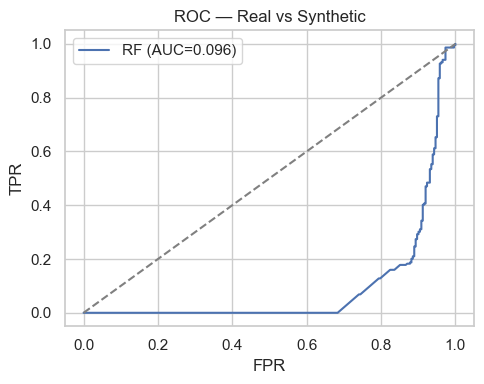


🔍 Permutation importance (discriminator):
          Feature  Importance       SD
      Gait Speed    0.025372 0.010831
  Sex (M=1, F=2)   -0.005985 0.001859
             H-Y   -0.007996 0.004417
          Weigth   -0.019931 0.004007
             Age   -0.025778 0.004408
          MSE ML   -0.030455 0.004063
Duration (years)   -0.031205 0.005089
          MSE AP   -0.032893 0.004529
           iHR V   -0.038285 0.004448
           MSE V   -0.043306 0.004920


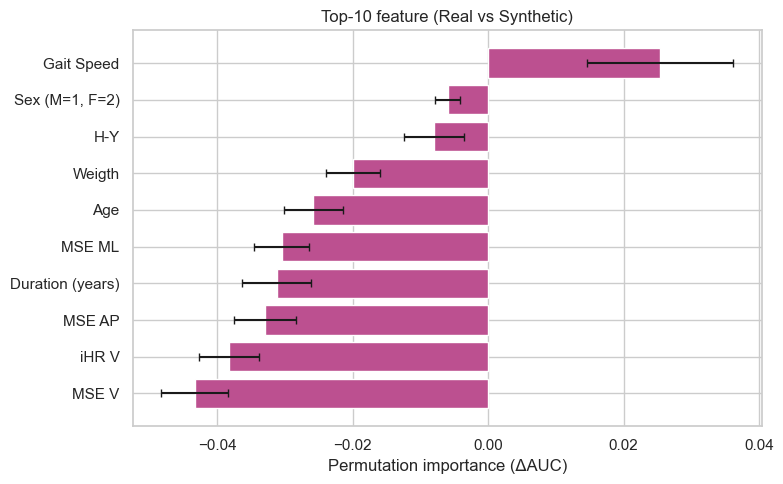

🟢 I sintetici NON sono facilmente distinguibili dai reali (buon segno).


In [34]:
# === IMPORT
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, classification_report, roc_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# === LOAD
real = pd.read_csv('../data/processed/train_original.csv')       # 219 x 11
synth = pd.read_csv('../data/processed/train_balanced_ctgan.csv')      # 262 x 11

# === Tag & allinea colonne
real = real.copy(); synth = synth.copy()
real['is_real'] = 1
synth['is_real'] = 0

# (evita leakage: rimuovi target_bin, se presente)
drop_leak = ['target_bin']
real = real.drop(columns=[c for c in drop_leak if c in real.columns], errors='ignore')
synth = synth.drop(columns=[c for c in drop_leak if c in synth.columns], errors='ignore')

# Allinea set di feature comuni
common_cols = [c for c in real.columns if c in synth.columns]
df_all = pd.concat([real[common_cols], synth[common_cols]], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_all.drop(columns=['is_real'])
y = df_all['is_real'].astype(int)

print(f"✅ Dataset per discriminator: X={X.shape}, y distribuzione: {y.value_counts().to_dict()}")

# === CV robusta (5-fold stratificata)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s, rocs, pr_aucs = [], [], [], []
probs_all, true_all = [], []

for fold, (tr, va) in enumerate(kf.split(X, y), 1):
    Xtr, Xva = X.iloc[tr], X.iloc[va]
    ytr, yva = y.iloc[tr], y.iloc[va]

    clf = RandomForestClassifier(n_estimators=300, max_depth=None,
                                 class_weight='balanced', random_state=42)
    clf.fit(Xtr, ytr)
    p = clf.predict_proba(Xva)[:,1]
    yhat = (p >= 0.5).astype(int)

    accs.append(accuracy_score(yva, yhat))
    f1s.append(f1_score(yva, yhat))
    rocs.append(roc_auc_score(yva, p))
    pr_aucs.append(average_precision_score(yva, p))

    probs_all.extend(p); true_all.extend(yva)

print("\n=== Discriminative Score (5-fold CV) ===")
print(f"Accuracy : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1       : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"ROC AUC  : {np.mean(rocs):.3f} ± {np.std(rocs):.3f}")
print(f"PR  AUC  : {np.mean(pr_aucs):.3f} ± {np.std(pr_aucs):.3f}")

# === Bootstrap 95% CI su ROC AUC (stesso pool out-of-fold)
probs_all = np.array(probs_all); true_all = np.array(true_all)
rng = np.random.RandomState(42)
boot = []
for _ in range(2000):
    idx = rng.randint(0, len(true_all), len(true_all))
    boot.append(roc_auc_score(true_all[idx], probs_all[idx]))
boot = np.array(boot)
ci_l, ci_u = np.percentile(boot, [2.5, 97.5])
print(f"ROC AUC bootstrap 95% CI: [{ci_l:.3f}, {ci_u:.3f}]")

# === ROC curve
fpr, tpr, _ = roc_curve(true_all, probs_all)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"RF (AUC={roc_auc_score(true_all, probs_all):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Real vs Synthetic")
plt.legend(); plt.tight_layout(); plt.show()

# === Permutation importance (su train/test split singolo per interpretabilità)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.25, random_state=7)
clf = RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=7)
clf.fit(X_tr, y_tr)
perm = permutation_importance(clf, X_te, y_te, n_repeats=20, random_state=7, scoring='roc_auc')

imp_df = (pd.DataFrame({'Feature': X.columns, 'Importance': perm.importances_mean, 'SD': perm.importances_std})
          .sort_values('Importance', ascending=False))
print("\n🔍 Permutation importance (discriminator):\n", imp_df.head(10).to_string(index=False))

plt.figure(figsize=(8,5))
top = imp_df.head(10).sort_values('Importance')
plt.barh(top['Feature'], top['Importance'], xerr=top['SD'], capsize=3, color='#bc5090')
plt.xlabel("Permutation importance (ΔAUC)"); plt.title("Top-10 feature (Real vs Synthetic)")
plt.tight_layout(); plt.show()

# === Semaforo rapido
mean_auc = np.mean(rocs)
if mean_auc <= 0.60:
    print("🟢 I sintetici NON sono facilmente distinguibili dai reali (buon segno).")
elif mean_auc <= 0.70:
    print("🟠 Leggera distinguibilità: controlla le feature con PI più alta per eventuali piccoli shift.")
else:
    print("🔴 Alto rischio di fingerprint nei sintetici: rivedi CTGAN (epochs, pac, discretizzazioni) o riequilibra feature/varianze.")

✅ synth_matched shape: (262, 11)
Classe 0 — KS p-value  prima=1.0000 | dopo=0.9925
Classe 1 — KS p-value  prima=0.0015 | dopo=0.6443


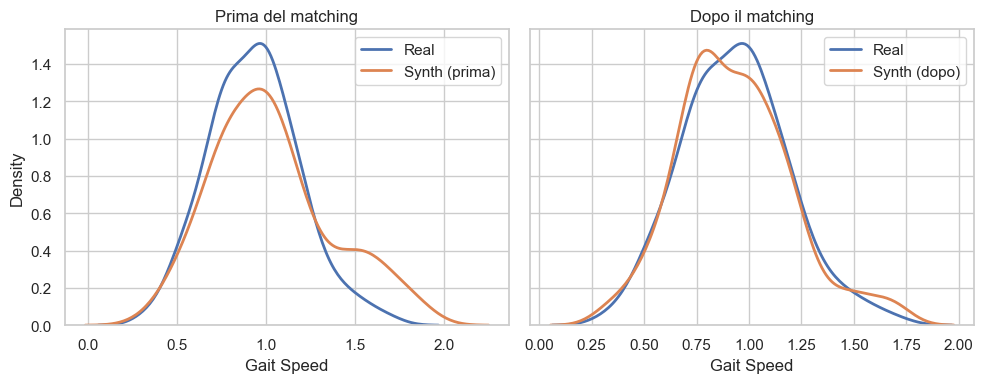

🔎 Discriminator dataset: X=(481, 10), y distribuzione={0: 262, 1: 219}


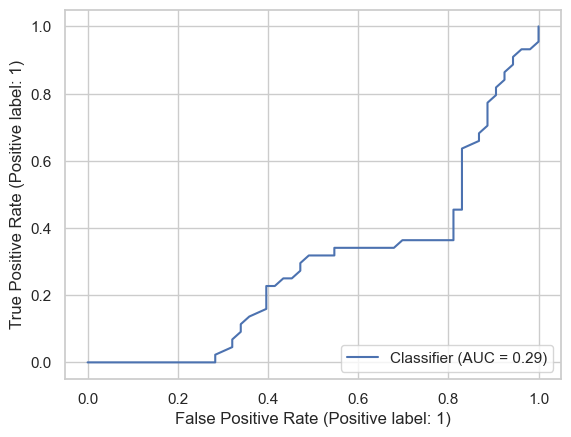

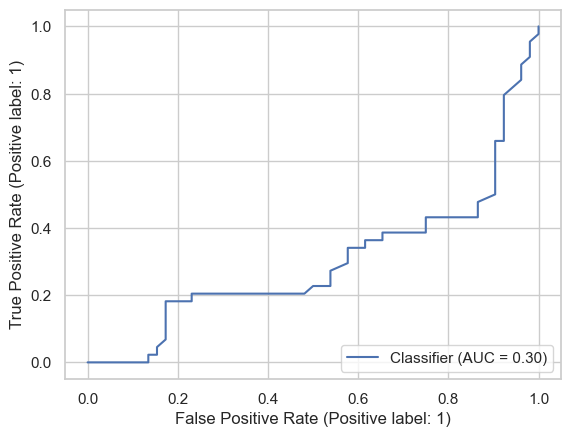

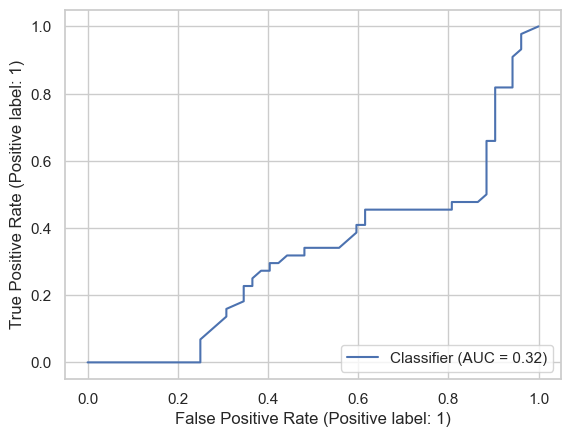

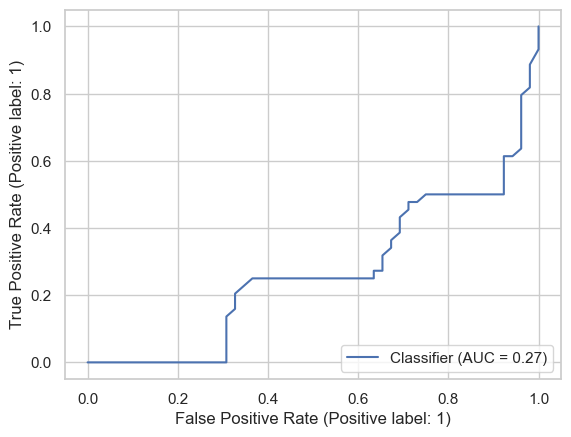

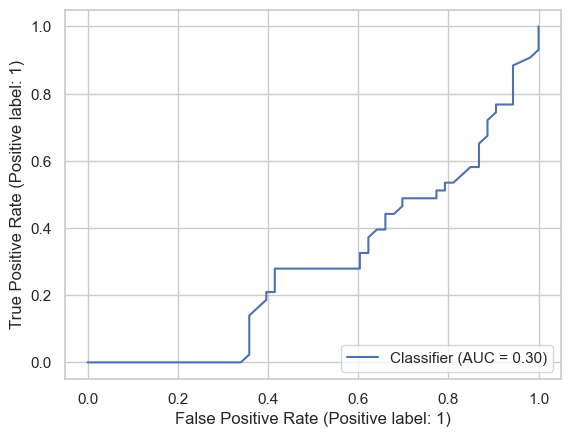

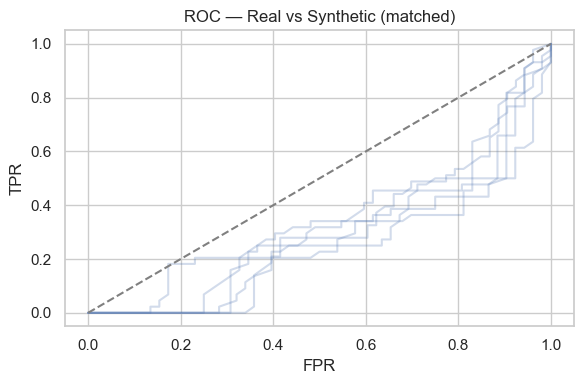


=== Discriminative Score (matched) ===
Accuracy: 0.410 ± 0.050
F1      : 0.302 ± 0.036
ROC AUC : 0.296 ± 0.018
PR  AUC : 0.348 ± 0.011

🔍 Permutation importance (discriminator, matched):
         Feature  Importance       SD
  Sex (M=1, F=2)   -0.002394 0.003509
             H-Y   -0.004218 0.007374
          Weigth   -0.004928 0.010706
Duration (years)   -0.008882 0.008791
          MSE AP   -0.009661 0.014302
      Gait Speed   -0.010876 0.012597
           MSE V   -0.017788 0.013162
             Age   -0.022174 0.011649
           iHR V   -0.026628 0.013676
          MSE ML   -0.029033 0.013345


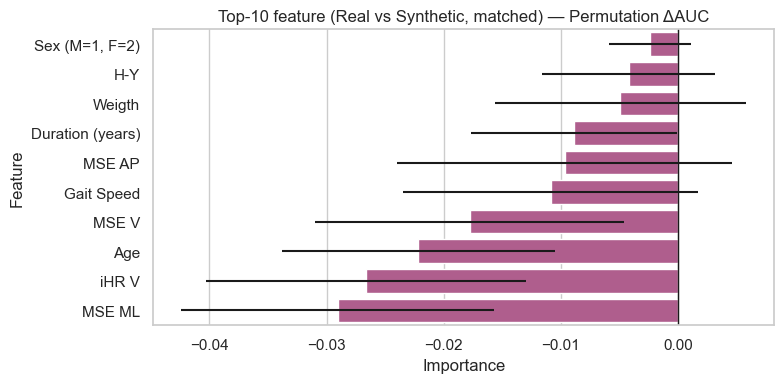

In [36]:
# ======================
# Setup & load
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay
)

sns.set(style="whitegrid")

real   = pd.read_csv("../data/processed/train_original.csv")
synth  = pd.read_csv("../data/processed/train_balanced_ctgan.csv")  # usa il tuo file CTGAN bilanciato
assert "target_bin" in real.columns and "target_bin" in synth.columns


# ======================
# Matching per-feature (fix)
# ======================
def resample_match_on_feature_fixed(real_df, synth_df, feature, by='target_bin',
                                    n_bins=12, seed=42, eps=1e-9):
    """
    Re-weight dei sintetici per allineare la distribuzione di `feature` a quella dei REALI,
    separatamente per ciascun livello di `by`. I bordi dei bin (quantili) sono calcolati
    SOLO sui REALI e riutilizzati per i SINTETICI → niente indici duplicati.
    """
    rng = np.random.default_rng(seed)
    matched_chunks = []

    for g, r_grp in real_df.groupby(by):
        s_grp = synth_df[synth_df[by] == g].copy()
        if s_grp.empty:
            continue

        # 1) Bordi dai REALI (quantili)
        qs = np.linspace(0, 1, n_bins + 1)
        edges = r_grp[feature].quantile(qs).to_numpy()
        edges = np.unique(edges)
        if len(edges) < 3:
            lo, hi = r_grp[feature].min(), r_grp[feature].max()
            if lo == hi:
                hi = lo + 1e-6
            edges = np.linspace(lo, hi, 4)

        # 2) Binning coerente
        r_bins = pd.cut(r_grp[feature], bins=edges, include_lowest=True)
        s_bins = pd.cut(s_grp[feature],  bins=edges, include_lowest=True)

        # 3) Distribuzioni per bin
        pr = r_bins.value_counts(normalize=True).sort_index()
        ps = s_bins.value_counts(normalize=True).sort_index()

        # 4) Pesi pr/ps (se ps=0 → 0)
        w = (pr / (ps + eps)).reindex(pr.index).fillna(0.0)
        s_grp["_bin"] = s_bins.values
        s_grp["_w"]   = s_grp["_bin"].map(w).fillna(0.0)

        # 5) Campionamento pesato (stessa numerosità della classe sintetica)
        if s_grp["_w"].sum() > 0:
            p = (s_grp["_w"] / s_grp["_w"].sum()).values
        else:
            p = None  # fallback uniforme

        idx = rng.choice(s_grp.index, size=len(s_grp), replace=True, p=p)
        matched_chunks.append(s_grp.loc[idx].drop(columns=["_bin", "_w"]))

    return pd.concat(matched_chunks, ignore_index=True)


# --- Applica il matching su Gait Speed per classe ---
feature_to_match = "Gait Speed"
synth_matched = resample_match_on_feature_fixed(
    real_df=real, synth_df=synth,
    feature=feature_to_match, by="target_bin",
    n_bins=12, seed=42
)

print(f"✅ synth_matched shape: {synth_matched.shape}")

# --- Check KS per classe prima/dopo ---
for cls in [0, 1]:
    r = real.loc[real["target_bin"]==cls, feature_to_match]
    s0 = synth.loc[synth["target_bin"]==cls, feature_to_match]
    s1 = synth_matched.loc[synth_matched["target_bin"]==cls, feature_to_match]
    print(f"Classe {cls} — KS p-value  prima={ks_2samp(r, s0).pvalue:.4f} | dopo={ks_2samp(r, s1).pvalue:.4f}")

# --- Plot qualitativo pooled (opzionale) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.kdeplot(real[feature_to_match], ax=axes[0], label="Real", lw=2)
sns.kdeplot(synth[feature_to_match], ax=axes[0], label="Synth (prima)", lw=2)
axes[0].set_title("Prima del matching"); axes[0].legend()

sns.kdeplot(real[feature_to_match], ax=axes[1], label="Real", lw=2)
sns.kdeplot(synth_matched[feature_to_match], ax=axes[1], label="Synth (dopo)", lw=2)
axes[1].set_title("Dopo il matching"); axes[1].legend()
plt.tight_layout(); plt.show()


# ======================
# Discriminatore: Real vs Synthetic (dopo matching)
# ======================
def discriminator_cv(X, y, n_splits=5, seed=42, plot_roc=True, title_suffix="(pooled)"):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    accs, f1s, rocs, prs = [], [], [], []
    roc_lines = []

    for tr, te in skf.split(X, y):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        clf = RandomForestClassifier(n_estimators=300, random_state=seed)
        clf.fit(Xtr, ytr)
        yhat = clf.predict(Xte)
        yprb = clf.predict_proba(Xte)[:, 1]

        accs.append(accuracy_score(yte, yhat))
        f1s.append(f1_score(yte, yhat))
        rocs.append(roc_auc_score(yte, yprb))
        prs.append(average_precision_score(yte, yprb))

        if plot_roc:
            disp = RocCurveDisplay.from_predictions(yte, yprb, name=None)
            roc_lines.append((disp.fpr, disp.tpr))

    if plot_roc:
        plt.figure(figsize=(6,4))
        for fpr, tpr in roc_lines:
            plt.plot(fpr, tpr, alpha=0.25, color="C0")
        plt.plot([0,1],[0,1], "--", color="gray")
        plt.title(f"ROC — Real vs Synthetic {title_suffix}")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.tight_layout(); plt.show()

    return {
        "Accuracy": (np.mean(accs), np.std(accs)),
        "F1":       (np.mean(f1s),  np.std(f1s)),
        "ROC AUC":  (np.mean(rocs), np.std(rocs)),
        "PR  AUC":  (np.mean(prs),  np.std(prs)),
    }


def build_disc_dataset(real_df, synth_df):
    r = real_df.copy();  r["is_real"] = 1
    s = synth_df.copy(); s["is_real"] = 0
    # togli target dalla classificazione real/synth
    r = r.drop(columns=["target_bin"], errors="ignore")
    s = s.drop(columns=["target_bin"], errors="ignore")
    df_all = pd.concat([r, s], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    X = df_all.drop(columns=["is_real"])
    y = df_all["is_real"].astype(int)
    return X, y


# --- Dataset discriminatore (matchato) ---
X_disc, y_disc = build_disc_dataset(real, synth_matched)
print(f"🔎 Discriminator dataset: X={X_disc.shape}, y distribuzione={y_disc.value_counts().to_dict()}")

scores = discriminator_cv(X_disc, y_disc, n_splits=5, seed=42, plot_roc=True, title_suffix="(matched)")
print("\n=== Discriminative Score (matched) ===")
for k, (m, s) in scores.items():
    print(f"{k:8s}: {m:.3f} ± {s:.3f}")


# ======================
# Permutation importance (discriminatore) — dopo matching
# ======================
Xtr, Xte, ytr, yte = train_test_split(X_disc, y_disc, stratify=y_disc, test_size=0.25, random_state=42)
disc = RandomForestClassifier(n_estimators=400, random_state=42).fit(Xtr, ytr)
perm = permutation_importance(disc, Xte, yte, scoring="roc_auc", n_repeats=50, random_state=42)

imp_df = pd.DataFrame({
    "Feature": X_disc.columns,
    "Importance": perm.importances_mean,
    "SD": perm.importances_std
}).sort_values("Importance", ascending=False)

print("\n🔍 Permutation importance (discriminator, matched):")
print(imp_df.head(10).to_string(index=False))

plt.figure(figsize=(8,4))
sns.barplot(data=imp_df.head(10), x="Importance", y="Feature", color="#bc5090", xerr=imp_df.head(10)["SD"])
plt.axvline(0, color="k", lw=1)
plt.title("Top-10 feature (Real vs Synthetic, matched) — Permutation ΔAUC")
plt.tight_layout(); plt.show()

Train REAL: (219, 11)  | class dist: {0: 131, 1: 88}
Test  REAL: (55, 11)   | class dist: {0: 33, 1: 22}


Gen. (-0.41) | Discrim. (-0.07): 100%|██████████| 300/300 [00:02<00:00, 103.82it/s]
Gen. (-0.57) | Discrim. (0.09): 100%|██████████| 300/300 [00:02<00:00, 131.36it/s] 



✅ Salvato train sintetico: ../data/processed/train_synth_full.csv  shape=(219, 11)  | dist={0: 131, 1: 88}
✅ Salvato test sintetico: ../data/processed/test_synth_full.csv  shape=(55, 11)  | dist={0: 33, 1: 22}

=== TSTR (Train=SYNTH, Test=REAL) ===
Accuracy: 0.382
F1      : 0.452
ROC AUC : 0.481
PR AUC  : 0.450
Brier   : 0.414

=== RTS (Train=REAL, Test=SYNTH) ===
Accuracy: 0.691
F1      : 0.414
ROC AUC : 0.674
PR AUC  : 0.654
Brier   : 0.220


<Figure size 600x420 with 0 Axes>

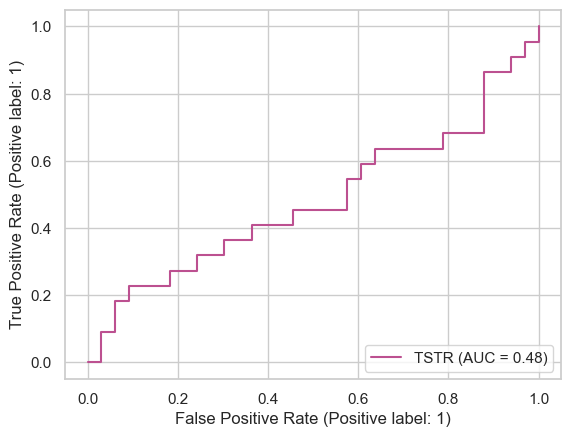

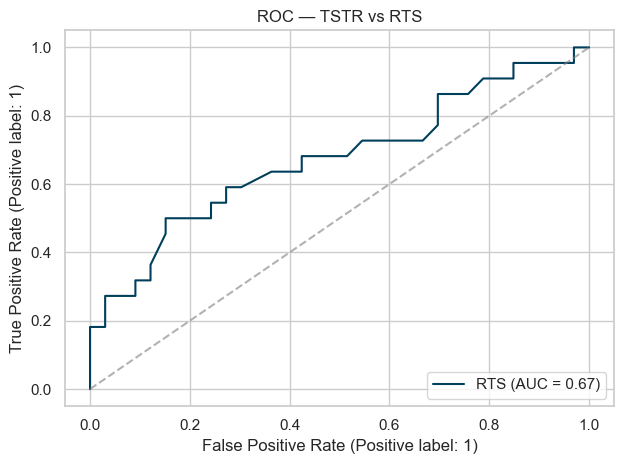

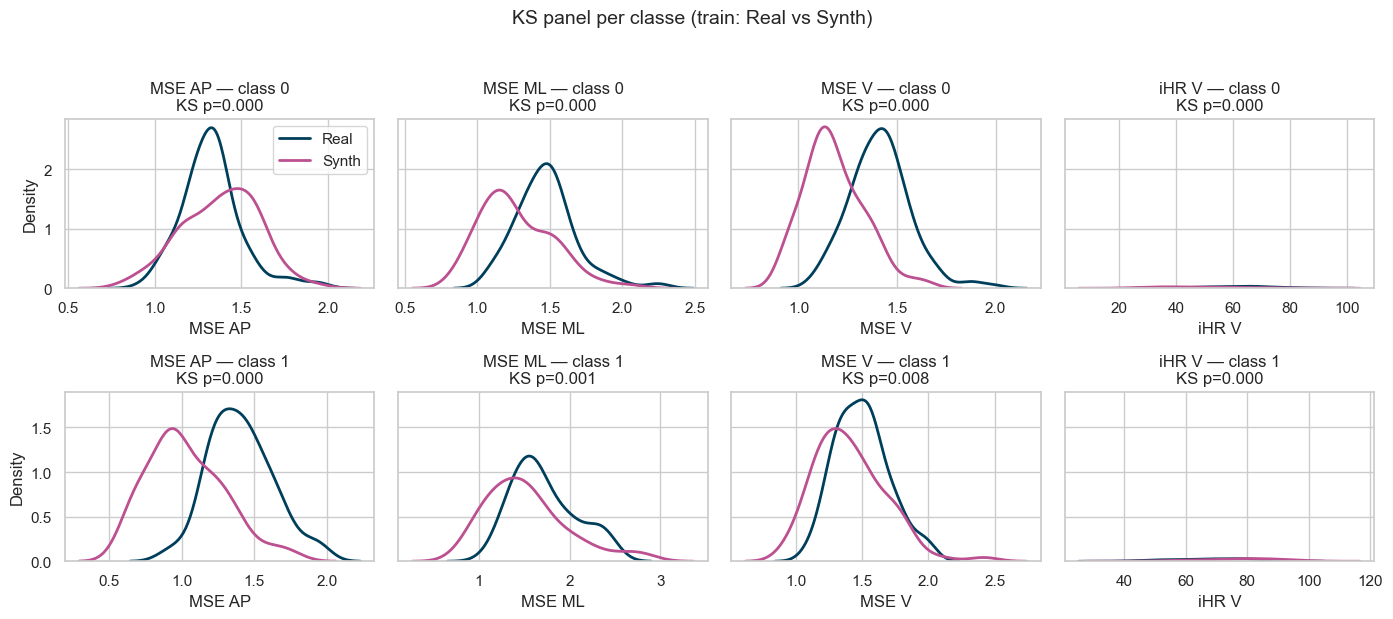

In [37]:
# ============================================
# TSTR / RTS + KS panel per classe (paper-ready)
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ctgan import CTGAN
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, accuracy_score, brier_score_loss,
                             classification_report, RocCurveDisplay)
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp

sns.set(style="whitegrid")

# ---------- PATH ----------
TRAIN_REAL_PATH = "../data/processed/train_original.csv"
TEST_REAL_PATH  = "../data/processed/test_original.csv"
OUT_SYNTH_TRAIN = "../data/processed/train_synth_full.csv"
OUT_SYNTH_TEST  = "../data/processed/test_synth_full.csv"

# ---------- FEATURE SET (come in analisi) ----------
FEATURES = [
    "MSE ML", "iHR V", "MSE V", "MSE AP", "Weigth",
    "Age", "Sex (M=1, F=2)", "H-Y", "Gait Speed", "Duration (years)"
]
TARGET = "target_bin"

# ---------- METRICHE ----------
def evaluate(model, X, y, name=""):
    proba = model.predict_proba(X)[:, 1]
    pred  = (proba >= 0.50).astype(int)
    out = {
        "Accuracy": accuracy_score(y, pred),
        "F1": f1_score(y, pred),
        "ROC AUC": roc_auc_score(y, proba),
        "PR AUC": average_precision_score(y, proba),
        "Brier": brier_score_loss(y, proba),
    }
    print(f"\n=== {name} ===")
    for k,v in out.items():
        print(f"{k:8s}: {v:.3f}")
    return out, proba

# ---------- CTGAN helper per classe ----------
def fit_sample_ctgan_per_class(df, features, target, epochs=300, pac=2, lr=2e-4, verbose=True, seed=42):
    synth_list = []
    discrete_cols = [c for c in ["Sex (M=1, F=2)", "H-Y"] if c in features]

    rng = np.random.default_rng(seed)
    for cls in sorted(df[target].unique()):
        sub = df[df[target]==cls].reset_index(drop=True)
        Xc  = sub[features].copy()
        n   = len(Xc)

        # batch size multiplo di pac
        bs = max(pac, (n // pac) * pac)
        if bs < pac: bs = pac

        ctgan = CTGAN(
            epochs=epochs, batch_size=bs, pac=pac,
            generator_lr=lr, discriminator_lr=lr, verbose=verbose
        )
        ctgan.fit(Xc, discrete_columns=[c for c in discrete_cols if c in Xc.columns])

        Xc_synth = ctgan.sample(n)

        # Post-process: arrotonda e clippa le discrete
        for col in discrete_cols:
            lo, hi = Xc[col].min(), Xc[col].max()
            if col in Xc_synth.columns:
                Xc_synth[col] = np.clip(np.rint(Xc_synth[col]).astype(int), lo, hi)

        Xc_synth[target] = cls
        synth_list.append(Xc_synth[features+[target]])

    synth_full = pd.concat(synth_list, ignore_index=True)
    return synth_full

# ---------- Carica train/test reali ----------
train_real = pd.read_csv(TRAIN_REAL_PATH)
test_real  = pd.read_csv(TEST_REAL_PATH)

# sicurezza colonne
train_real = train_real[FEATURES+[TARGET]].copy()
test_real  = test_real[FEATURES+[TARGET]].copy()

print(f"Train REAL: {train_real.shape}  | class dist: {train_real[TARGET].value_counts().to_dict()}")
print(f"Test  REAL: {test_real.shape}   | class dist: {test_real[TARGET].value_counts().to_dict()}")

# ---------- 1) COSTRUISCI TRAIN SINTETICO COMPLETO (per TSTR) ----------
synth_train = fit_sample_ctgan_per_class(train_real, FEATURES, TARGET, epochs=300, pac=2, verbose=True)
os.makedirs(os.path.dirname(OUT_SYNTH_TRAIN), exist_ok=True)
synth_train.to_csv(OUT_SYNTH_TRAIN, index=False)
print(f"\n✅ Salvato train sintetico: {OUT_SYNTH_TRAIN}  shape={synth_train.shape}  | dist={synth_train[TARGET].value_counts().to_dict()}")

# (Opzionale) COSTRUISCI TEST SINTETICO “specchiato” al test reale (per RTS)
# Generiamo lo stesso numero per classe del test reale.
counts_test = test_real[TARGET].value_counts().to_dict()
synth_test_parts = []
for cls, n in counts_test.items():
    sub = synth_train[synth_train[TARGET]==cls]
    # se non bastano righe sintetiche, campiona con rimpiazzo
    take = sub.sample(n=n, replace=(n>len(sub)), random_state=42)
    synth_test_parts.append(take)
synth_test = pd.concat(synth_test_parts, ignore_index=True)
synth_test.to_csv(OUT_SYNTH_TEST, index=False)
print(f"✅ Salvato test sintetico: {OUT_SYNTH_TEST}  shape={synth_test.shape}  | dist={synth_test[TARGET].value_counts().to_dict()}")

# ---------- 2) TSTR: Train on SYNTH, Test on REAL ----------
X_tr_s, y_tr_s = synth_train[FEATURES], synth_train[TARGET].astype(int)
X_te_r, y_te_r = test_real[FEATURES],  test_real[TARGET].astype(int)

clf_tstr = RandomForestClassifier(n_estimators=400, max_depth=None, class_weight="balanced", random_state=42)
clf_tstr.fit(X_tr_s, y_tr_s)
metrics_tstr, proba_tstr = evaluate(clf_tstr, X_te_r, y_te_r, name="TSTR (Train=SYNTH, Test=REAL)")

# ---------- 3) RTS: Train on REAL, Test on SYNTH ----------
X_tr_r, y_tr_r = train_real[FEATURES], train_real[TARGET].astype(int)
X_te_s, y_te_s = synth_test[FEATURES], synth_test[TARGET].astype(int)

clf_rts = RandomForestClassifier(n_estimators=400, max_depth=None, class_weight="balanced", random_state=42)
clf_rts.fit(X_tr_r, y_tr_r)
metrics_rts, proba_rts = evaluate(clf_rts, X_te_s, y_te_s, name="RTS (Train=REAL, Test=SYNTH)")

# ---------- 4) ROC overlay (TSTR & RTS) ----------
plt.figure(figsize=(6,4.2))
RocCurveDisplay.from_predictions(y_te_r, proba_tstr, name="TSTR", color="#bc5090")
RocCurveDisplay.from_predictions(y_te_s, proba_rts,  name="RTS",  color="#003f5c")
plt.plot([0,1],[0,1],"--",color="gray",alpha=0.6)
plt.title("ROC — TSTR vs RTS")
plt.tight_layout(); plt.show()

# ---------- 5) KS panel per classe su 4 biomarcatori ----------
panel_feats = ["MSE AP", "MSE ML", "MSE V", "iHR V"]
real = train_real.copy()
synth = synth_train.copy()

fig, axes = plt.subplots(2, len(panel_feats), figsize=(14,6), sharex=False, sharey="row")
for r, cls in enumerate([0,1]):
    for c, feat in enumerate(panel_feats):
        ax = axes[r,c]
        a = real[real[TARGET]==cls][feat].dropna()
        b = synth[synth[TARGET]==cls][feat].dropna()
        # KS
        ks_p = ks_2samp(a, b).pvalue
        sns.kdeplot(a, ax=ax, label="Real", lw=2, color="#003f5c")
        sns.kdeplot(b, ax=ax, label="Synth", lw=2, color="#bc5090")
        ax.set_title(f"{feat} — class {cls}\nKS p={ks_p:.3f}")
        if c==0:
            ax.set_ylabel("Density")
        else:
            ax.set_ylabel("")
        if r==0 and c==0:
            ax.legend(frameon=True)
fig.suptitle("KS panel per classe (train: Real vs Synth)", y=1.03, fontsize=14)
plt.tight_layout(); plt.show()

In [ ]:
import pandas as pd, json, os
paths = {
    "train_original":"../data/processed/train_original.csv",
    "train_balanced_ctgan":"../data/processed/train_balanced_ctgan.csv",
    "test_original":"../data/processed/test_original.csv",
}
card = {}
for name,p in paths.items():
    df = pd.read_csv(p)
    card[name] = {
        "shape": df.shape,
        "target_dist": df["target_bin"].value_counts().to_dict(),
        "columns": list(df.columns),
    }
os.makedirs("../results/cards", exist_ok=True)
with open("../results/cards/datasets_summary.json","w") as f:
    json.dump(card, f, indent=2)
card

{'train_original': {'shape': (219, 11),
  'target_dist': {0: 131, 1: 88},
  'columns': ['MSE ML',
   'iHR V',
   'MSE V',
   'MSE AP',
   'Weigth',
   'Age',
   'Sex (M=1, F=2)',
   'H-Y',
   'Gait Speed',
   'Duration (years)',
   'target_bin']},
 'train_balanced_ctgan': {'shape': (262, 11),
  'target_dist': {1: 131, 0: 131},
  'columns': ['MSE ML',
   'iHR V',
   'MSE V',
   'MSE AP',
   'Weigth',
   'Age',
   'Sex (M=1, F=2)',
   'H-Y',
   'Gait Speed',
   'Duration (years)',
   'target_bin']},
 'test_original': {'shape': (55, 11),
  'target_dist': {0: 33, 1: 22},
  'columns': ['MSE ML',
   'iHR V',
   'MSE V',
   'MSE AP',
   'Weigth',
   'Age',
   'Sex (M=1, F=2)',
   'H-Y',
   'Gait Speed',
   'Duration (years)',
   'target_bin']}}

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, classification_report
from sklearn.utils import resample
import numpy as np, pandas as pd, joblib

def eval_model(train_df, test_df, name):
    Xtr, ytr = train_df.drop(columns=["target_bin"]), train_df["target_bin"]
    Xte, yte = test_df.drop(columns=["target_bin"]), test_df["target_bin"]
    clf = RandomForestClassifier(class_weight="balanced", random_state=42)
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]
    pred  = (proba>=0.40).astype(int)   # soglia “clinica” decisa
    return {
        "setup": name,
        "ROC_AUC": roc_auc_score(yte, proba),
        "PR_AUC": average_precision_score(yte, proba),
        "Brier": brier_score_loss(yte, proba),
        "Precision@0.40": ( (pred==1)&(yte==1) ).sum() / max((pred==1).sum(),1),
        "Recall@0.40":    ( (pred==1)&(yte==1) ).sum() / (yte==1).sum(),
        "F1@0.40":        classification_report(yte, pred, output_dict=True)['weighted avg']['f1-score'],
    }, clf

train_orig = pd.read_csv("../data/processed/train_original.csv")
train_ctgan= pd.read_csv("../data/processed/train_balanced_ctgan.csv")
test_orig  = pd.read_csv("../data/processed/test_original.csv")

# Oversampling semplice sul train
maj = train_orig[train_orig.target_bin==0]
minr= train_orig[train_orig.target_bin==1]
minr_up = resample(minr, replace=True, n_samples=len(maj), random_state=42)
train_over = pd.concat([maj, minr_up], ignore_index=True)

rows, models = [], {}
for name,df in [("Baseline (real-only)", train_orig),
                ("Oversample (ROS)",   train_over),
                ("CTGAN (augmented)",  train_ctgan)]:
    mrow, clf = eval_model(df, test_orig, name)
    rows.append(mrow); models[name]=clf

summary = pd.DataFrame(rows).sort_values("PR_AUC",ascending=False)
summary

setup   ROC_AUC    PR_AUC     Brier  Precision@0.40  \
2     CTGAN (augmented)  0.755510  0.746099  0.190358        0.566667   
0  Baseline (real-only)  0.743113  0.724077  0.191604        0.681818   
1      Oversample (ROS)  0.735537  0.717192  0.195222        0.666667   

   Recall@0.40   F1@0.40  
2     0.772727  0.675332  
0     0.681818  0.745455  
1     0.636364  0.726137

In [40]:
final_model = models["CTGAN (augmented)"]
joblib.dump(final_model, "../models/rf_ctgan_final.joblib")

with open("../models/decision_threshold.txt","w") as f:
    f.write("threshold=0.40  # chosen to balance precision/recall on test\n")

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import brier_score_loss

# === 1. Crea cartella di output se non esiste ===
os.makedirs("../results/metrics", exist_ok=True)

# === 2. Salva riepilogo esperimenti (Baseline, ROS, CTGAN) ===
summary.to_csv("../results/metrics/exp_balancing_summary.csv", index=False)

# === 3. Funzione: metriche a soglie specifiche ===
def metrics_at_threshold(clf, X, y, thr):
    """
    Calcola metriche a una soglia di decisione custom.
    clf : modello allenato
    X   : feature set
    y   : target (0/1)
    thr : soglia di decisione
    """
    proba = clf.predict_proba(X)[:, 1]
    pred  = (proba >= thr).astype(int)

    from sklearn.metrics import precision_score, recall_score, f1_score

    return {
        "thr": thr,
        "precision": precision_score(y, pred),
        "recall": recall_score(y, pred),
        "f1": f1_score(y, pred),
        "brier": brier_score_loss(y, proba)
    }

# === 4. Calcola metriche sulle soglie chiave (0.26, 0.40, 0.50) ===
Xte = test_orig.drop(columns=["target_bin"])
yte = test_orig["target_bin"]

thr_tbl = pd.DataFrame([
    metrics_at_threshold(final_model, Xte, yte, t) for t in [0.26, 0.40, 0.50]
])

# === 5. Salva tabella risultati per soglie ===
thr_tbl.to_csv("../results/metrics/threshold_sensitivity.csv", index=False)

print("✅ File salvati in ../results/metrics")
print("- exp_balancing_summary.csv")
print("- threshold_sensitivity.csv")

display(thr_tbl)

✅ File salvati in ../results/
- exp_balancing_summary.csv
- threshold_sensitivity.csv


thr  precision    recall        f1     brier
0  0.26   0.450000  0.818182  0.580645  0.190358
1  0.40   0.566667  0.772727  0.653846  0.190358
2  0.50   0.652174  0.681818  0.666667  0.190358

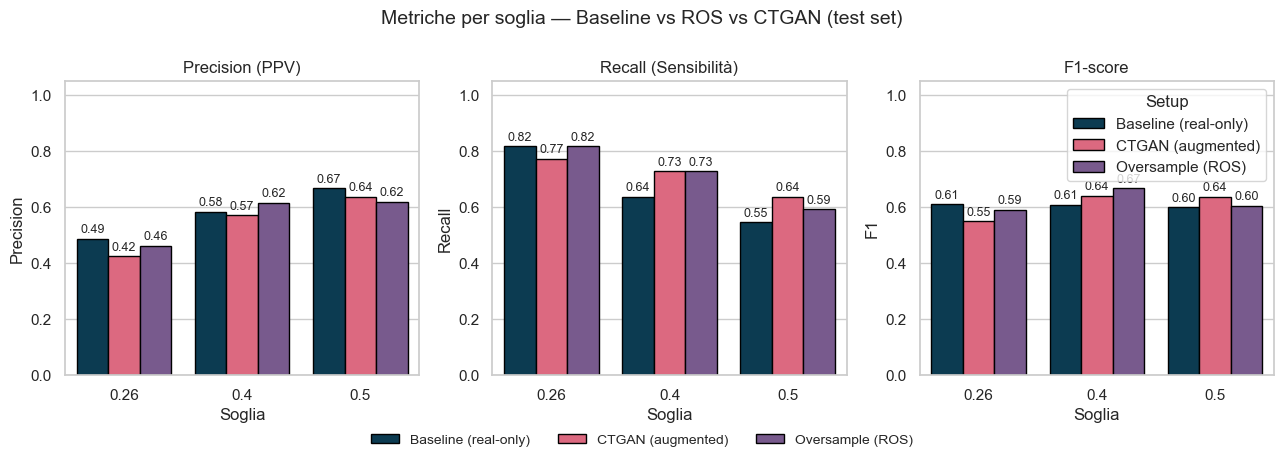

✅ Salvati i risultati:
- Tabella per soglia: ../data/processed/threshold_metrics_by_setup.csv
- Figura: ../figures/threshold_metrics_panel.png


In [ ]:
# ===========================
# Fig. | Metriche per soglia (0.26 / 0.40 / 0.50) — Baseline vs ROS vs CTGAN
# ===========================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, brier_score_loss, roc_auc_score, average_precision_score
from imblearn.over_sampling import RandomOverSampler

# ---- paths
DATA_DIR = "../data/processed"
TRAIN_REAL = os.path.join(DATA_DIR, "train_original.csv")
TRAIN_CTGAN = os.path.join(DATA_DIR, "train_balanced_ctgan.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test_original.csv")
OUT_DIR    = "../results/metrics"   # dove salvare i csv
FIG_PATH   = "../figurez/threshold_metrics_panel.png"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(FIG_PATH), exist_ok=True)

# ---- load
train_real = pd.read_csv(TRAIN_REAL)
train_ctgn = pd.read_csv(TRAIN_CTGAN)
test_df    = pd.read_csv(TEST_PATH)

feature_cols = [c for c in test_df.columns if c != "target_bin"]

X_te = test_df[feature_cols].copy()
y_te = test_df["target_bin"].astype(int).copy()

# ---- helper: train RF + predict proba
def fit_rf(X, y, class_weight=None, random_state=42):
    clf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        class_weight=class_weight,
        random_state=random_state,
        n_jobs=-1
    )
    clf.fit(X, y)
    return clf

# ---- prepara 3 setup
# 1) Baseline (real-only)
X_tr_bas = train_real[feature_cols]; y_tr_bas = train_real["target_bin"].astype(int)
clf_bas  = fit_rf(X_tr_bas, y_tr_bas, class_weight="balanced")
proba_bas = clf_bas.predict_proba(X_te)[:, 1]
brier_bas = brier_score_loss(y_te, proba_bas)
roc_bas   = roc_auc_score(y_te, proba_bas)
pr_bas    = average_precision_score(y_te, proba_bas)

# 2) Oversample (ROS)
ros = RandomOverSampler(random_state=42)
X_tr_ros, y_tr_ros = ros.fit_resample(X_tr_bas, y_tr_bas)
clf_ros  = fit_rf(X_tr_ros, y_tr_ros, class_weight=None)
proba_ros = clf_ros.predict_proba(X_te)[:, 1]
brier_ros = brier_score_loss(y_te, proba_ros)
roc_ros   = roc_auc_score(y_te, proba_ros)
pr_ros    = average_precision_score(y_te, proba_ros)

# 3) CTGAN (augmented) – usa il train già bilanciato sintetico
X_tr_ctg = train_ctgn[feature_cols]; y_tr_ctg = train_ctgn["target_bin"].astype(int)
clf_ctg  = fit_rf(X_tr_ctg, y_tr_ctg, class_weight=None)
proba_ctg = clf_ctg.predict_proba(X_te)[:, 1]
brier_ctg = brier_score_loss(y_te, proba_ctg)
roc_ctg   = roc_auc_score(y_te, proba_ctg)
pr_ctg    = average_precision_score(y_te, proba_ctg)

# ---- soglie e metriche
thresholds = [0.26, 0.40, 0.50]
def metrics_at_threshold(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0)
    }

rows = []
for setup, proba, brier, roc_auc, pr_auc in [
    ("Baseline (real-only)", proba_bas, brier_bas, roc_bas, pr_bas),
    ("Oversample (ROS)",     proba_ros, brier_ros, roc_ros, pr_ros),
    ("CTGAN (augmented)",    proba_ctg, brier_ctg, roc_ctg, pr_ctg),
]:
    for thr in thresholds:
        m = metrics_at_threshold(y_te, proba, thr)
        rows.append({
            "Setup": setup,
            "Threshold": thr,
            "Precision": m["precision"],
            "Recall": m["recall"],
            "F1": m["f1"],
            "Brier": brier,
            "ROC_AUC": roc_auc,
            "PR_AUC": pr_auc,
        })

thr_df = pd.DataFrame(rows)

# ---- salva CSV (tabella completa per soglia)
thr_csv = os.path.join(OUT_DIR, "threshold_metrics_by_setup.csv")
thr_df.to_csv(thr_csv, index=False)

# ---- figura: 3 pannelli (Precision / Recall / F1) con barre multiple per soglia
sns.set_theme(style="whitegrid", font_scale=1.0)
palette = {
    "Baseline (real-only)": "#003f5c",
    "Oversample (ROS)": "#7a5195",
    "CTGAN (augmented)": "#ef5675",
}

fig, axes = plt.subplots(1, 3, figsize=(13, 4.2), sharey=False)

metrics = ["Precision", "Recall", "F1"]
titles  = ["Precision (PPV)", "Recall (Sensibilità)", "F1-score"]

for ax, metric, title in zip(axes, metrics, titles):
    plot_df = thr_df.copy()
    # Ordina soglie sull'asse x
    plot_df["Threshold"] = plot_df["Threshold"].astype(float)
    plot_df = plot_df.sort_values(["Threshold", "Setup"])

    # barplot raggruppato per soglia con hue=Setup
    sns.barplot(
        data=plot_df, x="Threshold", y=metric, hue="Setup",
        palette=palette, ax=ax, edgecolor="black"
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Soglia")
    ax.set_ylabel(metric if metric != "F1" else "F1")
    ax.set_ylim(0, 1.05)
    # etichette sui bar
    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", padding=2, fontsize=9)

    # legenda solo nell'ultimo pannello
    if ax is not axes[-1]:
        ax.get_legend().remove()

# legenda globale
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10, bbox_to_anchor=(0.5, -0.02))

fig.suptitle("Metriche per soglia — Baseline vs ROS vs CTGAN (test set)", y=1.05, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(bottom=0.18, top=0.88)
plt.savefig(FIG_PATH, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Salvati i risultati:\n- Tabella per soglia: {thr_csv}\n- Figura: {FIG_PATH}")

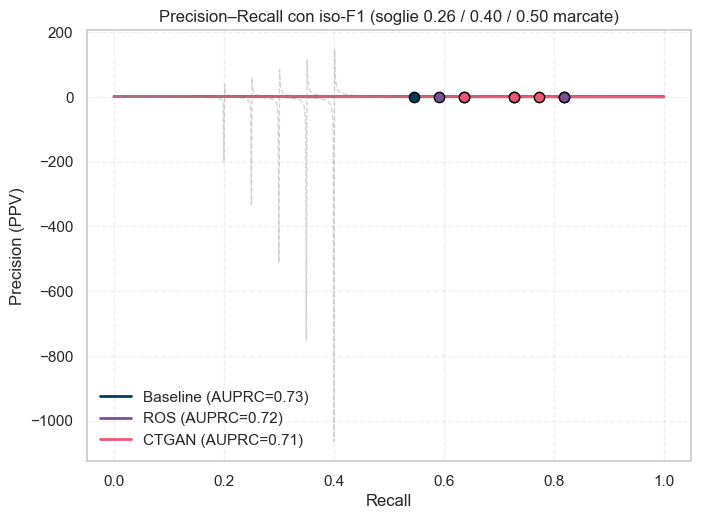

In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- ricarica se serve
import pandas as pd
DATA_DIR = "../data/processed"
test_df  = pd.read_csv(f"{DATA_DIR}/test_original.csv")
feature_cols = [c for c in test_df.columns if c!="target_bin"]
y_te = test_df["target_bin"].astype(int)

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

train_real = pd.read_csv(f"{DATA_DIR}/train_original.csv")
train_ctgn = pd.read_csv(f"{DATA_DIR}/train_balanced_ctgan.csv")

def fit_rf(X,y, cw=None):
    m = RandomForestClassifier(n_estimators=400, min_samples_leaf=2, class_weight=cw, random_state=42, n_jobs=-1)
    m.fit(X,y); return m

# Baseline
Xtr, ytr = train_real[feature_cols], train_real["target_bin"].astype(int)
Xte      = test_df[feature_cols]
clf_bas  = fit_rf(Xtr,ytr, cw="balanced")
proba_bas = clf_bas.predict_proba(Xte)[:,1]

# ROS
from imblearn.over_sampling import RandomOverSampler
X_ros, y_ros = RandomOverSampler(random_state=42).fit_resample(Xtr,ytr)
clf_ros  = fit_rf(X_ros,y_ros)
proba_ros = clf_ros.predict_proba(Xte)[:,1]

# CTGAN
Xct, yct = train_ctgn[feature_cols], train_ctgn["target_bin"].astype(int)
clf_ctg  = fit_rf(Xct,yct)
proba_ctg = clf_ctg.predict_proba(Xte)[:,1]

curves = {
  "Baseline": (precision_recall_curve(y_te, proba_bas), average_precision_score(y_te, proba_bas)),
  "ROS":      (precision_recall_curve(y_te, proba_ros), average_precision_score(y_te, proba_ros)),
  "CTGAN":    (precision_recall_curve(y_te, proba_ctg), average_precision_score(y_te, proba_ctg)),
}

palette = {"Baseline":"#003f5c","ROS":"#7a5195","CTGAN":"#ef5675"}
iso_f1 = [0.4,0.5,0.6,0.7,0.8]

plt.figure(figsize=(7.8,5.6))
for name,(prc, ap) in curves.items():
    p,r,t = prc
    plt.plot(r,p,color=palette[name],lw=2,label=f"{name} (AUPRC={ap:.2f})")

# iso-F1
r = np.linspace(0.001,1,800)
for f in iso_f1:
    p = (f*r)/(2*r - f + 1e-12)
    p[r>=(f/(2-f))] = np.nan
    plt.plot(r,p,ls="--",lw=1,color="gray",alpha=0.35)

# markers soglie chiave
thr_list = [0.26,0.40,0.50]
for name,proba in {"Baseline":proba_bas,"ROS":proba_ros,"CTGAN":proba_ctg}.items():
    for thr in thr_list:
        pred = (proba>=thr).astype(int)
        tp = ((pred==1)&(y_te==1)).sum(); fp=((pred==1)&(y_te==0)).sum()
        fn = ((pred==0)&(y_te==1)).sum()
        prec = tp/(tp+fp+1e-12); rec= tp/(tp+fn+1e-12)
        plt.scatter(rec,prec, s=55, color=palette[name], edgecolor="black", zorder=5)

plt.xlabel("Recall"); plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall con iso-F1 (soglie 0.26 / 0.40 / 0.50 marcate)")
plt.legend(frameon=False)
plt.grid(True, ls="--", alpha=0.3)
os.makedirs("../figurez/global", exist_ok=True)
plt.savefig("../figurez/global/PR_isoF1_thresholds.png", dpi=300, bbox_inches="tight")
plt.show()

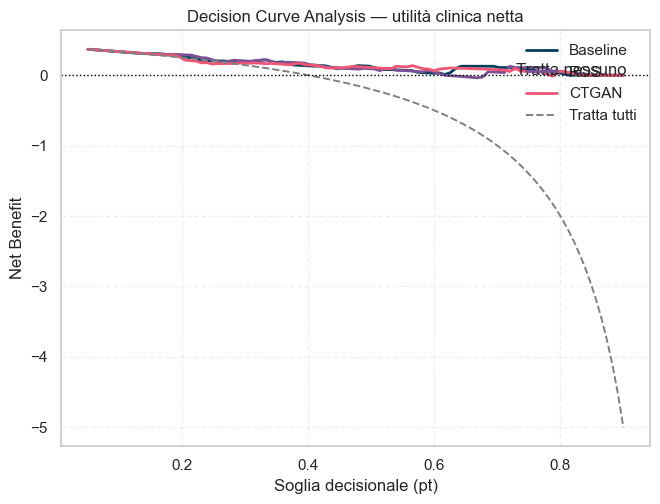

In [ ]:
import numpy as np, matplotlib.pyplot as plt, os

def net_benefit(y_true, proba, thresholds):
    y_true = np.asarray(y_true).astype(int)
    NB = []
    N = len(y_true)
    for pt in thresholds:
        pred = (proba>=pt).astype(int)
        tp = ((pred==1)&(y_true==1)).sum()
        fp = ((pred==1)&(y_true==0)).sum()
        NB.append((tp/N) - (fp/N) * (pt/(1-pt+1e-12)))
    return np.array(NB)

thr = np.linspace(0.05,0.9,100)
nb_bas = net_benefit(y_te, proba_bas, thr)
nb_ros = net_benefit(y_te, proba_ros, thr)
nb_ctg = net_benefit(y_te, proba_ctg, thr)

plt.figure(figsize=(7.6,5.4))
plt.plot(thr, nb_bas, color=palette["Baseline"], lw=2, label="Baseline")
plt.plot(thr, nb_ros, color=palette["ROS"],      lw=2, label="ROS")
plt.plot(thr, nb_ctg, color=palette["CTGAN"],    lw=2, label="CTGAN")
# strategie “Tratta tutti” / “Tratta nessuno”
prev = y_te.mean()
nb_all = prev - (1-prev)*(thr/(1-thr+1e-12))
plt.plot(thr, nb_all, color="gray", ls="--", lw=1.4, label="Tratta tutti")
plt.axhline(0, color="black", lw=1, ls=":"); plt.text(0.905, 0.005, "Tratta nessuno", ha="right")

plt.xlabel("Soglia decisionale (pt)")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis — utilità clinica netta")
plt.legend(frameon=False, loc="upper right")
plt.grid(True, ls="--", alpha=0.3)
plt.savefig("../figurez/global/decision_curve_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

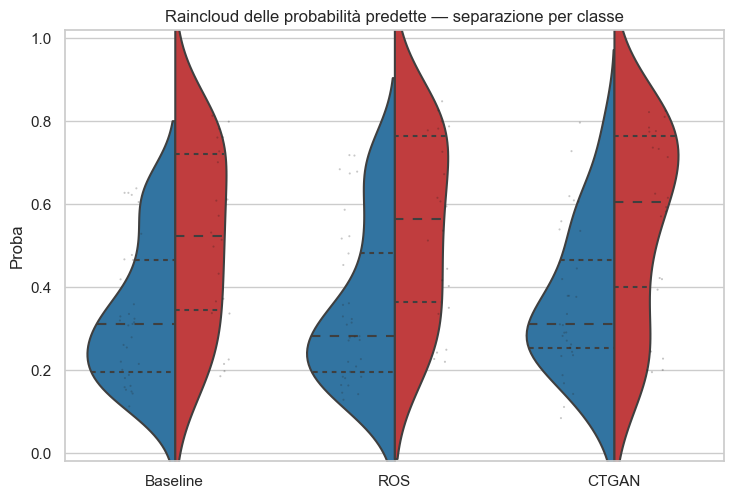

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, os
sns.set_theme(style="whitegrid")

df_probs = pd.DataFrame({
    "y": y_te.values,
    "Baseline": proba_bas,
    "ROS": proba_ros,
    "CTGAN": proba_ctg
})
df_long = df_probs.melt(id_vars="y", var_name="Setup", value_name="Proba")
df_long["Classe"] = df_long["y"].map({0:"No Triade", 1:"Triade"})

plt.figure(figsize=(8.5,5.6))
sns.violinplot(data=df_long, x="Setup", y="Proba", hue="Classe",
               split=True, inner="quartile", palette={"No Triade":"#1f77b4","Triade":"#d62728"})
sns.stripplot(data=df_long, x="Setup", y="Proba", hue="Classe",
              dodge=True, color="k", alpha=0.25, size=3, marker=".")
plt.ylim(-0.02, 1.02)
plt.title("Raincloud delle probabilità predette — separazione per classe")
plt.xlabel(""); plt.legend([],[],frameon=False)  # legenda già chiara via colori
plt.savefig("../figurez/global/raincloud_probabilities.png", dpi=300, bbox_inches="tight")
plt.show()

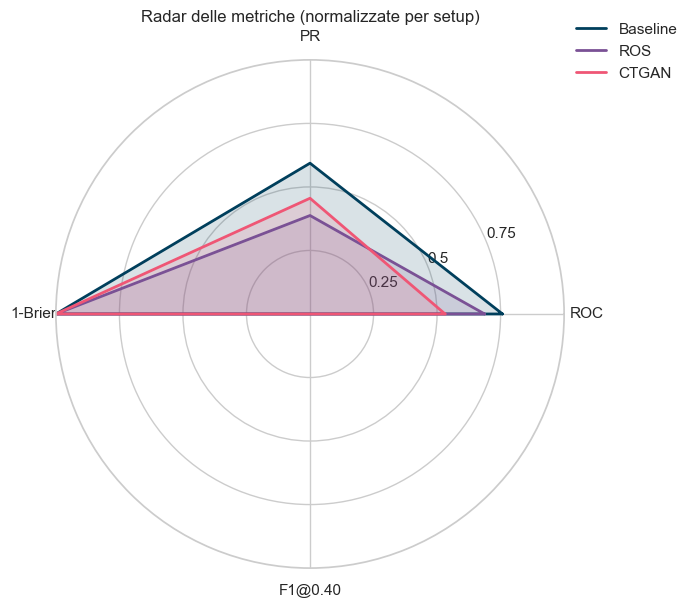

In [ ]:
import numpy as np, matplotlib.pyplot as plt, os
from sklearn.metrics import f1_score

def f1_at(y_true, proba, thr): 
    return f1_score(y_true, (proba>=thr).astype(int), zero_division=0)

stats = {
  "Baseline": {"ROC": roc_auc_score(y_te, proba_bas),
               "PR":  average_precision_score(y_te, proba_bas),
               "1-Brier": 1 - brier_score_loss(y_te, proba_bas),
               "F1@0.40":  f1_at(y_te, proba_bas, 0.40)},
  "ROS":      {"ROC": roc_auc_score(y_te, proba_ros),
               "PR":  average_precision_score(y_te, proba_ros),
               "1-Brier": 1 - brier_score_loss(y_te, proba_ros),
               "F1@0.40":  f1_at(y_te, proba_ros, 0.40)},
  "CTGAN":    {"ROC": roc_auc_score(y_te, proba_ctg),
               "PR":  average_precision_score(y_te, proba_ctg),
               "1-Brier": 1 - brier_score_loss(y_te, proba_ctg),
               "F1@0.40":  f1_at(y_te, proba_ctg, 0.40)}
}
labels = list(next(iter(stats.values())).keys())
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6.6,6.6))
ax = plt.subplot(111, polar=True)
for name,color in [("Baseline",palette["Baseline"]),("ROS",palette["ROS"]),("CTGAN",palette["CTGAN"])]:
    vals = [stats[name][k] for k in labels]
    vals = np.array(vals); vals = (vals - vals.min())/(vals.max()-vals.min()+1e-12)  # normalizza 0-1 intra-setup
    vals = vals.tolist(); vals += vals[:1]
    ax.plot(angles, vals, lw=2, label=name, color=color)
    ax.fill(angles, vals, alpha=0.15, color=color)

ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
ax.set_yticks([0.25,0.5,0.75]); ax.set_yticklabels(["0.25","0.5","0.75"])
ax.set_ylim(0,1)
ax.set_title("Radar delle metriche (normalizzate per setup)")
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10), frameon=False)
os.makedirs("../figurez/global", exist_ok=True)
plt.savefig("../figurez/global/radar_metrics.png", dpi=300, bbox_inches="tight")
plt.show()